## Vesuvius Challenge - Ink Detection Training Notebook

### Setup

In [1]:
# # Pretrained weights
# # ref - https://github.com/kenshohara/3D-ResNets-PyTorch
# !pip install gdown
# !gdown 1Nb4abvIkkp_ydPFA9sNPT1WakoVKA8Fa

# # Utility packages for reading and visualizing volumes
# !pip install zarr imageio-ffmpeg

# save model checkpoints
!mkdir ./ckpts

In [2]:
import os
import gc
import sys
import zarr
import random
import imageio
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Video

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda import amp
from torch.utils.data import Dataset, DataLoader

sys.path.append("./resnet3d")
from resnet3d import generate_model

### Config

In [3]:
LR = 1e-4
EPOCHS = 500
BATCH_SIZE = 32
CROP_SIZE = 256
INITIAL_IMAGE_SIZE = 768
Z_START = 8
Z_DIMS = 32
TRAIN_FRAGMENTS = ["2", "3"]
TEST_FRAGMENT = "1"

### Load data

In [4]:


FRAGMENTS_ZARR = {
    "1" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-1.zarr", mode="r"),
    "2" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-2.zarr", mode="r"),
    "3" : zarr.open("/home/viktor/Documents/kaggle/vesuvius-challenge/kaggle-data/train-3.zarr", mode="r")
}

FRAGMENTS_SHAPE = {k : v.mask.shape for k, v in FRAGMENTS_ZARR.items()}

### Visualise input

In [5]:
fragment = FRAGMENTS_ZARR["1"]
x, y = 2000, 2000

fragment_cropped = fragment.surface_volume[y:y+CROP_SIZE, x:x+CROP_SIZE, Z_START:Z_START+Z_DIMS]
imageio.mimwrite("fragment_crop.mp4", fragment_cropped.transpose(2, 0, 1), "ffmpeg")
Video("fragment_crop.mp4", height=256, width=256)

Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from uint16 to uint8. Losing 8 bits of resolution. C

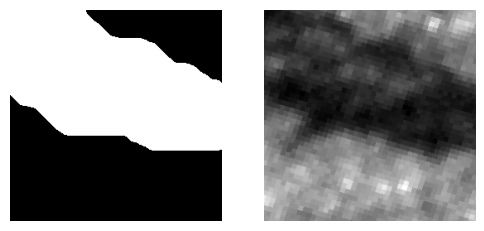

In [6]:
mask_cropped = fragment.truth[y:y+CROP_SIZE, x:x+CROP_SIZE]
ir_cropped = fragment.infrared[y:y+CROP_SIZE, x:x+CROP_SIZE]

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(mask_cropped, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(ir_cropped, cmap="gray")
plt.axis("off")
plt.show()

In [7]:
del fragment, fragment_cropped, mask_cropped, ir_cropped
gc.collect()

4108

### Dataloaders

In [8]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# class VesuviusTrain(Dataset):
#     def __init__(self, fragments):
#         self.fragments = fragments
#         self.xys = []
        
#         for fragment in fragments:
#             H, W = FRAGMENTS_SHAPE[fragment]
#             for y in range(0, H-CROP_SIZE+1, CROP_SIZE):
#                 for x in range(0, W-CROP_SIZE+1, CROP_SIZE):
#                     self.xys.append((fragment, x, y, W, H))
        
#         train_aug_list = [
#                 # A.RandomResizedCrop(
#                 #     size, size, scale=(0.85, 1.0)),
#                 A.HorizontalFlip(p=0.5),
#                 A.VerticalFlip(p=0.5),
#                 A.RandomBrightnessContrast(p=0.75),
#                 A.CoarseDropout(max_holes=1, max_width=int(CROP_SIZE * 0.1), max_height=int(size * 0.1), 
#                                 mask_fill_value=0, p=0.5),
#                 A.ShiftScaleRotate(p=0.75),
#                 A.Rotate(limit=90, p=0.9), 
#                 A.OneOf([
#                         A.GaussNoise(var_limit=[10, 50]),
#                         A.GaussianBlur(),
#                         A.MotionBlur(),
#                         ], p=0.4),
#                 A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
#                 A.Cutout(max_h_size=int(size * 0.6),
#                          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
#                 A.Normalize(
#                     mean= [0] * Z_DIMS,
#                     std= [1] * Z_DIMS
#                 ),
#                 ToTensorV2(transpose_mask=True),
#             ]
        
        
        
#     def __getitem__(self, i):
#         fragment, x1, y1, W, H = self.xys[i]
#         z1, z2 = Z_START, Z_START+Z_DIMS
        
#         x_offset = random.randint(-32 if x1 != 0 else 0, 32)
#         y_offset = random.randint(-32 if y1 != 0 else 0, 32)
        
#         x1 += x_offset
#         y1 += y_offset
        
#         x2 = x1 + CROP_SIZE
#         y2 = y1 + CROP_SIZE
        
#         if x2 > W:
#             x1 -= x_offset
#             x2 -= x_offset
            
#         if y2 > H:
#             y1 -= y_offset
#             y2 -= y_offset
        
#         frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
#         mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
#         if random.random() > 0.5:
#             frag_crop = np.flip(frag_crop, axis=1).copy()
#             mask_crop = np.flip(mask_crop, axis=1).copy()

#         frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
#         frag_crop = frag_crop/65535.0
#         frag_crop = (frag_crop - 0.45)/0.225
        
#         mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        
        
        
        
#         return frag_crop, mask_crop

#     def __len__(self):
#         return len(self.xys)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class VesuviusTrain(Dataset):
    def __init__(self, fragments):
        self.fragments = fragments
        self.xys = []
        
        for fragment in fragments:
            H, W = FRAGMENTS_SHAPE[fragment]
            for y in range(0, H-INITIAL_IMAGE_SIZE+1, INITIAL_IMAGE_SIZE):
                for x in range(0, W-INITIAL_IMAGE_SIZE+1, INITIAL_IMAGE_SIZE):
                    surface = FRAGMENTS_ZARR[fragment].surface_volume[y:y+INITIAL_IMAGE_SIZE, x:x+INITIAL_IMAGE_SIZE, 0]
                    self.xys.append((fragment, x, y, W, H))
                    # if np.sum(np.where(surface>0)) / (surface.shape[0] * surface.shape[1]) > 0.2:
                    #     self.xys.append((fragment, x, y, W, H))
        
        self.train_aug_list = [
                # A.RandomResizedCrop(
                #     size, size, scale=(0.85, 1.0)),
                
                # resize to CROP_SIZExCROP_SIZE
                A.Resize(CROP_SIZE, CROP_SIZE),
                
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                
                # A.RandomBrightnessContrast(p=0.75),
                # A.CoarseDropout(max_holes=1, max_width=int(INITIAL_IMAGE_SIZE * 0.1), max_height=int(INITIAL_IMAGE_SIZE * 0.1), 
                #                 mask_fill_value=0, p=0.5),
                # A.ShiftScaleRotate(p=0.75),
                
                A.Rotate(limit=90, p=0.9), 
                
                # A.OneOf([
                #         A.GaussNoise(var_limit=[1, 5]),
                #         A.GaussianBlur(),
                #         A.MotionBlur(),
                #         ], p=0.4),
                # A.GridDistortion(num_steps=1, distort_limit=0.3, p=0.5),
                
                # A.Cutout(max_h_size=int(INITIAL_IMAGE_SIZE * 0.2),
                #          max_w_size=int(INITIAL_IMAGE_SIZE * 0.2), num_holes=1, p=1.0),
                # A.Normalize(
                #     mean= [0] * Z_DIMS,
                #     std= [1] * Z_DIMS
                # ),
                
                
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.train_aug_list)
        
        
        
    def __getitem__(self, i):
        fragment, x1, y1, W, H = self.xys[i]
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        x_offset = random.randint(-256 if x1 != 0 else 0, 256)
        y_offset = random.randint(-256 if y1 != 0 else 0, 256)
        
        x1 += x_offset
        y1 += y_offset
        
        x2 = x1 + INITIAL_IMAGE_SIZE
        y2 = y1 + INITIAL_IMAGE_SIZE
        
        if x2 > W:
            x1 -= x_offset
            x2 -= x_offset
            
        if y2 > H:
            y1 -= y_offset
            y2 -= y_offset
        
        frag_crop = FRAGMENTS_ZARR[fragment].surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = FRAGMENTS_ZARR[fragment].truth[y1:y2, x1:x2]
        
        # if random.random() > 0.5:
        #     frag_crop = np.flip(frag_crop, axis=1).copy()
        #     mask_crop = np.flip(mask_crop, axis=1).copy()

        # Perform train augmentations

        frag_crop = frag_crop/65535.0
        

        # Apply the augmentations
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]

        # normalize
        
        # frag_crop = (frag_crop - 0.45)/0.225
        
        frag_crop = frag_crop.unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        
        # image -> image * (1 - random_from_0_to_0.3 * mask_crop)
        if np.random.uniform(0, 1.0) > 0.5:
            frag_crop = frag_crop * (1 - np.random.uniform(0, 0.3) * mask_crop)
        
        
        return frag_crop, mask_crop

    def __len__(self):
        return len(self.xys)

In [10]:
class VesuviusVal(Dataset):
    def __init__(self, fragment):
        self.fragment = FRAGMENTS_ZARR[fragment]
        self.xys = []
        
        H, W = FRAGMENTS_SHAPE[fragment]
        for y in range(0, H-INITIAL_IMAGE_SIZE+1, INITIAL_IMAGE_SIZE):
            for x in range(0, W-INITIAL_IMAGE_SIZE+1, INITIAL_IMAGE_SIZE):
                self.xys.append((x, y))
                
        self.resize = [
                # resize to CROP_SIZExCROP_SIZE
                A.Resize(CROP_SIZE, CROP_SIZE),
                ToTensorV2(transpose_mask=True),
            ]
        
        # Create the augmentation pipeline
        self.augmentations = A.Compose(self.resize)
                
    def __getitem__(self, i):
        x1, y1 = self.xys[i]
        x2, y2 = x1+INITIAL_IMAGE_SIZE, y1+INITIAL_IMAGE_SIZE
        z1, z2 = Z_START, Z_START+Z_DIMS
        
        frag_crop = self.fragment.surface_volume[y1:y2, x1:x2, z1:z2]
        mask_crop = self.fragment.truth[y1:y2, x1:x2]

        frag_crop = frag_crop/65535.0
        
        # resize to CROP_SIZExCROP_SIZE
        augmented = self.augmentations(image=frag_crop, mask=mask_crop)

        # Separate the image and mask
        frag_crop, mask_crop = augmented["image"], augmented["mask"]
        
        frag_crop = frag_crop.float().unsqueeze(0)
        mask_crop = mask_crop.float().unsqueeze(0)
        
        
        
        # frag_crop = torch.from_numpy(frag_crop.astype(np.float32)).unsqueeze(0).permute(0, 3, 1, 2)
        # # frag_crop = (frag_crop - 0.45)/0.225
        
        # mask_crop = torch.from_numpy(mask_crop.astype(np.float32)).unsqueeze(0)
        
        
        
        
        return frag_crop, mask_crop, torch.tensor([x1, y1, x2, y2], dtype=torch.int32)

    def __len__(self):
        return len(self.xys)

In [11]:
dataset_train = VesuviusTrain(TRAIN_FRAGMENTS)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=True, pin_memory=True, drop_last=True)
n_train = len(dataloader_train)

dataset_valid = VesuviusVal(TEST_FRAGMENT)
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, num_workers=2,
                              shuffle=False, pin_memory=True, drop_last=False)
n_valid = len(dataloader_valid)

In [12]:
i = random.randint(0, len(dataset_train))
img, mask = dataset_train[i][0], dataset_train[i][1]
img.min(), img.max(), img.shape, mask.shape

(tensor(0., dtype=torch.float64),
 tensor(1., dtype=torch.float64),
 torch.Size([1, 32, 256, 256]),
 torch.Size([1, 256, 256]))

In [13]:
i = random.randint(0, len(dataset_valid))
img, mask = dataset_valid[i][0], dataset_valid[i][1]
img.min(), img.max(), img.shape, mask.shape

(tensor(0.),
 tensor(1.),
 torch.Size([1, 32, 256, 256]),
 torch.Size([1, 256, 256]))

### Model
* Encoder is a 3D ResNet model. The architecture has been modified to remove temporal downsampling between blocks.
* A 2D decoder is used for predicting the segmentation map.
* The encoder feature maps are average pooled over the Z dimension before passing it to the decoder.

In [14]:
class Decoder(nn.Module):
    def __init__(self, encoder_dims, upscale):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(encoder_dims[i]+encoder_dims[i-1], encoder_dims[i-1], 3, 1, 1, bias=False),
                nn.BatchNorm2d(encoder_dims[i-1]),
                nn.ReLU(inplace=True)
            ) for i in range(1, len(encoder_dims))])

        self.logit = nn.Conv2d(encoder_dims[0], 1, 1, 1, 0)
        self.up = nn.Upsample(scale_factor=upscale, mode="bilinear")

    def forward(self, feature_maps):
        for i in range(len(feature_maps)-1, 0, -1):
            f_up = F.interpolate(feature_maps[i], scale_factor=2, mode="bilinear")
            f = torch.cat([feature_maps[i-1], f_up], dim=1)
            f_down = self.convs[i-1](f)
            feature_maps[i-1] = f_down

        x = self.logit(feature_maps[0])
        mask = self.up(x)
        return mask


class SegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = generate_model(model_depth=18, n_input_channels=1)
        self.decoder = Decoder(encoder_dims=[64, 128, 256, 512], upscale=4)
        
    def forward(self, x):
        feat_maps = self.encoder(x)
        feat_maps_pooled = [torch.mean(f, dim=2) for f in feat_maps]
        pred_mask = self.decoder(feat_maps_pooled)
        return pred_mask
    
    def load_pretrained_weights(self, state_dict):
        # Convert 3 channel weights to single channel
        # ref - https://timm.fast.ai/models#Case-1:-When-the-number-of-input-channels-is-1
        conv1_weight = state_dict['conv1.weight']
        state_dict['conv1.weight'] = conv1_weight.sum(dim=1, keepdim=True)
        print(self.encoder.load_state_dict(state_dict, strict=False))

In [15]:
model = SegModel()
model.load_pretrained_weights(torch.load("/home/viktor/Documents/kaggle/vesuvius-challenge/experiments/3D-resnet/r3d18_K_200ep.pth")["state_dict"])
model = nn.DataParallel(model, device_ids=[0])

model = model.cuda()

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])


In [16]:
x = torch.randn(5, 1, 16, 256, 256).cuda()
with torch.no_grad():
    y = model(x)
y.shape

torch.Size([5, 1, 256, 256])

### Competition metric (F0.5 Score)

In [17]:
# ref - https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
def fbeta_score(preds, targets, threshold, beta=0.5, smooth=1e-5):
    preds_t = torch.where(preds > threshold, 1.0, 0.0).float()
    y_true_count = targets.sum()
    
    ctp = preds_t[targets==1].sum()
    cfp = preds_t[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

### Training

In [18]:
scaler = amp.GradScaler()
# criterion = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR,
                                                steps_per_epoch=100, epochs=EPOCHS//10,
                                                pct_start=0.1)

In [19]:
import segmentation_models_pytorch as smp
DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()


def criterion(y_pred, y_true):
    return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)

In [20]:
gt_mask = torch.from_numpy(np.asarray(FRAGMENTS_ZARR[TEST_FRAGMENT].truth)).float().cuda()
gt_shape = FRAGMENTS_SHAPE[TEST_FRAGMENT]

In [21]:
import logging

logging.basicConfig(filename="training_log.txt", level=logging.INFO)


In [22]:
fbeta_best = 0.0
for epoch in range(1, EPOCHS+1):
    model.train()
    cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
    pbar_train = enumerate(dataloader_train)
    pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

    




    for i, (fragments, masks) in pbar_train:
        fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
        
        optimizer.zero_grad()
        with amp.autocast():
            pred_masks = model(fragments)
            loss = criterion(pred_masks, masks)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            mloss_train += loss.detach().item()

        gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
        pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
                                                              f"Loss: {mloss_train / (i + 1):.4f}"))
        
    scheduler.step()
    model.eval()
    pbar_val = enumerate(dataloader_valid)
    pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
    final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
    for i, (fragments, masks, xys) in pbar_val:
        fragments, masks = fragments.cuda(), masks.cuda()
        
        with torch.no_grad():
            pred_masks = model(fragments)
            mloss_val += criterion(pred_masks, masks).item()
            pred_masks = torch.sigmoid(pred_masks)
            # upsample 3 times
            pred_masks = F.interpolate(pred_masks, scale_factor=3, mode="bilinear")
        
        for j, xy in enumerate(xys):
            final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

        pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
    
    for threshold in np.arange(0.2, 0.85, 0.05):
        fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
        print(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")
        
        if fbeta_best < fbeta:
            fbeta_best = fbeta
            torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best_{fbeta_best:.4f}.pt")
    
    
    if epoch >= 10:
        torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")

    # if epoch == 30:
    #     break

    print()

Epoch 1/500  Mem : 18.8GB  LR : 4.00E-06  Loss: 0.8018: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                        
Val Loss: 0.7695: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137125
Threshold : 0.25	FBeta : 0.137125
Threshold : 0.30	FBeta : 0.137125
Threshold : 0.35	FBeta : 0.137125
Threshold : 0.40	FBeta : 0.137125
Threshold : 0.45	FBeta : 0.137125
Threshold : 0.50	FBeta : 0.154795
Threshold : 0.55	FBeta : 0.083318
Threshold : 0.60	FBeta : 0.000000
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 2/500  Mem : 19.8GB  LR : 4.00E-06  Loss: 0.7892: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                        
Val Loss: 0.7587: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137125
Threshold : 0.25	FBeta : 0.137125
Threshold : 0.30	FBeta : 0.137125
Threshold : 0.35	FBeta : 0.137125
Threshold : 0.40	FBeta : 0.137125
Threshold : 0.45	FBeta : 0.154001
Threshold : 0.50	FBeta : 0.203808
Threshold : 0.55	FBeta : 0.227443
Threshold : 0.60	FBeta : 0.000964
Threshold : 0.65	FBeta : 0.000000
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 3/500  Mem : 19.8GB  LR : 4.00E-06  Loss: 0.7835: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                        
Val Loss: 0.7601: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137125
Threshold : 0.25	FBeta : 0.137125
Threshold : 0.30	FBeta : 0.137125
Threshold : 0.35	FBeta : 0.137126
Threshold : 0.40	FBeta : 0.141417
Threshold : 0.45	FBeta : 0.173847
Threshold : 0.50	FBeta : 0.209439
Threshold : 0.55	FBeta : 0.234867
Threshold : 0.60	FBeta : 0.159908
Threshold : 0.65	FBeta : 0.008525
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 4/500  Mem : 19.8GB  LR : 4.01E-06  Loss: 0.7864: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                        
Val Loss: 0.7391: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              

Threshold : 0.20	FBeta : 0.137125
Threshold : 0.25	FBeta : 0.137132
Threshold : 0.30	FBeta : 0.139308
Threshold : 0.35	FBeta : 0.158814
Threshold : 0.40	FBeta : 0.181325
Threshold : 0.45	FBeta : 0.204204
Threshold : 0.50	FBeta : 0.225304
Threshold : 0.55	FBeta : 0.234188
Threshold : 0.60	FBeta : 0.200833
Threshold : 0.65	FBeta : 0.083312
Threshold : 0.70	FBeta : 0.010676
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 5/500  Mem : 19.8GB  LR : 4.02E-06  Loss: 0.7704: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                        
Val Loss: 0.7340: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              

Threshold : 0.20	FBeta : 0.137125
Threshold : 0.25	FBeta : 0.137569
Threshold : 0.30	FBeta : 0.145514
Threshold : 0.35	FBeta : 0.162894
Threshold : 0.40	FBeta : 0.187271
Threshold : 0.45	FBeta : 0.205457
Threshold : 0.50	FBeta : 0.224167
Threshold : 0.55	FBeta : 0.228913
Threshold : 0.60	FBeta : 0.197753
Threshold : 0.65	FBeta : 0.121664
Threshold : 0.70	FBeta : 0.019413
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 6/500  Mem : 19.8GB  LR : 4.02E-06  Loss: 0.7682: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                        
Val Loss: 0.7324: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              

Threshold : 0.20	FBeta : 0.137134
Threshold : 0.25	FBeta : 0.138724
Threshold : 0.30	FBeta : 0.150130
Threshold : 0.35	FBeta : 0.167934
Threshold : 0.40	FBeta : 0.185081
Threshold : 0.45	FBeta : 0.202212
Threshold : 0.50	FBeta : 0.220017
Threshold : 0.55	FBeta : 0.229575
Threshold : 0.60	FBeta : 0.199855
Threshold : 0.65	FBeta : 0.124074
Threshold : 0.70	FBeta : 0.035156
Threshold : 0.75	FBeta : 0.000751
Threshold : 0.80	FBeta : 0.000000




Epoch 7/500  Mem : 19.8GB  LR : 4.03E-06  Loss: 0.7575: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                        
Val Loss: 0.7178: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              

Threshold : 0.20	FBeta : 0.137148
Threshold : 0.25	FBeta : 0.142205
Threshold : 0.30	FBeta : 0.159077
Threshold : 0.35	FBeta : 0.174580
Threshold : 0.40	FBeta : 0.194188
Threshold : 0.45	FBeta : 0.213884
Threshold : 0.50	FBeta : 0.229310
Threshold : 0.55	FBeta : 0.231416
Threshold : 0.60	FBeta : 0.199919
Threshold : 0.65	FBeta : 0.105440
Threshold : 0.70	FBeta : 0.021246
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000




Epoch 8/500  Mem : 19.8GB  LR : 4.05E-06  Loss: 0.7511: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                        
Val Loss: 0.7114: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137332
Threshold : 0.25	FBeta : 0.141477
Threshold : 0.30	FBeta : 0.161728
Threshold : 0.35	FBeta : 0.183127
Threshold : 0.40	FBeta : 0.199503
Threshold : 0.45	FBeta : 0.220214
Threshold : 0.50	FBeta : 0.235127
Threshold : 0.55	FBeta : 0.234929
Threshold : 0.60	FBeta : 0.204095
Threshold : 0.65	FBeta : 0.108671
Threshold : 0.70	FBeta : 0.012443
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 9/500  Mem : 19.8GB  LR : 4.06E-06  Loss: 0.7419: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                        
Val Loss: 0.7000: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137290
Threshold : 0.25	FBeta : 0.146788
Threshold : 0.30	FBeta : 0.170420
Threshold : 0.35	FBeta : 0.189980
Threshold : 0.40	FBeta : 0.209881
Threshold : 0.45	FBeta : 0.229092
Threshold : 0.50	FBeta : 0.239462
Threshold : 0.55	FBeta : 0.236382
Threshold : 0.60	FBeta : 0.195552
Threshold : 0.65	FBeta : 0.097012
Threshold : 0.70	FBeta : 0.006723
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 10/500  Mem : 19.8GB  LR : 4.08E-06  Loss: 0.7421: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                       
Val Loss: 0.7009: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137210
Threshold : 0.25	FBeta : 0.144619
Threshold : 0.30	FBeta : 0.170295
Threshold : 0.35	FBeta : 0.190751
Threshold : 0.40	FBeta : 0.213342
Threshold : 0.45	FBeta : 0.230635
Threshold : 0.50	FBeta : 0.240515
Threshold : 0.55	FBeta : 0.239810
Threshold : 0.60	FBeta : 0.203211
Threshold : 0.65	FBeta : 0.111163
Threshold : 0.70	FBeta : 0.008167
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 11/500  Mem : 19.8GB  LR : 4.10E-06  Loss: 0.7314: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                       
Val Loss: 0.7030: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137150
Threshold : 0.25	FBeta : 0.140431
Threshold : 0.30	FBeta : 0.165726
Threshold : 0.35	FBeta : 0.188756
Threshold : 0.40	FBeta : 0.211498
Threshold : 0.45	FBeta : 0.229768
Threshold : 0.50	FBeta : 0.240283
Threshold : 0.55	FBeta : 0.240522
Threshold : 0.60	FBeta : 0.202952
Threshold : 0.65	FBeta : 0.108995
Threshold : 0.70	FBeta : 0.007079
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 12/500  Mem : 19.8GB  LR : 4.12E-06  Loss: 0.7239: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                       
Val Loss: 0.6962: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137146
Threshold : 0.25	FBeta : 0.143658
Threshold : 0.30	FBeta : 0.174614
Threshold : 0.35	FBeta : 0.198661
Threshold : 0.40	FBeta : 0.216576
Threshold : 0.45	FBeta : 0.230318
Threshold : 0.50	FBeta : 0.239926
Threshold : 0.55	FBeta : 0.241694
Threshold : 0.60	FBeta : 0.208323
Threshold : 0.65	FBeta : 0.110272
Threshold : 0.70	FBeta : 0.009368
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 13/500  Mem : 19.8GB  LR : 4.14E-06  Loss: 0.7230: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                       
Val Loss: 0.6923: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137164
Threshold : 0.25	FBeta : 0.145296
Threshold : 0.30	FBeta : 0.179074
Threshold : 0.35	FBeta : 0.200371
Threshold : 0.40	FBeta : 0.217802
Threshold : 0.45	FBeta : 0.231559
Threshold : 0.50	FBeta : 0.239406
Threshold : 0.55	FBeta : 0.241205
Threshold : 0.60	FBeta : 0.204036
Threshold : 0.65	FBeta : 0.099806
Threshold : 0.70	FBeta : 0.011897
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 14/500  Mem : 19.8GB  LR : 4.16E-06  Loss: 0.7237: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                       
Val Loss: 0.6873: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137235
Threshold : 0.25	FBeta : 0.149516
Threshold : 0.30	FBeta : 0.180360
Threshold : 0.35	FBeta : 0.204575
Threshold : 0.40	FBeta : 0.219541
Threshold : 0.45	FBeta : 0.232525
Threshold : 0.50	FBeta : 0.239167
Threshold : 0.55	FBeta : 0.238256
Threshold : 0.60	FBeta : 0.182677
Threshold : 0.65	FBeta : 0.073531
Threshold : 0.70	FBeta : 0.006769
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 15/500  Mem : 19.8GB  LR : 4.19E-06  Loss: 0.7168: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                       
Val Loss: 0.6863: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137220
Threshold : 0.25	FBeta : 0.144397
Threshold : 0.30	FBeta : 0.177627
Threshold : 0.35	FBeta : 0.203253
Threshold : 0.40	FBeta : 0.220158
Threshold : 0.45	FBeta : 0.233298
Threshold : 0.50	FBeta : 0.239405
Threshold : 0.55	FBeta : 0.232860
Threshold : 0.60	FBeta : 0.158865
Threshold : 0.65	FBeta : 0.040361
Threshold : 0.70	FBeta : 0.000393
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 16/500  Mem : 19.8GB  LR : 4.21E-06  Loss: 0.7143: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                       
Val Loss: 0.6831: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137231
Threshold : 0.25	FBeta : 0.148002
Threshold : 0.30	FBeta : 0.182279
Threshold : 0.35	FBeta : 0.206102
Threshold : 0.40	FBeta : 0.220514
Threshold : 0.45	FBeta : 0.231075
Threshold : 0.50	FBeta : 0.237771
Threshold : 0.55	FBeta : 0.227855
Threshold : 0.60	FBeta : 0.155159
Threshold : 0.65	FBeta : 0.035399
Threshold : 0.70	FBeta : 0.000446
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 17/500  Mem : 19.8GB  LR : 4.24E-06  Loss: 0.7058: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                       
Val Loss: 0.6778: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137262
Threshold : 0.25	FBeta : 0.151993
Threshold : 0.30	FBeta : 0.188412
Threshold : 0.35	FBeta : 0.208940
Threshold : 0.40	FBeta : 0.222678
Threshold : 0.45	FBeta : 0.232721
Threshold : 0.50	FBeta : 0.239975
Threshold : 0.55	FBeta : 0.229699
Threshold : 0.60	FBeta : 0.149067
Threshold : 0.65	FBeta : 0.013344
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 18/500  Mem : 19.8GB  LR : 4.27E-06  Loss: 0.7036: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                       
Val Loss: 0.6745: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137197
Threshold : 0.25	FBeta : 0.154450
Threshold : 0.30	FBeta : 0.190562
Threshold : 0.35	FBeta : 0.209811
Threshold : 0.40	FBeta : 0.222997
Threshold : 0.45	FBeta : 0.232386
Threshold : 0.50	FBeta : 0.240807
Threshold : 0.55	FBeta : 0.226686
Threshold : 0.60	FBeta : 0.129443
Threshold : 0.65	FBeta : 0.004548
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 19/500  Mem : 19.8GB  LR : 4.31E-06  Loss: 0.7079: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                       
Val Loss: 0.6740: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137250
Threshold : 0.25	FBeta : 0.153214
Threshold : 0.30	FBeta : 0.190656
Threshold : 0.35	FBeta : 0.210079
Threshold : 0.40	FBeta : 0.222456
Threshold : 0.45	FBeta : 0.231616
Threshold : 0.50	FBeta : 0.241038
Threshold : 0.55	FBeta : 0.230083
Threshold : 0.60	FBeta : 0.134988
Threshold : 0.65	FBeta : 0.003175
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 20/500  Mem : 19.8GB  LR : 4.34E-06  Loss: 0.7011: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                       
Val Loss: 0.6727: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137282
Threshold : 0.25	FBeta : 0.150251
Threshold : 0.30	FBeta : 0.190319
Threshold : 0.35	FBeta : 0.211384
Threshold : 0.40	FBeta : 0.223860
Threshold : 0.45	FBeta : 0.233433
Threshold : 0.50	FBeta : 0.242862
Threshold : 0.55	FBeta : 0.227769
Threshold : 0.60	FBeta : 0.128290
Threshold : 0.65	FBeta : 0.001341
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 21/500  Mem : 19.8GB  LR : 4.38E-06  Loss: 0.6988: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6712: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137304
Threshold : 0.25	FBeta : 0.149239
Threshold : 0.30	FBeta : 0.191641
Threshold : 0.35	FBeta : 0.213305
Threshold : 0.40	FBeta : 0.225540
Threshold : 0.45	FBeta : 0.235188
Threshold : 0.50	FBeta : 0.244708
Threshold : 0.55	FBeta : 0.231340
Threshold : 0.60	FBeta : 0.118253
Threshold : 0.65	FBeta : 0.001185
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 22/500  Mem : 19.8GB  LR : 4.42E-06  Loss: 0.6967: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                       
Val Loss: 0.6652: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137528
Threshold : 0.25	FBeta : 0.159438
Threshold : 0.30	FBeta : 0.197390
Threshold : 0.35	FBeta : 0.215764
Threshold : 0.40	FBeta : 0.226440
Threshold : 0.45	FBeta : 0.235013
Threshold : 0.50	FBeta : 0.247882
Threshold : 0.55	FBeta : 0.224171
Threshold : 0.60	FBeta : 0.097984
Threshold : 0.65	FBeta : 0.000798
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 23/500  Mem : 19.8GB  LR : 4.46E-06  Loss: 0.6934: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                       
Val Loss: 0.6618: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137660
Threshold : 0.25	FBeta : 0.162291
Threshold : 0.30	FBeta : 0.201062
Threshold : 0.35	FBeta : 0.217561
Threshold : 0.40	FBeta : 0.227207
Threshold : 0.45	FBeta : 0.236172
Threshold : 0.50	FBeta : 0.250198
Threshold : 0.55	FBeta : 0.229656
Threshold : 0.60	FBeta : 0.080903
Threshold : 0.65	FBeta : 0.000101
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 24/500  Mem : 19.8GB  LR : 4.50E-06  Loss: 0.6843: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                       
Val Loss: 0.6646: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137394
Threshold : 0.25	FBeta : 0.154728
Threshold : 0.30	FBeta : 0.199249
Threshold : 0.35	FBeta : 0.217412
Threshold : 0.40	FBeta : 0.228160
Threshold : 0.45	FBeta : 0.237200
Threshold : 0.50	FBeta : 0.249629
Threshold : 0.55	FBeta : 0.241248
Threshold : 0.60	FBeta : 0.132328
Threshold : 0.65	FBeta : 0.000556
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 25/500  Mem : 19.8GB  LR : 4.55E-06  Loss: 0.6925: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                       
Val Loss: 0.6655: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138300
Threshold : 0.25	FBeta : 0.164357
Threshold : 0.30	FBeta : 0.199604
Threshold : 0.35	FBeta : 0.217172
Threshold : 0.40	FBeta : 0.227538
Threshold : 0.45	FBeta : 0.235788
Threshold : 0.50	FBeta : 0.247183
Threshold : 0.55	FBeta : 0.255698
Threshold : 0.60	FBeta : 0.225390
Threshold : 0.65	FBeta : 0.024008
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 26/500  Mem : 19.8GB  LR : 4.59E-06  Loss: 0.6864: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                       
Val Loss: 0.6651: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138351
Threshold : 0.25	FBeta : 0.168536
Threshold : 0.30	FBeta : 0.202415
Threshold : 0.35	FBeta : 0.218508
Threshold : 0.40	FBeta : 0.229064
Threshold : 0.45	FBeta : 0.236834
Threshold : 0.50	FBeta : 0.248219
Threshold : 0.55	FBeta : 0.259082
Threshold : 0.60	FBeta : 0.249393
Threshold : 0.65	FBeta : 0.059094
Threshold : 0.70	FBeta : 0.000780
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 27/500  Mem : 19.8GB  LR : 4.64E-06  Loss: 0.6796: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                       
Val Loss: 0.6668: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137668
Threshold : 0.25	FBeta : 0.162367
Threshold : 0.30	FBeta : 0.203357
Threshold : 0.35	FBeta : 0.220539
Threshold : 0.40	FBeta : 0.230898
Threshold : 0.45	FBeta : 0.237809
Threshold : 0.50	FBeta : 0.249338
Threshold : 0.55	FBeta : 0.264221
Threshold : 0.60	FBeta : 0.264567
Threshold : 0.65	FBeta : 0.109817
Threshold : 0.70	FBeta : 0.005345
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 28/500  Mem : 19.8GB  LR : 4.69E-06  Loss: 0.6834: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                       
Val Loss: 0.6644: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137555
Threshold : 0.25	FBeta : 0.165435
Threshold : 0.30	FBeta : 0.206374
Threshold : 0.35	FBeta : 0.221900
Threshold : 0.40	FBeta : 0.231628
Threshold : 0.45	FBeta : 0.237819
Threshold : 0.50	FBeta : 0.249984
Threshold : 0.55	FBeta : 0.267317
Threshold : 0.60	FBeta : 0.262777
Threshold : 0.65	FBeta : 0.112059
Threshold : 0.70	FBeta : 0.004965
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 29/500  Mem : 19.8GB  LR : 4.74E-06  Loss: 0.6763: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                       
Val Loss: 0.6559: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138148
Threshold : 0.25	FBeta : 0.182776
Threshold : 0.30	FBeta : 0.211514
Threshold : 0.35	FBeta : 0.225381
Threshold : 0.40	FBeta : 0.233666
Threshold : 0.45	FBeta : 0.241442
Threshold : 0.50	FBeta : 0.255594
Threshold : 0.55	FBeta : 0.272178
Threshold : 0.60	FBeta : 0.259914
Threshold : 0.65	FBeta : 0.105267
Threshold : 0.70	FBeta : 0.003163
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 30/500  Mem : 19.8GB  LR : 4.80E-06  Loss: 0.6771: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                       
Val Loss: 0.6577: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137596
Threshold : 0.25	FBeta : 0.174310
Threshold : 0.30	FBeta : 0.210634
Threshold : 0.35	FBeta : 0.225487
Threshold : 0.40	FBeta : 0.234059
Threshold : 0.45	FBeta : 0.242664
Threshold : 0.50	FBeta : 0.257342
Threshold : 0.55	FBeta : 0.267738
Threshold : 0.60	FBeta : 0.251904
Threshold : 0.65	FBeta : 0.113816
Threshold : 0.70	FBeta : 0.003740
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 31/500  Mem : 19.8GB  LR : 4.85E-06  Loss: 0.6692: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                       
Val Loss: 0.6515: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137811
Threshold : 0.25	FBeta : 0.173847
Threshold : 0.30	FBeta : 0.213246
Threshold : 0.35	FBeta : 0.227456
Threshold : 0.40	FBeta : 0.234939
Threshold : 0.45	FBeta : 0.247624
Threshold : 0.50	FBeta : 0.263810
Threshold : 0.55	FBeta : 0.261718
Threshold : 0.60	FBeta : 0.233209
Threshold : 0.65	FBeta : 0.060770
Threshold : 0.70	FBeta : 0.000849
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 32/500  Mem : 19.8GB  LR : 4.91E-06  Loss: 0.6801: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                       
Val Loss: 0.6512: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137654
Threshold : 0.25	FBeta : 0.171586
Threshold : 0.30	FBeta : 0.211385
Threshold : 0.35	FBeta : 0.225843
Threshold : 0.40	FBeta : 0.233859
Threshold : 0.45	FBeta : 0.246378
Threshold : 0.50	FBeta : 0.261308
Threshold : 0.55	FBeta : 0.253690
Threshold : 0.60	FBeta : 0.208520
Threshold : 0.65	FBeta : 0.033057
Threshold : 0.70	FBeta : 0.000058
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 33/500  Mem : 19.8GB  LR : 4.97E-06  Loss: 0.6629: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                       
Val Loss: 0.6408: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138109
Threshold : 0.25	FBeta : 0.190571
Threshold : 0.30	FBeta : 0.216758
Threshold : 0.35	FBeta : 0.229059
Threshold : 0.40	FBeta : 0.238414
Threshold : 0.45	FBeta : 0.252361
Threshold : 0.50	FBeta : 0.258564
Threshold : 0.55	FBeta : 0.238139
Threshold : 0.60	FBeta : 0.139303
Threshold : 0.65	FBeta : 0.013213
Threshold : 0.70	FBeta : 0.000000
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 34/500  Mem : 19.8GB  LR : 5.03E-06  Loss: 0.6661: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.6443: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137813
Threshold : 0.25	FBeta : 0.188604
Threshold : 0.30	FBeta : 0.215083
Threshold : 0.35	FBeta : 0.227382
Threshold : 0.40	FBeta : 0.236163
Threshold : 0.45	FBeta : 0.250550
Threshold : 0.50	FBeta : 0.266962
Threshold : 0.55	FBeta : 0.248156
Threshold : 0.60	FBeta : 0.194357
Threshold : 0.65	FBeta : 0.047739
Threshold : 0.70	FBeta : 0.000760
Threshold : 0.75	FBeta : 0.000000
Threshold : 0.80	FBeta : 0.000000



Epoch 35/500  Mem : 19.8GB  LR : 5.10E-06  Loss: 0.6702: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                       
Val Loss: 0.6454: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137890
Threshold : 0.25	FBeta : 0.188988
Threshold : 0.30	FBeta : 0.216502
Threshold : 0.35	FBeta : 0.227673
Threshold : 0.40	FBeta : 0.235956
Threshold : 0.45	FBeta : 0.248109
Threshold : 0.50	FBeta : 0.270280
Threshold : 0.55	FBeta : 0.269821
Threshold : 0.60	FBeta : 0.243538
Threshold : 0.65	FBeta : 0.114929
Threshold : 0.70	FBeta : 0.011482
Threshold : 0.75	FBeta : 0.000198
Threshold : 0.80	FBeta : 0.000000



Epoch 36/500  Mem : 19.8GB  LR : 5.16E-06  Loss: 0.6618: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6423: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138133
Threshold : 0.25	FBeta : 0.191129
Threshold : 0.30	FBeta : 0.219872
Threshold : 0.35	FBeta : 0.230782
Threshold : 0.40	FBeta : 0.238535
Threshold : 0.45	FBeta : 0.248449
Threshold : 0.50	FBeta : 0.269704
Threshold : 0.55	FBeta : 0.268085
Threshold : 0.60	FBeta : 0.235879
Threshold : 0.65	FBeta : 0.107845
Threshold : 0.70	FBeta : 0.017441
Threshold : 0.75	FBeta : 0.003129
Threshold : 0.80	FBeta : 0.000000



Epoch 37/500  Mem : 19.8GB  LR : 5.23E-06  Loss: 0.6665: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                       
Val Loss: 0.6426: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137914
Threshold : 0.25	FBeta : 0.185174
Threshold : 0.30	FBeta : 0.218464
Threshold : 0.35	FBeta : 0.229946
Threshold : 0.40	FBeta : 0.238062
Threshold : 0.45	FBeta : 0.251549
Threshold : 0.50	FBeta : 0.274466
Threshold : 0.55	FBeta : 0.276094
Threshold : 0.60	FBeta : 0.224017
Threshold : 0.65	FBeta : 0.108496
Threshold : 0.70	FBeta : 0.021803
Threshold : 0.75	FBeta : 0.003533
Threshold : 0.80	FBeta : 0.000000



Epoch 38/500  Mem : 19.8GB  LR : 5.30E-06  Loss: 0.6614: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6493: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137491
Threshold : 0.25	FBeta : 0.181241
Threshold : 0.30	FBeta : 0.215955
Threshold : 0.35	FBeta : 0.227557
Threshold : 0.40	FBeta : 0.235534
Threshold : 0.45	FBeta : 0.247599
Threshold : 0.50	FBeta : 0.270435
Threshold : 0.55	FBeta : 0.293320
Threshold : 0.60	FBeta : 0.287413
Threshold : 0.65	FBeta : 0.207572
Threshold : 0.70	FBeta : 0.081956
Threshold : 0.75	FBeta : 0.011117
Threshold : 0.80	FBeta : 0.000432



Epoch 39/500  Mem : 19.8GB  LR : 5.37E-06  Loss: 0.6541: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                       
Val Loss: 0.6412: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.137965
Threshold : 0.25	FBeta : 0.195553
Threshold : 0.30	FBeta : 0.220181
Threshold : 0.35	FBeta : 0.229695
Threshold : 0.40	FBeta : 0.237912
Threshold : 0.45	FBeta : 0.253366
Threshold : 0.50	FBeta : 0.279761
Threshold : 0.55	FBeta : 0.295279
Threshold : 0.60	FBeta : 0.274956
Threshold : 0.65	FBeta : 0.203356
Threshold : 0.70	FBeta : 0.092718
Threshold : 0.75	FBeta : 0.012418
Threshold : 0.80	FBeta : 0.001312



Epoch 40/500  Mem : 19.8GB  LR : 5.44E-06  Loss: 0.6583: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                       
Val Loss: 0.6421: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138934
Threshold : 0.25	FBeta : 0.198431
Threshold : 0.30	FBeta : 0.221030
Threshold : 0.35	FBeta : 0.229897
Threshold : 0.40	FBeta : 0.237658
Threshold : 0.45	FBeta : 0.253114
Threshold : 0.50	FBeta : 0.277379
Threshold : 0.55	FBeta : 0.289689
Threshold : 0.60	FBeta : 0.277514
Threshold : 0.65	FBeta : 0.228712
Threshold : 0.70	FBeta : 0.135964
Threshold : 0.75	FBeta : 0.030067
Threshold : 0.80	FBeta : 0.003273



Epoch 41/500  Mem : 19.8GB  LR : 5.51E-06  Loss: 0.6545: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                       
Val Loss: 0.6399: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.139443
Threshold : 0.25	FBeta : 0.202829
Threshold : 0.30	FBeta : 0.221942
Threshold : 0.35	FBeta : 0.230567
Threshold : 0.40	FBeta : 0.238723
Threshold : 0.45	FBeta : 0.253861
Threshold : 0.50	FBeta : 0.279235
Threshold : 0.55	FBeta : 0.295162
Threshold : 0.60	FBeta : 0.287710
Threshold : 0.65	FBeta : 0.236317
Threshold : 0.70	FBeta : 0.159430
Threshold : 0.75	FBeta : 0.046660
Threshold : 0.80	FBeta : 0.005555



Epoch 42/500  Mem : 19.8GB  LR : 5.59E-06  Loss: 0.6543: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                       
Val Loss: 0.6343: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.139845
Threshold : 0.25	FBeta : 0.204706
Threshold : 0.30	FBeta : 0.224528
Threshold : 0.35	FBeta : 0.233120
Threshold : 0.40	FBeta : 0.242905
Threshold : 0.45	FBeta : 0.258635
Threshold : 0.50	FBeta : 0.286611
Threshold : 0.55	FBeta : 0.295304
Threshold : 0.60	FBeta : 0.265322
Threshold : 0.65	FBeta : 0.194449
Threshold : 0.70	FBeta : 0.097662
Threshold : 0.75	FBeta : 0.034851
Threshold : 0.80	FBeta : 0.001161



Epoch 43/500  Mem : 19.8GB  LR : 5.67E-06  Loss: 0.6460: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                       
Val Loss: 0.6347: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.139137
Threshold : 0.25	FBeta : 0.205056
Threshold : 0.30	FBeta : 0.226582
Threshold : 0.35	FBeta : 0.234743
Threshold : 0.40	FBeta : 0.244710
Threshold : 0.45	FBeta : 0.257864
Threshold : 0.50	FBeta : 0.282969
Threshold : 0.55	FBeta : 0.282967
Threshold : 0.60	FBeta : 0.246011
Threshold : 0.65	FBeta : 0.177152
Threshold : 0.70	FBeta : 0.085468
Threshold : 0.75	FBeta : 0.045158
Threshold : 0.80	FBeta : 0.005999



Epoch 44/500  Mem : 19.8GB  LR : 5.75E-06  Loss: 0.6524: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.6437: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.139104
Threshold : 0.25	FBeta : 0.205132
Threshold : 0.30	FBeta : 0.225864
Threshold : 0.35	FBeta : 0.234388
Threshold : 0.40	FBeta : 0.243418
Threshold : 0.45	FBeta : 0.254459
Threshold : 0.50	FBeta : 0.272977
Threshold : 0.55	FBeta : 0.293653
Threshold : 0.60	FBeta : 0.289708
Threshold : 0.65	FBeta : 0.254283
Threshold : 0.70	FBeta : 0.193198
Threshold : 0.75	FBeta : 0.118600
Threshold : 0.80	FBeta : 0.048948



Epoch 45/500  Mem : 19.8GB  LR : 5.83E-06  Loss: 0.6510: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                       
Val Loss: 0.6532: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.138475
Threshold : 0.25	FBeta : 0.201735
Threshold : 0.30	FBeta : 0.223822
Threshold : 0.35	FBeta : 0.232583
Threshold : 0.40	FBeta : 0.241922
Threshold : 0.45	FBeta : 0.253348
Threshold : 0.50	FBeta : 0.263601
Threshold : 0.55	FBeta : 0.284066
Threshold : 0.60	FBeta : 0.299578
Threshold : 0.65	FBeta : 0.291235
Threshold : 0.70	FBeta : 0.247777
Threshold : 0.75	FBeta : 0.189602
Threshold : 0.80	FBeta : 0.092269



Epoch 46/500  Mem : 19.8GB  LR : 5.91E-06  Loss: 0.6385: 100%|██████████| 8/8 [00:32<00:00,  4.04s/it]                                                                                                                                                       
Val Loss: 0.6695: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.139073
Threshold : 0.25	FBeta : 0.204951
Threshold : 0.30	FBeta : 0.224039
Threshold : 0.35	FBeta : 0.232818
Threshold : 0.40	FBeta : 0.239882
Threshold : 0.45	FBeta : 0.250679
Threshold : 0.50	FBeta : 0.261274
Threshold : 0.55	FBeta : 0.270315
Threshold : 0.60	FBeta : 0.282365
Threshold : 0.65	FBeta : 0.298422
Threshold : 0.70	FBeta : 0.308486
Threshold : 0.75	FBeta : 0.287569
Threshold : 0.80	FBeta : 0.226827



Epoch 47/500  Mem : 19.8GB  LR : 6.00E-06  Loss: 0.6433: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                       
Val Loss: 0.6741: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.139749
Threshold : 0.25	FBeta : 0.207174
Threshold : 0.30	FBeta : 0.223831
Threshold : 0.35	FBeta : 0.232808
Threshold : 0.40	FBeta : 0.240396
Threshold : 0.45	FBeta : 0.251698
Threshold : 0.50	FBeta : 0.263830
Threshold : 0.55	FBeta : 0.272052
Threshold : 0.60	FBeta : 0.284689
Threshold : 0.65	FBeta : 0.299572
Threshold : 0.70	FBeta : 0.310149
Threshold : 0.75	FBeta : 0.319090
Threshold : 0.80	FBeta : 0.282365



Epoch 48/500  Mem : 19.8GB  LR : 6.09E-06  Loss: 0.6351: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                       
Val Loss: 0.6472: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.145574
Threshold : 0.25	FBeta : 0.212314
Threshold : 0.30	FBeta : 0.228478
Threshold : 0.35	FBeta : 0.236986
Threshold : 0.40	FBeta : 0.248253
Threshold : 0.45	FBeta : 0.260954
Threshold : 0.50	FBeta : 0.275644
Threshold : 0.55	FBeta : 0.287515
Threshold : 0.60	FBeta : 0.299165
Threshold : 0.65	FBeta : 0.300786
Threshold : 0.70	FBeta : 0.292258
Threshold : 0.75	FBeta : 0.261289
Threshold : 0.80	FBeta : 0.189234



Epoch 49/500  Mem : 19.8GB  LR : 6.18E-06  Loss: 0.6374: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                       
Val Loss: 0.6281: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.141577
Threshold : 0.25	FBeta : 0.211557
Threshold : 0.30	FBeta : 0.229370
Threshold : 0.35	FBeta : 0.240582
Threshold : 0.40	FBeta : 0.253154
Threshold : 0.45	FBeta : 0.274514
Threshold : 0.50	FBeta : 0.285267
Threshold : 0.55	FBeta : 0.293822
Threshold : 0.60	FBeta : 0.282103
Threshold : 0.65	FBeta : 0.239661
Threshold : 0.70	FBeta : 0.186383
Threshold : 0.75	FBeta : 0.132864
Threshold : 0.80	FBeta : 0.058671



Epoch 50/500  Mem : 19.8GB  LR : 6.27E-06  Loss: 0.6372: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                       
Val Loss: 0.6392: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.141746
Threshold : 0.25	FBeta : 0.211355
Threshold : 0.30	FBeta : 0.228628
Threshold : 0.35	FBeta : 0.238769
Threshold : 0.40	FBeta : 0.251494
Threshold : 0.45	FBeta : 0.268243
Threshold : 0.50	FBeta : 0.287557
Threshold : 0.55	FBeta : 0.306309
Threshold : 0.60	FBeta : 0.312086
Threshold : 0.65	FBeta : 0.304626
Threshold : 0.70	FBeta : 0.277279
Threshold : 0.75	FBeta : 0.230893
Threshold : 0.80	FBeta : 0.162225



Epoch 51/500  Mem : 19.8GB  LR : 6.36E-06  Loss: 0.6341: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                       
Val Loss: 0.6973: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.143532
Threshold : 0.25	FBeta : 0.210866
Threshold : 0.30	FBeta : 0.226628
Threshold : 0.35	FBeta : 0.235607
Threshold : 0.40	FBeta : 0.243231
Threshold : 0.45	FBeta : 0.253167
Threshold : 0.50	FBeta : 0.263828
Threshold : 0.55	FBeta : 0.274455
Threshold : 0.60	FBeta : 0.283632
Threshold : 0.65	FBeta : 0.292637
Threshold : 0.70	FBeta : 0.304436
Threshold : 0.75	FBeta : 0.318774
Threshold : 0.80	FBeta : 0.320657



Epoch 52/500  Mem : 19.8GB  LR : 6.45E-06  Loss: 0.6246: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                       
Val Loss: 0.6857: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.141774
Threshold : 0.25	FBeta : 0.211264
Threshold : 0.30	FBeta : 0.227437
Threshold : 0.35	FBeta : 0.236076
Threshold : 0.40	FBeta : 0.244925
Threshold : 0.45	FBeta : 0.253496
Threshold : 0.50	FBeta : 0.265708
Threshold : 0.55	FBeta : 0.277358
Threshold : 0.60	FBeta : 0.285836
Threshold : 0.65	FBeta : 0.297024
Threshold : 0.70	FBeta : 0.308890
Threshold : 0.75	FBeta : 0.321524
Threshold : 0.80	FBeta : 0.314821



Epoch 53/500  Mem : 19.8GB  LR : 6.55E-06  Loss: 0.6324: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                       
Val Loss: 0.6291: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.140956
Threshold : 0.25	FBeta : 0.213560
Threshold : 0.30	FBeta : 0.230328
Threshold : 0.35	FBeta : 0.240543
Threshold : 0.40	FBeta : 0.251180
Threshold : 0.45	FBeta : 0.266323
Threshold : 0.50	FBeta : 0.283512
Threshold : 0.55	FBeta : 0.297738
Threshold : 0.60	FBeta : 0.295200
Threshold : 0.65	FBeta : 0.272335
Threshold : 0.70	FBeta : 0.222867
Threshold : 0.75	FBeta : 0.161457
Threshold : 0.80	FBeta : 0.106309



Epoch 54/500  Mem : 19.8GB  LR : 6.65E-06  Loss: 0.6228: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                       
Val Loss: 0.6252: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.147978
Threshold : 0.25	FBeta : 0.216861
Threshold : 0.30	FBeta : 0.232057
Threshold : 0.35	FBeta : 0.242071
Threshold : 0.40	FBeta : 0.258952
Threshold : 0.45	FBeta : 0.273231
Threshold : 0.50	FBeta : 0.293316
Threshold : 0.55	FBeta : 0.300699
Threshold : 0.60	FBeta : 0.285160
Threshold : 0.65	FBeta : 0.253638
Threshold : 0.70	FBeta : 0.202284
Threshold : 0.75	FBeta : 0.161875
Threshold : 0.80	FBeta : 0.107577



Epoch 55/500  Mem : 19.8GB  LR : 6.75E-06  Loss: 0.6243: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                       
Val Loss: 0.6268: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.152094
Threshold : 0.25	FBeta : 0.217652
Threshold : 0.30	FBeta : 0.232066
Threshold : 0.35	FBeta : 0.241555
Threshold : 0.40	FBeta : 0.259764
Threshold : 0.45	FBeta : 0.279016
Threshold : 0.50	FBeta : 0.294029
Threshold : 0.55	FBeta : 0.310885
Threshold : 0.60	FBeta : 0.302883
Threshold : 0.65	FBeta : 0.272521
Threshold : 0.70	FBeta : 0.228306
Threshold : 0.75	FBeta : 0.181817
Threshold : 0.80	FBeta : 0.128329



Epoch 56/500  Mem : 19.8GB  LR : 6.85E-06  Loss: 0.6284: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                       
Val Loss: 0.6285: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.141512
Threshold : 0.25	FBeta : 0.215238
Threshold : 0.30	FBeta : 0.231923
Threshold : 0.35	FBeta : 0.240032
Threshold : 0.40	FBeta : 0.255726
Threshold : 0.45	FBeta : 0.277074
Threshold : 0.50	FBeta : 0.294235
Threshold : 0.55	FBeta : 0.303599
Threshold : 0.60	FBeta : 0.299670
Threshold : 0.65	FBeta : 0.268859
Threshold : 0.70	FBeta : 0.227553
Threshold : 0.75	FBeta : 0.176800
Threshold : 0.80	FBeta : 0.112557



Epoch 57/500  Mem : 19.8GB  LR : 6.95E-06  Loss: 0.6321: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                       
Val Loss: 0.6678: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.143306
Threshold : 0.25	FBeta : 0.217288
Threshold : 0.30	FBeta : 0.231509
Threshold : 0.35	FBeta : 0.237915
Threshold : 0.40	FBeta : 0.244303
Threshold : 0.45	FBeta : 0.255669
Threshold : 0.50	FBeta : 0.267630
Threshold : 0.55	FBeta : 0.281167
Threshold : 0.60	FBeta : 0.291712
Threshold : 0.65	FBeta : 0.302873
Threshold : 0.70	FBeta : 0.314425
Threshold : 0.75	FBeta : 0.311779
Threshold : 0.80	FBeta : 0.288200



Epoch 58/500  Mem : 19.8GB  LR : 7.06E-06  Loss: 0.6105: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                       
Val Loss: 0.7021: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.141404
Threshold : 0.25	FBeta : 0.216628
Threshold : 0.30	FBeta : 0.230585
Threshold : 0.35	FBeta : 0.237241
Threshold : 0.40	FBeta : 0.242451
Threshold : 0.45	FBeta : 0.249728
Threshold : 0.50	FBeta : 0.258939
Threshold : 0.55	FBeta : 0.269968
Threshold : 0.60	FBeta : 0.281682
Threshold : 0.65	FBeta : 0.290658
Threshold : 0.70	FBeta : 0.301309
Threshold : 0.75	FBeta : 0.313079
Threshold : 0.80	FBeta : 0.311052



Epoch 59/500  Mem : 19.8GB  LR : 7.16E-06  Loss: 0.6165: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                       
Val Loss: 0.7320: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.141478
Threshold : 0.25	FBeta : 0.213413
Threshold : 0.30	FBeta : 0.226917
Threshold : 0.35	FBeta : 0.234658
Threshold : 0.40	FBeta : 0.241450
Threshold : 0.45	FBeta : 0.249486
Threshold : 0.50	FBeta : 0.257069
Threshold : 0.55	FBeta : 0.265858
Threshold : 0.60	FBeta : 0.275448
Threshold : 0.65	FBeta : 0.286694
Threshold : 0.70	FBeta : 0.295198
Threshold : 0.75	FBeta : 0.307914
Threshold : 0.80	FBeta : 0.321857



Epoch 60/500  Mem : 19.8GB  LR : 7.27E-06  Loss: 0.6176: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                       
Val Loss: 0.7504: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.140425
Threshold : 0.25	FBeta : 0.217033
Threshold : 0.30	FBeta : 0.230913
Threshold : 0.35	FBeta : 0.237504
Threshold : 0.40	FBeta : 0.243504
Threshold : 0.45	FBeta : 0.251745
Threshold : 0.50	FBeta : 0.258706
Threshold : 0.55	FBeta : 0.267316
Threshold : 0.60	FBeta : 0.275262
Threshold : 0.65	FBeta : 0.283706
Threshold : 0.70	FBeta : 0.293596
Threshold : 0.75	FBeta : 0.304086
Threshold : 0.80	FBeta : 0.319988



Epoch 61/500  Mem : 19.8GB  LR : 7.38E-06  Loss: 0.6084: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                       
Val Loss: 0.7193: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.144795
Threshold : 0.25	FBeta : 0.219952
Threshold : 0.30	FBeta : 0.232470
Threshold : 0.35	FBeta : 0.240430
Threshold : 0.40	FBeta : 0.247384
Threshold : 0.45	FBeta : 0.254395
Threshold : 0.50	FBeta : 0.263047
Threshold : 0.55	FBeta : 0.271312
Threshold : 0.60	FBeta : 0.280715
Threshold : 0.65	FBeta : 0.287992
Threshold : 0.70	FBeta : 0.297293
Threshold : 0.75	FBeta : 0.311380
Threshold : 0.80	FBeta : 0.322365



Epoch 62/500  Mem : 19.8GB  LR : 7.50E-06  Loss: 0.6060: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]                                                                                                                                                       
Val Loss: 0.6869: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.144050
Threshold : 0.25	FBeta : 0.221065
Threshold : 0.30	FBeta : 0.234468
Threshold : 0.35	FBeta : 0.243366
Threshold : 0.40	FBeta : 0.250652
Threshold : 0.45	FBeta : 0.259417
Threshold : 0.50	FBeta : 0.267568
Threshold : 0.55	FBeta : 0.276660
Threshold : 0.60	FBeta : 0.285870
Threshold : 0.65	FBeta : 0.295020
Threshold : 0.70	FBeta : 0.306365
Threshold : 0.75	FBeta : 0.312883
Threshold : 0.80	FBeta : 0.299578



Epoch 63/500  Mem : 19.8GB  LR : 7.61E-06  Loss: 0.6125: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]                                                                                                                                                       
Val Loss: 0.7043: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.142012
Threshold : 0.25	FBeta : 0.217773
Threshold : 0.30	FBeta : 0.232560
Threshold : 0.35	FBeta : 0.241399
Threshold : 0.40	FBeta : 0.250174
Threshold : 0.45	FBeta : 0.259033
Threshold : 0.50	FBeta : 0.267705
Threshold : 0.55	FBeta : 0.277896
Threshold : 0.60	FBeta : 0.287204
Threshold : 0.65	FBeta : 0.296667
Threshold : 0.70	FBeta : 0.307291
Threshold : 0.75	FBeta : 0.314200
Threshold : 0.80	FBeta : 0.312965



Epoch 64/500  Mem : 19.8GB  LR : 7.73E-06  Loss: 0.6086: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                       
Val Loss: 0.6946: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.140698
Threshold : 0.25	FBeta : 0.216545
Threshold : 0.30	FBeta : 0.232290
Threshold : 0.35	FBeta : 0.240114
Threshold : 0.40	FBeta : 0.248525
Threshold : 0.45	FBeta : 0.259844
Threshold : 0.50	FBeta : 0.270213
Threshold : 0.55	FBeta : 0.281483
Threshold : 0.60	FBeta : 0.294048
Threshold : 0.65	FBeta : 0.306040
Threshold : 0.70	FBeta : 0.313416
Threshold : 0.75	FBeta : 0.322825
Threshold : 0.80	FBeta : 0.328787



Epoch 65/500  Mem : 19.8GB  LR : 7.84E-06  Loss: 0.6055: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                       
Val Loss: 0.6425: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.144233
Threshold : 0.25	FBeta : 0.218149
Threshold : 0.30	FBeta : 0.234111
Threshold : 0.35	FBeta : 0.245728
Threshold : 0.40	FBeta : 0.262036
Threshold : 0.45	FBeta : 0.279844
Threshold : 0.50	FBeta : 0.296697
Threshold : 0.55	FBeta : 0.309845
Threshold : 0.60	FBeta : 0.320899
Threshold : 0.65	FBeta : 0.323184
Threshold : 0.70	FBeta : 0.327941
Threshold : 0.75	FBeta : 0.329201
Threshold : 0.80	FBeta : 0.301693



Epoch 66/500  Mem : 19.8GB  LR : 7.96E-06  Loss: 0.6071: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                       
Val Loss: 0.6307: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.148678
Threshold : 0.25	FBeta : 0.224258
Threshold : 0.30	FBeta : 0.240042
Threshold : 0.35	FBeta : 0.253942
Threshold : 0.40	FBeta : 0.272463
Threshold : 0.45	FBeta : 0.292736
Threshold : 0.50	FBeta : 0.306382
Threshold : 0.55	FBeta : 0.313493
Threshold : 0.60	FBeta : 0.317496
Threshold : 0.65	FBeta : 0.318017
Threshold : 0.70	FBeta : 0.312359
Threshold : 0.75	FBeta : 0.307248
Threshold : 0.80	FBeta : 0.291190



Epoch 67/500  Mem : 19.8GB  LR : 8.08E-06  Loss: 0.5969: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                       
Val Loss: 0.6556: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.145599
Threshold : 0.25	FBeta : 0.226082
Threshold : 0.30	FBeta : 0.240689
Threshold : 0.35	FBeta : 0.252947
Threshold : 0.40	FBeta : 0.264845
Threshold : 0.45	FBeta : 0.279221
Threshold : 0.50	FBeta : 0.293344
Threshold : 0.55	FBeta : 0.304383
Threshold : 0.60	FBeta : 0.310006
Threshold : 0.65	FBeta : 0.313568
Threshold : 0.70	FBeta : 0.316324
Threshold : 0.75	FBeta : 0.314480
Threshold : 0.80	FBeta : 0.309198



Epoch 68/500  Mem : 19.8GB  LR : 8.21E-06  Loss: 0.5934: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                       
Val Loss: 0.7214: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.156784
Threshold : 0.25	FBeta : 0.223077
Threshold : 0.30	FBeta : 0.236831
Threshold : 0.35	FBeta : 0.246203
Threshold : 0.40	FBeta : 0.255033
Threshold : 0.45	FBeta : 0.265006
Threshold : 0.50	FBeta : 0.273876
Threshold : 0.55	FBeta : 0.282436
Threshold : 0.60	FBeta : 0.291130
Threshold : 0.65	FBeta : 0.299717
Threshold : 0.70	FBeta : 0.309086
Threshold : 0.75	FBeta : 0.318626
Threshold : 0.80	FBeta : 0.325636



Epoch 69/500  Mem : 19.8GB  LR : 8.33E-06  Loss: 0.5848: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                       
Val Loss: 0.6469: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.148121
Threshold : 0.25	FBeta : 0.221461
Threshold : 0.30	FBeta : 0.237778
Threshold : 0.35	FBeta : 0.250900
Threshold : 0.40	FBeta : 0.265285
Threshold : 0.45	FBeta : 0.281616
Threshold : 0.50	FBeta : 0.295711
Threshold : 0.55	FBeta : 0.306965
Threshold : 0.60	FBeta : 0.317457
Threshold : 0.65	FBeta : 0.323207
Threshold : 0.70	FBeta : 0.327915
Threshold : 0.75	FBeta : 0.327584
Threshold : 0.80	FBeta : 0.320460



Epoch 70/500  Mem : 19.8GB  LR : 8.46E-06  Loss: 0.6001: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                       
Val Loss: 0.6207: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.148111
Threshold : 0.25	FBeta : 0.230304
Threshold : 0.30	FBeta : 0.242978
Threshold : 0.35	FBeta : 0.257090
Threshold : 0.40	FBeta : 0.273242
Threshold : 0.45	FBeta : 0.295683
Threshold : 0.50	FBeta : 0.314795
Threshold : 0.55	FBeta : 0.321399
Threshold : 0.60	FBeta : 0.323608
Threshold : 0.65	FBeta : 0.324093
Threshold : 0.70	FBeta : 0.320099
Threshold : 0.75	FBeta : 0.300624
Threshold : 0.80	FBeta : 0.262258



Epoch 71/500  Mem : 19.8GB  LR : 8.59E-06  Loss: 0.5819: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.6360: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.144691
Threshold : 0.25	FBeta : 0.223818
Threshold : 0.30	FBeta : 0.238735
Threshold : 0.35	FBeta : 0.252282
Threshold : 0.40	FBeta : 0.263422
Threshold : 0.45	FBeta : 0.283473
Threshold : 0.50	FBeta : 0.299686
Threshold : 0.55	FBeta : 0.311399
Threshold : 0.60	FBeta : 0.321346
Threshold : 0.65	FBeta : 0.326613
Threshold : 0.70	FBeta : 0.329782
Threshold : 0.75	FBeta : 0.321879
Threshold : 0.80	FBeta : 0.299662



Epoch 72/500  Mem : 19.8GB  LR : 8.72E-06  Loss: 0.5860: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]                                                                                                                                                       
Val Loss: 0.6830: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.166908
Threshold : 0.25	FBeta : 0.227396
Threshold : 0.30	FBeta : 0.239362
Threshold : 0.35	FBeta : 0.247366
Threshold : 0.40	FBeta : 0.258025
Threshold : 0.45	FBeta : 0.272841
Threshold : 0.50	FBeta : 0.282332
Threshold : 0.55	FBeta : 0.291598
Threshold : 0.60	FBeta : 0.301364
Threshold : 0.65	FBeta : 0.310898
Threshold : 0.70	FBeta : 0.318475
Threshold : 0.75	FBeta : 0.325597
Threshold : 0.80	FBeta : 0.332181



Epoch 73/500  Mem : 19.8GB  LR : 8.85E-06  Loss: 0.5754: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                       
Val Loss: 0.6659: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.167633
Threshold : 0.25	FBeta : 0.229812
Threshold : 0.30	FBeta : 0.241019
Threshold : 0.35	FBeta : 0.248518
Threshold : 0.40	FBeta : 0.260251
Threshold : 0.45	FBeta : 0.274888
Threshold : 0.50	FBeta : 0.288075
Threshold : 0.55	FBeta : 0.295717
Threshold : 0.60	FBeta : 0.302216
Threshold : 0.65	FBeta : 0.308508
Threshold : 0.70	FBeta : 0.312650
Threshold : 0.75	FBeta : 0.317180
Threshold : 0.80	FBeta : 0.316947



Epoch 74/500  Mem : 19.8GB  LR : 8.98E-06  Loss: 0.5793: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]                                                                                                                                                       
Val Loss: 0.6683: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.177044
Threshold : 0.25	FBeta : 0.228749
Threshold : 0.30	FBeta : 0.241156
Threshold : 0.35	FBeta : 0.254176
Threshold : 0.40	FBeta : 0.268126
Threshold : 0.45	FBeta : 0.278171
Threshold : 0.50	FBeta : 0.285836
Threshold : 0.55	FBeta : 0.294399
Threshold : 0.60	FBeta : 0.300640
Threshold : 0.65	FBeta : 0.305328
Threshold : 0.70	FBeta : 0.310585
Threshold : 0.75	FBeta : 0.316178
Threshold : 0.80	FBeta : 0.320955



Epoch 75/500  Mem : 19.8GB  LR : 9.12E-06  Loss: 0.5878: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                       
Val Loss: 0.6643: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.166104
Threshold : 0.25	FBeta : 0.228135
Threshold : 0.30	FBeta : 0.241563
Threshold : 0.35	FBeta : 0.257495
Threshold : 0.40	FBeta : 0.271689
Threshold : 0.45	FBeta : 0.279451
Threshold : 0.50	FBeta : 0.287088
Threshold : 0.55	FBeta : 0.295040
Threshold : 0.60	FBeta : 0.299805
Threshold : 0.65	FBeta : 0.305394
Threshold : 0.70	FBeta : 0.312393
Threshold : 0.75	FBeta : 0.318881
Threshold : 0.80	FBeta : 0.318449



Epoch 76/500  Mem : 19.8GB  LR : 9.25E-06  Loss: 0.5754: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6552: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.158590
Threshold : 0.25	FBeta : 0.226678
Threshold : 0.30	FBeta : 0.239741
Threshold : 0.35	FBeta : 0.250393
Threshold : 0.40	FBeta : 0.264429
Threshold : 0.45	FBeta : 0.278880
Threshold : 0.50	FBeta : 0.292354
Threshold : 0.55	FBeta : 0.301594
Threshold : 0.60	FBeta : 0.310185
Threshold : 0.65	FBeta : 0.317982
Threshold : 0.70	FBeta : 0.321101
Threshold : 0.75	FBeta : 0.322047
Threshold : 0.80	FBeta : 0.313808



Epoch 77/500  Mem : 19.8GB  LR : 9.39E-06  Loss: 0.5766: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                       
Val Loss: 0.7205: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.148613
Threshold : 0.25	FBeta : 0.229277
Threshold : 0.30	FBeta : 0.241750
Threshold : 0.35	FBeta : 0.249161
Threshold : 0.40	FBeta : 0.258140
Threshold : 0.45	FBeta : 0.267759
Threshold : 0.50	FBeta : 0.276901
Threshold : 0.55	FBeta : 0.285751
Threshold : 0.60	FBeta : 0.293095
Threshold : 0.65	FBeta : 0.300156
Threshold : 0.70	FBeta : 0.308339
Threshold : 0.75	FBeta : 0.316165
Threshold : 0.80	FBeta : 0.322898



Epoch 78/500  Mem : 19.8GB  LR : 9.53E-06  Loss: 0.5820: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6744: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.153418
Threshold : 0.25	FBeta : 0.229784
Threshold : 0.30	FBeta : 0.241888
Threshold : 0.35	FBeta : 0.249928
Threshold : 0.40	FBeta : 0.261936
Threshold : 0.45	FBeta : 0.275819
Threshold : 0.50	FBeta : 0.288416
Threshold : 0.55	FBeta : 0.300551
Threshold : 0.60	FBeta : 0.311043
Threshold : 0.65	FBeta : 0.320098
Threshold : 0.70	FBeta : 0.328609
Threshold : 0.75	FBeta : 0.332999
Threshold : 0.80	FBeta : 0.331912



Epoch 79/500  Mem : 19.8GB  LR : 9.67E-06  Loss: 0.5668: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                       
Val Loss: 0.6327: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.173739
Threshold : 0.25	FBeta : 0.233866
Threshold : 0.30	FBeta : 0.243180
Threshold : 0.35	FBeta : 0.254712
Threshold : 0.40	FBeta : 0.272706
Threshold : 0.45	FBeta : 0.290006
Threshold : 0.50	FBeta : 0.305712
Threshold : 0.55	FBeta : 0.320183
Threshold : 0.60	FBeta : 0.328475
Threshold : 0.65	FBeta : 0.334883
Threshold : 0.70	FBeta : 0.336510
Threshold : 0.75	FBeta : 0.337501
Threshold : 0.80	FBeta : 0.325594



Epoch 80/500  Mem : 19.8GB  LR : 9.82E-06  Loss: 0.5757: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6287: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.142219
Threshold : 0.25	FBeta : 0.226352
Threshold : 0.30	FBeta : 0.243795
Threshold : 0.35	FBeta : 0.260989
Threshold : 0.40	FBeta : 0.278249
Threshold : 0.45	FBeta : 0.293111
Threshold : 0.50	FBeta : 0.302699
Threshold : 0.55	FBeta : 0.307118
Threshold : 0.60	FBeta : 0.309411
Threshold : 0.65	FBeta : 0.309823
Threshold : 0.70	FBeta : 0.305680
Threshold : 0.75	FBeta : 0.291232
Threshold : 0.80	FBeta : 0.263731



Epoch 81/500  Mem : 19.8GB  LR : 9.96E-06  Loss: 0.5694: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                       
Val Loss: 0.6504: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.150267
Threshold : 0.25	FBeta : 0.233565
Threshold : 0.30	FBeta : 0.244521
Threshold : 0.35	FBeta : 0.258877
Threshold : 0.40	FBeta : 0.272609
Threshold : 0.45	FBeta : 0.288267
Threshold : 0.50	FBeta : 0.300685
Threshold : 0.55	FBeta : 0.307380
Threshold : 0.60	FBeta : 0.313025
Threshold : 0.65	FBeta : 0.316494
Threshold : 0.70	FBeta : 0.316143
Threshold : 0.75	FBeta : 0.316552
Threshold : 0.80	FBeta : 0.314366



Epoch 82/500  Mem : 19.8GB  LR : 1.01E-05  Loss: 0.5715: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                       
Val Loss: 0.6441: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.144693
Threshold : 0.25	FBeta : 0.231629
Threshold : 0.30	FBeta : 0.245422
Threshold : 0.35	FBeta : 0.260517
Threshold : 0.40	FBeta : 0.274520
Threshold : 0.45	FBeta : 0.290126
Threshold : 0.50	FBeta : 0.302278
Threshold : 0.55	FBeta : 0.309361
Threshold : 0.60	FBeta : 0.313733
Threshold : 0.65	FBeta : 0.317629
Threshold : 0.70	FBeta : 0.319195
Threshold : 0.75	FBeta : 0.315200
Threshold : 0.80	FBeta : 0.306889



Epoch 83/500  Mem : 19.8GB  LR : 1.03E-05  Loss: 0.5625: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                       
Val Loss: 0.6413: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.177564
Threshold : 0.25	FBeta : 0.231995
Threshold : 0.30	FBeta : 0.243698
Threshold : 0.35	FBeta : 0.256999
Threshold : 0.40	FBeta : 0.275882
Threshold : 0.45	FBeta : 0.291032
Threshold : 0.50	FBeta : 0.302676
Threshold : 0.55	FBeta : 0.308394
Threshold : 0.60	FBeta : 0.312072
Threshold : 0.65	FBeta : 0.315369
Threshold : 0.70	FBeta : 0.315978
Threshold : 0.75	FBeta : 0.317522
Threshold : 0.80	FBeta : 0.310737



Epoch 84/500  Mem : 19.8GB  LR : 1.04E-05  Loss: 0.5614: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                       
Val Loss: 0.6472: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.173735
Threshold : 0.25	FBeta : 0.232349
Threshold : 0.30	FBeta : 0.242990
Threshold : 0.35	FBeta : 0.255517
Threshold : 0.40	FBeta : 0.272164
Threshold : 0.45	FBeta : 0.286206
Threshold : 0.50	FBeta : 0.295564
Threshold : 0.55	FBeta : 0.303766
Threshold : 0.60	FBeta : 0.309728
Threshold : 0.65	FBeta : 0.313835
Threshold : 0.70	FBeta : 0.316316
Threshold : 0.75	FBeta : 0.315420
Threshold : 0.80	FBeta : 0.305068



Epoch 85/500  Mem : 19.8GB  LR : 1.06E-05  Loss: 0.5682: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                       
Val Loss: 0.7335: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.179731
Threshold : 0.25	FBeta : 0.231676
Threshold : 0.30	FBeta : 0.241204
Threshold : 0.35	FBeta : 0.249321
Threshold : 0.40	FBeta : 0.259103
Threshold : 0.45	FBeta : 0.268854
Threshold : 0.50	FBeta : 0.278116
Threshold : 0.55	FBeta : 0.286548
Threshold : 0.60	FBeta : 0.293405
Threshold : 0.65	FBeta : 0.298095
Threshold : 0.70	FBeta : 0.302826
Threshold : 0.75	FBeta : 0.309252
Threshold : 0.80	FBeta : 0.316714



Epoch 86/500  Mem : 19.8GB  LR : 1.07E-05  Loss: 0.5589: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.7248: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.147569
Threshold : 0.25	FBeta : 0.228877
Threshold : 0.30	FBeta : 0.240317
Threshold : 0.35	FBeta : 0.249461
Threshold : 0.40	FBeta : 0.259327
Threshold : 0.45	FBeta : 0.270731
Threshold : 0.50	FBeta : 0.280630
Threshold : 0.55	FBeta : 0.288710
Threshold : 0.60	FBeta : 0.294618
Threshold : 0.65	FBeta : 0.297961
Threshold : 0.70	FBeta : 0.302029
Threshold : 0.75	FBeta : 0.308354
Threshold : 0.80	FBeta : 0.313906



Epoch 87/500  Mem : 19.8GB  LR : 1.09E-05  Loss: 0.5609: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                       
Val Loss: 0.7473: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.163464
Threshold : 0.25	FBeta : 0.232709
Threshold : 0.30	FBeta : 0.241336
Threshold : 0.35	FBeta : 0.250233
Threshold : 0.40	FBeta : 0.260415
Threshold : 0.45	FBeta : 0.270734
Threshold : 0.50	FBeta : 0.279855
Threshold : 0.55	FBeta : 0.286580
Threshold : 0.60	FBeta : 0.292687
Threshold : 0.65	FBeta : 0.298151
Threshold : 0.70	FBeta : 0.303001
Threshold : 0.75	FBeta : 0.308964
Threshold : 0.80	FBeta : 0.313981



Epoch 88/500  Mem : 19.8GB  LR : 1.10E-05  Loss: 0.5567: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.6560: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.167200
Threshold : 0.25	FBeta : 0.237168
Threshold : 0.30	FBeta : 0.248334
Threshold : 0.35	FBeta : 0.262469
Threshold : 0.40	FBeta : 0.274406
Threshold : 0.45	FBeta : 0.288389
Threshold : 0.50	FBeta : 0.298970
Threshold : 0.55	FBeta : 0.306843
Threshold : 0.60	FBeta : 0.312226
Threshold : 0.65	FBeta : 0.317111
Threshold : 0.70	FBeta : 0.325150
Threshold : 0.75	FBeta : 0.330479
Threshold : 0.80	FBeta : 0.327031



Epoch 89/500  Mem : 19.8GB  LR : 1.12E-05  Loss: 0.5487: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                       
Val Loss: 0.6661: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.148022
Threshold : 0.25	FBeta : 0.236343
Threshold : 0.30	FBeta : 0.244626
Threshold : 0.35	FBeta : 0.251460
Threshold : 0.40	FBeta : 0.264519
Threshold : 0.45	FBeta : 0.281909
Threshold : 0.50	FBeta : 0.292886
Threshold : 0.55	FBeta : 0.301084
Threshold : 0.60	FBeta : 0.308716
Threshold : 0.65	FBeta : 0.314760
Threshold : 0.70	FBeta : 0.322259
Threshold : 0.75	FBeta : 0.326548
Threshold : 0.80	FBeta : 0.332782



Epoch 90/500  Mem : 19.8GB  LR : 1.13E-05  Loss: 0.5633: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                       
Val Loss: 0.6708: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.149904
Threshold : 0.25	FBeta : 0.235997
Threshold : 0.30	FBeta : 0.246630
Threshold : 0.35	FBeta : 0.255503
Threshold : 0.40	FBeta : 0.269205
Threshold : 0.45	FBeta : 0.285738
Threshold : 0.50	FBeta : 0.296566
Threshold : 0.55	FBeta : 0.303945
Threshold : 0.60	FBeta : 0.310718
Threshold : 0.65	FBeta : 0.315834
Threshold : 0.70	FBeta : 0.320661
Threshold : 0.75	FBeta : 0.326760
Threshold : 0.80	FBeta : 0.331420



Epoch 91/500  Mem : 19.8GB  LR : 1.15E-05  Loss: 0.5561: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.6916: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.181747
Threshold : 0.25	FBeta : 0.235760
Threshold : 0.30	FBeta : 0.247506
Threshold : 0.35	FBeta : 0.258396
Threshold : 0.40	FBeta : 0.268703
Threshold : 0.45	FBeta : 0.280098
Threshold : 0.50	FBeta : 0.289707
Threshold : 0.55	FBeta : 0.298638
Threshold : 0.60	FBeta : 0.304784
Threshold : 0.65	FBeta : 0.309225
Threshold : 0.70	FBeta : 0.313176
Threshold : 0.75	FBeta : 0.317087
Threshold : 0.80	FBeta : 0.322694



Epoch 92/500  Mem : 19.8GB  LR : 1.17E-05  Loss: 0.5544: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                       
Val Loss: 0.7063: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.157153
Threshold : 0.25	FBeta : 0.229873
Threshold : 0.30	FBeta : 0.243875
Threshold : 0.35	FBeta : 0.255909
Threshold : 0.40	FBeta : 0.267428
Threshold : 0.45	FBeta : 0.278472
Threshold : 0.50	FBeta : 0.287515
Threshold : 0.55	FBeta : 0.294790
Threshold : 0.60	FBeta : 0.300514
Threshold : 0.65	FBeta : 0.305560
Threshold : 0.70	FBeta : 0.309281
Threshold : 0.75	FBeta : 0.312618
Threshold : 0.80	FBeta : 0.318287



Epoch 93/500  Mem : 19.8GB  LR : 1.18E-05  Loss: 0.5494: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                       
Val Loss: 0.7633: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.180736
Threshold : 0.25	FBeta : 0.235131
Threshold : 0.30	FBeta : 0.244245
Threshold : 0.35	FBeta : 0.252747
Threshold : 0.40	FBeta : 0.261828
Threshold : 0.45	FBeta : 0.270434
Threshold : 0.50	FBeta : 0.278506
Threshold : 0.55	FBeta : 0.285565
Threshold : 0.60	FBeta : 0.291656
Threshold : 0.65	FBeta : 0.297834
Threshold : 0.70	FBeta : 0.302802
Threshold : 0.75	FBeta : 0.307607
Threshold : 0.80	FBeta : 0.310702



Epoch 94/500  Mem : 19.8GB  LR : 1.20E-05  Loss: 0.5346: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                       
Val Loss: 0.7375: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.151635
Threshold : 0.25	FBeta : 0.233252
Threshold : 0.30	FBeta : 0.243260
Threshold : 0.35	FBeta : 0.253187
Threshold : 0.40	FBeta : 0.264766
Threshold : 0.45	FBeta : 0.276383
Threshold : 0.50	FBeta : 0.286988
Threshold : 0.55	FBeta : 0.296356
Threshold : 0.60	FBeta : 0.304237
Threshold : 0.65	FBeta : 0.310827
Threshold : 0.70	FBeta : 0.317170
Threshold : 0.75	FBeta : 0.322950
Threshold : 0.80	FBeta : 0.328454



Epoch 95/500  Mem : 19.8GB  LR : 1.22E-05  Loss: 0.5556: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                       
Val Loss: 0.7462: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.183509
Threshold : 0.25	FBeta : 0.236904
Threshold : 0.30	FBeta : 0.247678
Threshold : 0.35	FBeta : 0.258218
Threshold : 0.40	FBeta : 0.268147
Threshold : 0.45	FBeta : 0.277200
Threshold : 0.50	FBeta : 0.283384
Threshold : 0.55	FBeta : 0.288767
Threshold : 0.60	FBeta : 0.294110
Threshold : 0.65	FBeta : 0.300127
Threshold : 0.70	FBeta : 0.306856
Threshold : 0.75	FBeta : 0.312216
Threshold : 0.80	FBeta : 0.317320



Epoch 96/500  Mem : 19.8GB  LR : 1.23E-05  Loss: 0.5519: 100%|██████████| 8/8 [00:32<00:00,  4.05s/it]                                                                                                                                                       
Val Loss: 0.7085: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.192414
Threshold : 0.25	FBeta : 0.233751
Threshold : 0.30	FBeta : 0.248449
Threshold : 0.35	FBeta : 0.260612
Threshold : 0.40	FBeta : 0.270272
Threshold : 0.45	FBeta : 0.279306
Threshold : 0.50	FBeta : 0.286003
Threshold : 0.55	FBeta : 0.290860
Threshold : 0.60	FBeta : 0.296755
Threshold : 0.65	FBeta : 0.301523
Threshold : 0.70	FBeta : 0.307836
Threshold : 0.75	FBeta : 0.314293
Threshold : 0.80	FBeta : 0.320852



Epoch 97/500  Mem : 19.8GB  LR : 1.25E-05  Loss: 0.5394: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                       
Val Loss: 0.7854: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.177976
Threshold : 0.25	FBeta : 0.238299
Threshold : 0.30	FBeta : 0.246189
Threshold : 0.35	FBeta : 0.253161
Threshold : 0.40	FBeta : 0.260884
Threshold : 0.45	FBeta : 0.269526
Threshold : 0.50	FBeta : 0.277202
Threshold : 0.55	FBeta : 0.282505
Threshold : 0.60	FBeta : 0.286845
Threshold : 0.65	FBeta : 0.291572
Threshold : 0.70	FBeta : 0.297783
Threshold : 0.75	FBeta : 0.305231
Threshold : 0.80	FBeta : 0.315482



Epoch 98/500  Mem : 19.8GB  LR : 1.27E-05  Loss: 0.5495: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                       
Val Loss: 0.7030: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.148903
Threshold : 0.25	FBeta : 0.236215
Threshold : 0.30	FBeta : 0.247598
Threshold : 0.35	FBeta : 0.258324
Threshold : 0.40	FBeta : 0.270964
Threshold : 0.45	FBeta : 0.284758
Threshold : 0.50	FBeta : 0.294982
Threshold : 0.55	FBeta : 0.302588
Threshold : 0.60	FBeta : 0.310618
Threshold : 0.65	FBeta : 0.319228
Threshold : 0.70	FBeta : 0.326387
Threshold : 0.75	FBeta : 0.333193
Threshold : 0.80	FBeta : 0.338631



Epoch 99/500  Mem : 19.8GB  LR : 1.28E-05  Loss: 0.5314: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                       
Val Loss: 0.6702: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.167825
Threshold : 0.25	FBeta : 0.234556
Threshold : 0.30	FBeta : 0.249522
Threshold : 0.35	FBeta : 0.262311
Threshold : 0.40	FBeta : 0.276964
Threshold : 0.45	FBeta : 0.289504
Threshold : 0.50	FBeta : 0.301113
Threshold : 0.55	FBeta : 0.310666
Threshold : 0.60	FBeta : 0.319005
Threshold : 0.65	FBeta : 0.325276
Threshold : 0.70	FBeta : 0.330706
Threshold : 0.75	FBeta : 0.336280
Threshold : 0.80	FBeta : 0.341492



Epoch 100/500  Mem : 19.8GB  LR : 1.30E-05  Loss: 0.5444: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.6538: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.159570
Threshold : 0.25	FBeta : 0.237996
Threshold : 0.30	FBeta : 0.251842
Threshold : 0.35	FBeta : 0.265833
Threshold : 0.40	FBeta : 0.282667
Threshold : 0.45	FBeta : 0.297094
Threshold : 0.50	FBeta : 0.306624
Threshold : 0.55	FBeta : 0.312591
Threshold : 0.60	FBeta : 0.314286
Threshold : 0.65	FBeta : 0.315765
Threshold : 0.70	FBeta : 0.318009
Threshold : 0.75	FBeta : 0.317093
Threshold : 0.80	FBeta : 0.308976



Epoch 101/500  Mem : 19.8GB  LR : 1.32E-05  Loss: 0.5503: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7290: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.143989
Threshold : 0.25	FBeta : 0.218966
Threshold : 0.30	FBeta : 0.240962
Threshold : 0.35	FBeta : 0.251899
Threshold : 0.40	FBeta : 0.263893
Threshold : 0.45	FBeta : 0.277050
Threshold : 0.50	FBeta : 0.287773
Threshold : 0.55	FBeta : 0.298060
Threshold : 0.60	FBeta : 0.306733
Threshold : 0.65	FBeta : 0.313367
Threshold : 0.70	FBeta : 0.320425
Threshold : 0.75	FBeta : 0.327073
Threshold : 0.80	FBeta : 0.329890



Epoch 102/500  Mem : 19.8GB  LR : 1.34E-05  Loss: 0.5491: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6637: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.179821
Threshold : 0.25	FBeta : 0.243213
Threshold : 0.30	FBeta : 0.255837
Threshold : 0.35	FBeta : 0.269103
Threshold : 0.40	FBeta : 0.283950
Threshold : 0.45	FBeta : 0.296141
Threshold : 0.50	FBeta : 0.305057
Threshold : 0.55	FBeta : 0.312569
Threshold : 0.60	FBeta : 0.317775
Threshold : 0.65	FBeta : 0.323515
Threshold : 0.70	FBeta : 0.327720
Threshold : 0.75	FBeta : 0.332176
Threshold : 0.80	FBeta : 0.331773



Epoch 103/500  Mem : 19.8GB  LR : 1.36E-05  Loss: 0.5566: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6147: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.200721
Threshold : 0.25	FBeta : 0.243721
Threshold : 0.30	FBeta : 0.265272
Threshold : 0.35	FBeta : 0.282971
Threshold : 0.40	FBeta : 0.295984
Threshold : 0.45	FBeta : 0.300755
Threshold : 0.50	FBeta : 0.301146
Threshold : 0.55	FBeta : 0.301170
Threshold : 0.60	FBeta : 0.297878
Threshold : 0.65	FBeta : 0.293250
Threshold : 0.70	FBeta : 0.281881
Threshold : 0.75	FBeta : 0.265377
Threshold : 0.80	FBeta : 0.241042



Epoch 104/500  Mem : 19.8GB  LR : 1.37E-05  Loss: 0.5355: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.7122: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.220406
Threshold : 0.25	FBeta : 0.238378
Threshold : 0.30	FBeta : 0.248171
Threshold : 0.35	FBeta : 0.257391
Threshold : 0.40	FBeta : 0.268984
Threshold : 0.45	FBeta : 0.280337
Threshold : 0.50	FBeta : 0.289198
Threshold : 0.55	FBeta : 0.296308
Threshold : 0.60	FBeta : 0.301998
Threshold : 0.65	FBeta : 0.307219
Threshold : 0.70	FBeta : 0.312403
Threshold : 0.75	FBeta : 0.317840
Threshold : 0.80	FBeta : 0.323021



Epoch 105/500  Mem : 19.8GB  LR : 1.39E-05  Loss: 0.5405: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7037: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.164929
Threshold : 0.25	FBeta : 0.239962
Threshold : 0.30	FBeta : 0.248534
Threshold : 0.35	FBeta : 0.258333
Threshold : 0.40	FBeta : 0.268869
Threshold : 0.45	FBeta : 0.277056
Threshold : 0.50	FBeta : 0.283880
Threshold : 0.55	FBeta : 0.289296
Threshold : 0.60	FBeta : 0.293228
Threshold : 0.65	FBeta : 0.297041
Threshold : 0.70	FBeta : 0.299716
Threshold : 0.75	FBeta : 0.301198
Threshold : 0.80	FBeta : 0.300812



Epoch 106/500  Mem : 19.8GB  LR : 1.41E-05  Loss: 0.5364: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.7345: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.182776
Threshold : 0.25	FBeta : 0.238701
Threshold : 0.30	FBeta : 0.246963
Threshold : 0.35	FBeta : 0.254001
Threshold : 0.40	FBeta : 0.263542
Threshold : 0.45	FBeta : 0.270876
Threshold : 0.50	FBeta : 0.277636
Threshold : 0.55	FBeta : 0.282632
Threshold : 0.60	FBeta : 0.287085
Threshold : 0.65	FBeta : 0.292312
Threshold : 0.70	FBeta : 0.297818
Threshold : 0.75	FBeta : 0.302471
Threshold : 0.80	FBeta : 0.304939



Epoch 107/500  Mem : 19.8GB  LR : 1.43E-05  Loss: 0.5184: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.7629: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.182929
Threshold : 0.25	FBeta : 0.235940
Threshold : 0.30	FBeta : 0.243456
Threshold : 0.35	FBeta : 0.250802
Threshold : 0.40	FBeta : 0.259186
Threshold : 0.45	FBeta : 0.267584
Threshold : 0.50	FBeta : 0.275695
Threshold : 0.55	FBeta : 0.282427
Threshold : 0.60	FBeta : 0.288366
Threshold : 0.65	FBeta : 0.293881
Threshold : 0.70	FBeta : 0.300355
Threshold : 0.75	FBeta : 0.307152
Threshold : 0.80	FBeta : 0.313413



Epoch 108/500  Mem : 19.8GB  LR : 1.45E-05  Loss: 0.5256: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6657: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.173488
Threshold : 0.25	FBeta : 0.242325
Threshold : 0.30	FBeta : 0.253862
Threshold : 0.35	FBeta : 0.268024
Threshold : 0.40	FBeta : 0.284554
Threshold : 0.45	FBeta : 0.295990
Threshold : 0.50	FBeta : 0.305009
Threshold : 0.55	FBeta : 0.311998
Threshold : 0.60	FBeta : 0.317056
Threshold : 0.65	FBeta : 0.321943
Threshold : 0.70	FBeta : 0.327059
Threshold : 0.75	FBeta : 0.330228
Threshold : 0.80	FBeta : 0.331916



Epoch 109/500  Mem : 19.8GB  LR : 1.47E-05  Loss: 0.5406: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6653: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.204598
Threshold : 0.25	FBeta : 0.247686
Threshold : 0.30	FBeta : 0.261239
Threshold : 0.35	FBeta : 0.276268
Threshold : 0.40	FBeta : 0.290082
Threshold : 0.45	FBeta : 0.299197
Threshold : 0.50	FBeta : 0.304996
Threshold : 0.55	FBeta : 0.309848
Threshold : 0.60	FBeta : 0.315033
Threshold : 0.65	FBeta : 0.319613
Threshold : 0.70	FBeta : 0.322176
Threshold : 0.75	FBeta : 0.325674
Threshold : 0.80	FBeta : 0.327402



Epoch 110/500  Mem : 19.8GB  LR : 1.49E-05  Loss: 0.5417: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.6031: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.206168
Threshold : 0.25	FBeta : 0.246212
Threshold : 0.30	FBeta : 0.267035
Threshold : 0.35	FBeta : 0.292287
Threshold : 0.40	FBeta : 0.309129
Threshold : 0.45	FBeta : 0.320605
Threshold : 0.50	FBeta : 0.326495
Threshold : 0.55	FBeta : 0.329514
Threshold : 0.60	FBeta : 0.327411
Threshold : 0.65	FBeta : 0.320484
Threshold : 0.70	FBeta : 0.306866
Threshold : 0.75	FBeta : 0.287800
Threshold : 0.80	FBeta : 0.259358



Epoch 111/500  Mem : 19.8GB  LR : 1.51E-05  Loss: 0.5282: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.8800: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.213852
Threshold : 0.25	FBeta : 0.238052
Threshold : 0.30	FBeta : 0.246002
Threshold : 0.35	FBeta : 0.251714
Threshold : 0.40	FBeta : 0.256261
Threshold : 0.45	FBeta : 0.260638
Threshold : 0.50	FBeta : 0.265736
Threshold : 0.55	FBeta : 0.271419
Threshold : 0.60	FBeta : 0.277209
Threshold : 0.65	FBeta : 0.283319
Threshold : 0.70	FBeta : 0.289086
Threshold : 0.75	FBeta : 0.294649
Threshold : 0.80	FBeta : 0.302463



Epoch 112/500  Mem : 19.8GB  LR : 1.53E-05  Loss: 0.5457: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6605: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.225394
Threshold : 0.25	FBeta : 0.247551
Threshold : 0.30	FBeta : 0.259507
Threshold : 0.35	FBeta : 0.271962
Threshold : 0.40	FBeta : 0.287270
Threshold : 0.45	FBeta : 0.300834
Threshold : 0.50	FBeta : 0.309387
Threshold : 0.55	FBeta : 0.314784
Threshold : 0.60	FBeta : 0.319990
Threshold : 0.65	FBeta : 0.326051
Threshold : 0.70	FBeta : 0.330934
Threshold : 0.75	FBeta : 0.335058
Threshold : 0.80	FBeta : 0.338129



Epoch 113/500  Mem : 19.8GB  LR : 1.54E-05  Loss: 0.5334: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.6769: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.205341
Threshold : 0.25	FBeta : 0.240393
Threshold : 0.30	FBeta : 0.251993
Threshold : 0.35	FBeta : 0.260577
Threshold : 0.40	FBeta : 0.271784
Threshold : 0.45	FBeta : 0.284831
Threshold : 0.50	FBeta : 0.294715
Threshold : 0.55	FBeta : 0.301987
Threshold : 0.60	FBeta : 0.306350
Threshold : 0.65	FBeta : 0.310968
Threshold : 0.70	FBeta : 0.315996
Threshold : 0.75	FBeta : 0.319712
Threshold : 0.80	FBeta : 0.320994



Epoch 114/500  Mem : 19.8GB  LR : 1.56E-05  Loss: 0.5329: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.8664: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.198250
Threshold : 0.25	FBeta : 0.229697
Threshold : 0.30	FBeta : 0.238433
Threshold : 0.35	FBeta : 0.244216
Threshold : 0.40	FBeta : 0.250001
Threshold : 0.45	FBeta : 0.255642
Threshold : 0.50	FBeta : 0.261352
Threshold : 0.55	FBeta : 0.267420
Threshold : 0.60	FBeta : 0.273140
Threshold : 0.65	FBeta : 0.279142
Threshold : 0.70	FBeta : 0.285564
Threshold : 0.75	FBeta : 0.293085
Threshold : 0.80	FBeta : 0.302713



Epoch 115/500  Mem : 19.8GB  LR : 1.58E-05  Loss: 0.5265: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7081: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.187225
Threshold : 0.25	FBeta : 0.244594
Threshold : 0.30	FBeta : 0.256841
Threshold : 0.35	FBeta : 0.267532
Threshold : 0.40	FBeta : 0.278062
Threshold : 0.45	FBeta : 0.287154
Threshold : 0.50	FBeta : 0.293066
Threshold : 0.55	FBeta : 0.297193
Threshold : 0.60	FBeta : 0.302225
Threshold : 0.65	FBeta : 0.306673
Threshold : 0.70	FBeta : 0.310313
Threshold : 0.75	FBeta : 0.315005
Threshold : 0.80	FBeta : 0.319035



Epoch 116/500  Mem : 19.8GB  LR : 1.60E-05  Loss: 0.5209: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.7300: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.202579
Threshold : 0.25	FBeta : 0.239579
Threshold : 0.30	FBeta : 0.250573
Threshold : 0.35	FBeta : 0.260872
Threshold : 0.40	FBeta : 0.271554
Threshold : 0.45	FBeta : 0.281852
Threshold : 0.50	FBeta : 0.289636
Threshold : 0.55	FBeta : 0.294465
Threshold : 0.60	FBeta : 0.299706
Threshold : 0.65	FBeta : 0.305873
Threshold : 0.70	FBeta : 0.313049
Threshold : 0.75	FBeta : 0.319080
Threshold : 0.80	FBeta : 0.324199



Epoch 117/500  Mem : 19.8GB  LR : 1.62E-05  Loss: 0.5089: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 0.8995: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.216991
Threshold : 0.25	FBeta : 0.238466
Threshold : 0.30	FBeta : 0.245026
Threshold : 0.35	FBeta : 0.249739
Threshold : 0.40	FBeta : 0.255440
Threshold : 0.45	FBeta : 0.261309
Threshold : 0.50	FBeta : 0.267011
Threshold : 0.55	FBeta : 0.271984
Threshold : 0.60	FBeta : 0.276559
Threshold : 0.65	FBeta : 0.281256
Threshold : 0.70	FBeta : 0.285727
Threshold : 0.75	FBeta : 0.291253
Threshold : 0.80	FBeta : 0.297950



Epoch 118/500  Mem : 19.8GB  LR : 1.64E-05  Loss: 0.5352: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.6642: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.207980
Threshold : 0.25	FBeta : 0.246002
Threshold : 0.30	FBeta : 0.262497
Threshold : 0.35	FBeta : 0.278520
Threshold : 0.40	FBeta : 0.290765
Threshold : 0.45	FBeta : 0.299259
Threshold : 0.50	FBeta : 0.308733
Threshold : 0.55	FBeta : 0.314444
Threshold : 0.60	FBeta : 0.318430
Threshold : 0.65	FBeta : 0.322417
Threshold : 0.70	FBeta : 0.326144
Threshold : 0.75	FBeta : 0.329778
Threshold : 0.80	FBeta : 0.330811



Epoch 119/500  Mem : 19.8GB  LR : 1.66E-05  Loss: 0.5224: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.7014: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.224494
Threshold : 0.25	FBeta : 0.244983
Threshold : 0.30	FBeta : 0.257232
Threshold : 0.35	FBeta : 0.269405
Threshold : 0.40	FBeta : 0.281054
Threshold : 0.45	FBeta : 0.289892
Threshold : 0.50	FBeta : 0.297357
Threshold : 0.55	FBeta : 0.303521
Threshold : 0.60	FBeta : 0.309148
Threshold : 0.65	FBeta : 0.312727
Threshold : 0.70	FBeta : 0.316419
Threshold : 0.75	FBeta : 0.320280
Threshold : 0.80	FBeta : 0.324429



Epoch 120/500  Mem : 19.8GB  LR : 1.69E-05  Loss: 0.5150: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6751: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.193330
Threshold : 0.25	FBeta : 0.244057
Threshold : 0.30	FBeta : 0.260449
Threshold : 0.35	FBeta : 0.276105
Threshold : 0.40	FBeta : 0.289622
Threshold : 0.45	FBeta : 0.300885
Threshold : 0.50	FBeta : 0.310061
Threshold : 0.55	FBeta : 0.318248
Threshold : 0.60	FBeta : 0.326262
Threshold : 0.65	FBeta : 0.332457
Threshold : 0.70	FBeta : 0.338316
Threshold : 0.75	FBeta : 0.344985
Threshold : 0.80	FBeta : 0.350656



Epoch 121/500  Mem : 19.8GB  LR : 1.71E-05  Loss: 0.5230: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6802: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.203190
Threshold : 0.25	FBeta : 0.244305
Threshold : 0.30	FBeta : 0.257772
Threshold : 0.35	FBeta : 0.269298
Threshold : 0.40	FBeta : 0.281490
Threshold : 0.45	FBeta : 0.290309
Threshold : 0.50	FBeta : 0.297464
Threshold : 0.55	FBeta : 0.303983
Threshold : 0.60	FBeta : 0.310600
Threshold : 0.65	FBeta : 0.316271
Threshold : 0.70	FBeta : 0.323912
Threshold : 0.75	FBeta : 0.331192
Threshold : 0.80	FBeta : 0.336323



Epoch 122/500  Mem : 19.8GB  LR : 1.73E-05  Loss: 0.5189: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.9048: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.212931
Threshold : 0.25	FBeta : 0.236131
Threshold : 0.30	FBeta : 0.243746
Threshold : 0.35	FBeta : 0.249895
Threshold : 0.40	FBeta : 0.255424
Threshold : 0.45	FBeta : 0.261113
Threshold : 0.50	FBeta : 0.266658
Threshold : 0.55	FBeta : 0.271421
Threshold : 0.60	FBeta : 0.275085
Threshold : 0.65	FBeta : 0.278700
Threshold : 0.70	FBeta : 0.283303
Threshold : 0.75	FBeta : 0.288826
Threshold : 0.80	FBeta : 0.295307



Epoch 123/500  Mem : 19.8GB  LR : 1.75E-05  Loss: 0.5279: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6536: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.223601
Threshold : 0.25	FBeta : 0.242503
Threshold : 0.30	FBeta : 0.258331
Threshold : 0.35	FBeta : 0.273839
Threshold : 0.40	FBeta : 0.290328
Threshold : 0.45	FBeta : 0.304359
Threshold : 0.50	FBeta : 0.314100
Threshold : 0.55	FBeta : 0.321218
Threshold : 0.60	FBeta : 0.329582
Threshold : 0.65	FBeta : 0.336992
Threshold : 0.70	FBeta : 0.343204
Threshold : 0.75	FBeta : 0.347821
Threshold : 0.80	FBeta : 0.348855



Epoch 124/500  Mem : 19.8GB  LR : 1.77E-05  Loss: 0.5074: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.6258: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.220469
Threshold : 0.25	FBeta : 0.248831
Threshold : 0.30	FBeta : 0.268471
Threshold : 0.35	FBeta : 0.287475
Threshold : 0.40	FBeta : 0.306365
Threshold : 0.45	FBeta : 0.321079
Threshold : 0.50	FBeta : 0.330449
Threshold : 0.55	FBeta : 0.337523
Threshold : 0.60	FBeta : 0.344860
Threshold : 0.65	FBeta : 0.351951
Threshold : 0.70	FBeta : 0.355378
Threshold : 0.75	FBeta : 0.353881
Threshold : 0.80	FBeta : 0.344910



Epoch 125/500  Mem : 19.8GB  LR : 1.79E-05  Loss: 0.5166: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.6787: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.222455
Threshold : 0.25	FBeta : 0.241233
Threshold : 0.30	FBeta : 0.254892
Threshold : 0.35	FBeta : 0.268146
Threshold : 0.40	FBeta : 0.282711
Threshold : 0.45	FBeta : 0.296354
Threshold : 0.50	FBeta : 0.307704
Threshold : 0.55	FBeta : 0.316245
Threshold : 0.60	FBeta : 0.323036
Threshold : 0.65	FBeta : 0.328945
Threshold : 0.70	FBeta : 0.336487
Threshold : 0.75	FBeta : 0.345244
Threshold : 0.80	FBeta : 0.354592



Epoch 126/500  Mem : 19.8GB  LR : 1.81E-05  Loss: 0.5241: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.7039: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.180499
Threshold : 0.25	FBeta : 0.236398
Threshold : 0.30	FBeta : 0.256492
Threshold : 0.35	FBeta : 0.269295
Threshold : 0.40	FBeta : 0.281180
Threshold : 0.45	FBeta : 0.291536
Threshold : 0.50	FBeta : 0.298694
Threshold : 0.55	FBeta : 0.306345
Threshold : 0.60	FBeta : 0.312241
Threshold : 0.65	FBeta : 0.316811
Threshold : 0.70	FBeta : 0.320529
Threshold : 0.75	FBeta : 0.324318
Threshold : 0.80	FBeta : 0.328882



Epoch 127/500  Mem : 19.8GB  LR : 1.83E-05  Loss: 0.5230: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6878: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.170765
Threshold : 0.25	FBeta : 0.221464
Threshold : 0.30	FBeta : 0.249806
Threshold : 0.35	FBeta : 0.273920
Threshold : 0.40	FBeta : 0.289219
Threshold : 0.45	FBeta : 0.299950
Threshold : 0.50	FBeta : 0.310377
Threshold : 0.55	FBeta : 0.316223
Threshold : 0.60	FBeta : 0.323063
Threshold : 0.65	FBeta : 0.328199
Threshold : 0.70	FBeta : 0.333697
Threshold : 0.75	FBeta : 0.339909
Threshold : 0.80	FBeta : 0.346309



Epoch 128/500  Mem : 19.8GB  LR : 1.85E-05  Loss: 0.5155: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.7065: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.225429
Threshold : 0.25	FBeta : 0.246845
Threshold : 0.30	FBeta : 0.261784
Threshold : 0.35	FBeta : 0.274828
Threshold : 0.40	FBeta : 0.286311
Threshold : 0.45	FBeta : 0.295790
Threshold : 0.50	FBeta : 0.303069
Threshold : 0.55	FBeta : 0.307437
Threshold : 0.60	FBeta : 0.311983
Threshold : 0.65	FBeta : 0.317133
Threshold : 0.70	FBeta : 0.322025
Threshold : 0.75	FBeta : 0.326204
Threshold : 0.80	FBeta : 0.330886



Epoch 129/500  Mem : 19.8GB  LR : 1.88E-05  Loss: 0.5111: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.7215: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.224690
Threshold : 0.25	FBeta : 0.243897
Threshold : 0.30	FBeta : 0.256615
Threshold : 0.35	FBeta : 0.268773
Threshold : 0.40	FBeta : 0.279781
Threshold : 0.45	FBeta : 0.288881
Threshold : 0.50	FBeta : 0.295608
Threshold : 0.55	FBeta : 0.300265
Threshold : 0.60	FBeta : 0.305794
Threshold : 0.65	FBeta : 0.310752
Threshold : 0.70	FBeta : 0.317504
Threshold : 0.75	FBeta : 0.325900
Threshold : 0.80	FBeta : 0.334093



Epoch 130/500  Mem : 19.8GB  LR : 1.90E-05  Loss: 0.4948: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7655: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.220350
Threshold : 0.25	FBeta : 0.236924
Threshold : 0.30	FBeta : 0.245212
Threshold : 0.35	FBeta : 0.255937
Threshold : 0.40	FBeta : 0.265200
Threshold : 0.45	FBeta : 0.273805
Threshold : 0.50	FBeta : 0.281966
Threshold : 0.55	FBeta : 0.288755
Threshold : 0.60	FBeta : 0.294736
Threshold : 0.65	FBeta : 0.301241
Threshold : 0.70	FBeta : 0.308541
Threshold : 0.75	FBeta : 0.316776
Threshold : 0.80	FBeta : 0.325321



Epoch 131/500  Mem : 19.8GB  LR : 1.92E-05  Loss: 0.5088: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]                                                                                                                                                      
Val Loss: 0.7190: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.217801
Threshold : 0.25	FBeta : 0.244780
Threshold : 0.30	FBeta : 0.257333
Threshold : 0.35	FBeta : 0.270206
Threshold : 0.40	FBeta : 0.282058
Threshold : 0.45	FBeta : 0.290034
Threshold : 0.50	FBeta : 0.296849
Threshold : 0.55	FBeta : 0.302662
Threshold : 0.60	FBeta : 0.308644
Threshold : 0.65	FBeta : 0.314429
Threshold : 0.70	FBeta : 0.320386
Threshold : 0.75	FBeta : 0.326881
Threshold : 0.80	FBeta : 0.335383



Epoch 132/500  Mem : 19.8GB  LR : 1.94E-05  Loss: 0.5016: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.6330: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.228337
Threshold : 0.25	FBeta : 0.248190
Threshold : 0.30	FBeta : 0.265216
Threshold : 0.35	FBeta : 0.282371
Threshold : 0.40	FBeta : 0.295196
Threshold : 0.45	FBeta : 0.304821
Threshold : 0.50	FBeta : 0.309938
Threshold : 0.55	FBeta : 0.314745
Threshold : 0.60	FBeta : 0.320229
Threshold : 0.65	FBeta : 0.325086
Threshold : 0.70	FBeta : 0.327370
Threshold : 0.75	FBeta : 0.326775
Threshold : 0.80	FBeta : 0.321626



Epoch 133/500  Mem : 19.8GB  LR : 1.96E-05  Loss: 0.5106: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6751: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.220931
Threshold : 0.25	FBeta : 0.242520
Threshold : 0.30	FBeta : 0.258019
Threshold : 0.35	FBeta : 0.271197
Threshold : 0.40	FBeta : 0.281765
Threshold : 0.45	FBeta : 0.289663
Threshold : 0.50	FBeta : 0.294556
Threshold : 0.55	FBeta : 0.297073
Threshold : 0.60	FBeta : 0.299471
Threshold : 0.65	FBeta : 0.301484
Threshold : 0.70	FBeta : 0.302566
Threshold : 0.75	FBeta : 0.303680
Threshold : 0.80	FBeta : 0.302584



Epoch 134/500  Mem : 19.8GB  LR : 1.99E-05  Loss: 0.4889: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6558: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.229159
Threshold : 0.25	FBeta : 0.245631
Threshold : 0.30	FBeta : 0.259787
Threshold : 0.35	FBeta : 0.274516
Threshold : 0.40	FBeta : 0.287236
Threshold : 0.45	FBeta : 0.296249
Threshold : 0.50	FBeta : 0.302587
Threshold : 0.55	FBeta : 0.307551
Threshold : 0.60	FBeta : 0.309772
Threshold : 0.65	FBeta : 0.311144
Threshold : 0.70	FBeta : 0.312254
Threshold : 0.75	FBeta : 0.312525
Threshold : 0.80	FBeta : 0.311122



Epoch 135/500  Mem : 19.8GB  LR : 2.01E-05  Loss: 0.5032: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.6683: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.232212
Threshold : 0.25	FBeta : 0.251009
Threshold : 0.30	FBeta : 0.261768
Threshold : 0.35	FBeta : 0.273586
Threshold : 0.40	FBeta : 0.284251
Threshold : 0.45	FBeta : 0.292863
Threshold : 0.50	FBeta : 0.299692
Threshold : 0.55	FBeta : 0.303619
Threshold : 0.60	FBeta : 0.307297
Threshold : 0.65	FBeta : 0.311814
Threshold : 0.70	FBeta : 0.315009
Threshold : 0.75	FBeta : 0.318092
Threshold : 0.80	FBeta : 0.321024



Epoch 136/500  Mem : 19.8GB  LR : 2.03E-05  Loss: 0.4921: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.6170: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.232322
Threshold : 0.25	FBeta : 0.253916
Threshold : 0.30	FBeta : 0.270220
Threshold : 0.35	FBeta : 0.287415
Threshold : 0.40	FBeta : 0.301888
Threshold : 0.45	FBeta : 0.312522
Threshold : 0.50	FBeta : 0.320464
Threshold : 0.55	FBeta : 0.322318
Threshold : 0.60	FBeta : 0.323213
Threshold : 0.65	FBeta : 0.323230
Threshold : 0.70	FBeta : 0.322613
Threshold : 0.75	FBeta : 0.320290
Threshold : 0.80	FBeta : 0.309659



Epoch 137/500  Mem : 19.8GB  LR : 2.05E-05  Loss: 0.4925: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.6483: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.219439
Threshold : 0.25	FBeta : 0.245822
Threshold : 0.30	FBeta : 0.263712
Threshold : 0.35	FBeta : 0.279918
Threshold : 0.40	FBeta : 0.293603
Threshold : 0.45	FBeta : 0.303872
Threshold : 0.50	FBeta : 0.311268
Threshold : 0.55	FBeta : 0.317960
Threshold : 0.60	FBeta : 0.323164
Threshold : 0.65	FBeta : 0.326875
Threshold : 0.70	FBeta : 0.329470
Threshold : 0.75	FBeta : 0.329637
Threshold : 0.80	FBeta : 0.327200



Epoch 138/500  Mem : 19.8GB  LR : 2.08E-05  Loss: 0.5054: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6427: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.199989
Threshold : 0.25	FBeta : 0.254489
Threshold : 0.30	FBeta : 0.272298
Threshold : 0.35	FBeta : 0.287464
Threshold : 0.40	FBeta : 0.299156
Threshold : 0.45	FBeta : 0.307040
Threshold : 0.50	FBeta : 0.313216
Threshold : 0.55	FBeta : 0.318401
Threshold : 0.60	FBeta : 0.322249
Threshold : 0.65	FBeta : 0.324188
Threshold : 0.70	FBeta : 0.324742
Threshold : 0.75	FBeta : 0.324441
Threshold : 0.80	FBeta : 0.319318



Epoch 139/500  Mem : 19.8GB  LR : 2.10E-05  Loss: 0.5081: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.6524: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.224281
Threshold : 0.25	FBeta : 0.248487
Threshold : 0.30	FBeta : 0.266328
Threshold : 0.35	FBeta : 0.282303
Threshold : 0.40	FBeta : 0.293574
Threshold : 0.45	FBeta : 0.302900
Threshold : 0.50	FBeta : 0.310795
Threshold : 0.55	FBeta : 0.316064
Threshold : 0.60	FBeta : 0.319587
Threshold : 0.65	FBeta : 0.322738
Threshold : 0.70	FBeta : 0.324969
Threshold : 0.75	FBeta : 0.326392
Threshold : 0.80	FBeta : 0.325877



Epoch 140/500  Mem : 19.8GB  LR : 2.12E-05  Loss: 0.5138: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.6411: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.232000
Threshold : 0.25	FBeta : 0.254548
Threshold : 0.30	FBeta : 0.272228
Threshold : 0.35	FBeta : 0.287526
Threshold : 0.40	FBeta : 0.300251
Threshold : 0.45	FBeta : 0.308583
Threshold : 0.50	FBeta : 0.314232
Threshold : 0.55	FBeta : 0.318731
Threshold : 0.60	FBeta : 0.323177
Threshold : 0.65	FBeta : 0.326117
Threshold : 0.70	FBeta : 0.326168
Threshold : 0.75	FBeta : 0.327182
Threshold : 0.80	FBeta : 0.327735



Epoch 141/500  Mem : 19.8GB  LR : 2.15E-05  Loss: 0.4949: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.8321: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.228757
Threshold : 0.25	FBeta : 0.243740
Threshold : 0.30	FBeta : 0.251219
Threshold : 0.35	FBeta : 0.257062
Threshold : 0.40	FBeta : 0.262984
Threshold : 0.45	FBeta : 0.268973
Threshold : 0.50	FBeta : 0.274803
Threshold : 0.55	FBeta : 0.280383
Threshold : 0.60	FBeta : 0.285448
Threshold : 0.65	FBeta : 0.289997
Threshold : 0.70	FBeta : 0.294124
Threshold : 0.75	FBeta : 0.298585
Threshold : 0.80	FBeta : 0.302812



Epoch 142/500  Mem : 19.8GB  LR : 2.17E-05  Loss: 0.5008: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6063: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.223830
Threshold : 0.25	FBeta : 0.257387
Threshold : 0.30	FBeta : 0.276827
Threshold : 0.35	FBeta : 0.290967
Threshold : 0.40	FBeta : 0.298414
Threshold : 0.45	FBeta : 0.301815
Threshold : 0.50	FBeta : 0.299449
Threshold : 0.55	FBeta : 0.296087
Threshold : 0.60	FBeta : 0.291383
Threshold : 0.65	FBeta : 0.283596
Threshold : 0.70	FBeta : 0.273085
Threshold : 0.75	FBeta : 0.257119
Threshold : 0.80	FBeta : 0.230854



Epoch 143/500  Mem : 19.8GB  LR : 2.19E-05  Loss: 0.4964: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.7443: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.187832
Threshold : 0.25	FBeta : 0.242208
Threshold : 0.30	FBeta : 0.253896
Threshold : 0.35	FBeta : 0.263474
Threshold : 0.40	FBeta : 0.272665
Threshold : 0.45	FBeta : 0.280944
Threshold : 0.50	FBeta : 0.286178
Threshold : 0.55	FBeta : 0.288867
Threshold : 0.60	FBeta : 0.291788
Threshold : 0.65	FBeta : 0.294662
Threshold : 0.70	FBeta : 0.298216
Threshold : 0.75	FBeta : 0.303135
Threshold : 0.80	FBeta : 0.306916



Epoch 144/500  Mem : 19.8GB  LR : 2.22E-05  Loss: 0.4996: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.7055: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.234146
Threshold : 0.25	FBeta : 0.245720
Threshold : 0.30	FBeta : 0.254187
Threshold : 0.35	FBeta : 0.263715
Threshold : 0.40	FBeta : 0.273548
Threshold : 0.45	FBeta : 0.282986
Threshold : 0.50	FBeta : 0.291104
Threshold : 0.55	FBeta : 0.296101
Threshold : 0.60	FBeta : 0.298900
Threshold : 0.65	FBeta : 0.302426
Threshold : 0.70	FBeta : 0.306162
Threshold : 0.75	FBeta : 0.310013
Threshold : 0.80	FBeta : 0.314326



Epoch 145/500  Mem : 19.8GB  LR : 2.24E-05  Loss: 0.5025: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.5996: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.219854
Threshold : 0.25	FBeta : 0.259934
Threshold : 0.30	FBeta : 0.287500
Threshold : 0.35	FBeta : 0.300070
Threshold : 0.40	FBeta : 0.306452
Threshold : 0.45	FBeta : 0.307334
Threshold : 0.50	FBeta : 0.304420
Threshold : 0.55	FBeta : 0.299484
Threshold : 0.60	FBeta : 0.290780
Threshold : 0.65	FBeta : 0.279497
Threshold : 0.70	FBeta : 0.262965
Threshold : 0.75	FBeta : 0.244786
Threshold : 0.80	FBeta : 0.224160



Epoch 146/500  Mem : 19.8GB  LR : 2.26E-05  Loss: 0.5022: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.7382: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.230088
Threshold : 0.25	FBeta : 0.243720
Threshold : 0.30	FBeta : 0.254162
Threshold : 0.35	FBeta : 0.265753
Threshold : 0.40	FBeta : 0.276062
Threshold : 0.45	FBeta : 0.286031
Threshold : 0.50	FBeta : 0.294506
Threshold : 0.55	FBeta : 0.301866
Threshold : 0.60	FBeta : 0.307934
Threshold : 0.65	FBeta : 0.314282
Threshold : 0.70	FBeta : 0.320787
Threshold : 0.75	FBeta : 0.327319
Threshold : 0.80	FBeta : 0.334323



Epoch 147/500  Mem : 19.8GB  LR : 2.29E-05  Loss: 0.5041: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6805: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.233103
Threshold : 0.25	FBeta : 0.246196
Threshold : 0.30	FBeta : 0.256537
Threshold : 0.35	FBeta : 0.265994
Threshold : 0.40	FBeta : 0.277508
Threshold : 0.45	FBeta : 0.290671
Threshold : 0.50	FBeta : 0.304571
Threshold : 0.55	FBeta : 0.315392
Threshold : 0.60	FBeta : 0.323676
Threshold : 0.65	FBeta : 0.330744
Threshold : 0.70	FBeta : 0.337009
Threshold : 0.75	FBeta : 0.342342
Threshold : 0.80	FBeta : 0.347347



Epoch 148/500  Mem : 19.8GB  LR : 2.31E-05  Loss: 0.4890: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6486: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.232523
Threshold : 0.25	FBeta : 0.252795
Threshold : 0.30	FBeta : 0.267951
Threshold : 0.35	FBeta : 0.281997
Threshold : 0.40	FBeta : 0.295111
Threshold : 0.45	FBeta : 0.307167
Threshold : 0.50	FBeta : 0.316713
Threshold : 0.55	FBeta : 0.321345
Threshold : 0.60	FBeta : 0.325929
Threshold : 0.65	FBeta : 0.331407
Threshold : 0.70	FBeta : 0.335589
Threshold : 0.75	FBeta : 0.339786
Threshold : 0.80	FBeta : 0.341891



Epoch 149/500  Mem : 19.8GB  LR : 2.34E-05  Loss: 0.4894: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6913: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.227042
Threshold : 0.25	FBeta : 0.245140
Threshold : 0.30	FBeta : 0.256979
Threshold : 0.35	FBeta : 0.267729
Threshold : 0.40	FBeta : 0.277449
Threshold : 0.45	FBeta : 0.288062
Threshold : 0.50	FBeta : 0.299287
Threshold : 0.55	FBeta : 0.308123
Threshold : 0.60	FBeta : 0.314723
Threshold : 0.65	FBeta : 0.320718
Threshold : 0.70	FBeta : 0.327182
Threshold : 0.75	FBeta : 0.332666
Threshold : 0.80	FBeta : 0.338129



Epoch 150/500  Mem : 19.8GB  LR : 2.36E-05  Loss: 0.4880: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.7292: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.231422
Threshold : 0.25	FBeta : 0.243865
Threshold : 0.30	FBeta : 0.254016
Threshold : 0.35	FBeta : 0.263697
Threshold : 0.40	FBeta : 0.273400
Threshold : 0.45	FBeta : 0.282752
Threshold : 0.50	FBeta : 0.292061
Threshold : 0.55	FBeta : 0.298686
Threshold : 0.60	FBeta : 0.303981
Threshold : 0.65	FBeta : 0.308563
Threshold : 0.70	FBeta : 0.312490
Threshold : 0.75	FBeta : 0.316664
Threshold : 0.80	FBeta : 0.321744



Epoch 151/500  Mem : 19.8GB  LR : 2.39E-05  Loss: 0.5000: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.6727: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.240874
Threshold : 0.25	FBeta : 0.256945
Threshold : 0.30	FBeta : 0.268812
Threshold : 0.35	FBeta : 0.279254
Threshold : 0.40	FBeta : 0.287175
Threshold : 0.45	FBeta : 0.293084
Threshold : 0.50	FBeta : 0.296232
Threshold : 0.55	FBeta : 0.297219
Threshold : 0.60	FBeta : 0.298704
Threshold : 0.65	FBeta : 0.300326
Threshold : 0.70	FBeta : 0.301522
Threshold : 0.75	FBeta : 0.301169
Threshold : 0.80	FBeta : 0.299787



Epoch 152/500  Mem : 19.8GB  LR : 2.41E-05  Loss: 0.4870: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.7444: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.237891
Threshold : 0.25	FBeta : 0.250681
Threshold : 0.30	FBeta : 0.260361
Threshold : 0.35	FBeta : 0.270291
Threshold : 0.40	FBeta : 0.279723
Threshold : 0.45	FBeta : 0.287766
Threshold : 0.50	FBeta : 0.295137
Threshold : 0.55	FBeta : 0.301860
Threshold : 0.60	FBeta : 0.307932
Threshold : 0.65	FBeta : 0.313119
Threshold : 0.70	FBeta : 0.317689
Threshold : 0.75	FBeta : 0.322610
Threshold : 0.80	FBeta : 0.329725



Epoch 153/500  Mem : 19.8GB  LR : 2.44E-05  Loss: 0.4770: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]                                                                                                                                                      
Val Loss: 0.6543: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239441
Threshold : 0.25	FBeta : 0.257540
Threshold : 0.30	FBeta : 0.272410
Threshold : 0.35	FBeta : 0.285883
Threshold : 0.40	FBeta : 0.295206
Threshold : 0.45	FBeta : 0.302539
Threshold : 0.50	FBeta : 0.308947
Threshold : 0.55	FBeta : 0.313686
Threshold : 0.60	FBeta : 0.319583
Threshold : 0.65	FBeta : 0.324601
Threshold : 0.70	FBeta : 0.328004
Threshold : 0.75	FBeta : 0.330761
Threshold : 0.80	FBeta : 0.332615



Epoch 154/500  Mem : 19.8GB  LR : 2.46E-05  Loss: 0.4866: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.7240: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.229822
Threshold : 0.25	FBeta : 0.245704
Threshold : 0.30	FBeta : 0.256849
Threshold : 0.35	FBeta : 0.266058
Threshold : 0.40	FBeta : 0.273520
Threshold : 0.45	FBeta : 0.280873
Threshold : 0.50	FBeta : 0.288181
Threshold : 0.55	FBeta : 0.294957
Threshold : 0.60	FBeta : 0.301054
Threshold : 0.65	FBeta : 0.307023
Threshold : 0.70	FBeta : 0.313301
Threshold : 0.75	FBeta : 0.319685
Threshold : 0.80	FBeta : 0.326137



Epoch 155/500  Mem : 19.8GB  LR : 2.48E-05  Loss: 0.4852: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7719: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.225974
Threshold : 0.25	FBeta : 0.242333
Threshold : 0.30	FBeta : 0.252171
Threshold : 0.35	FBeta : 0.260362
Threshold : 0.40	FBeta : 0.268034
Threshold : 0.45	FBeta : 0.275370
Threshold : 0.50	FBeta : 0.282022
Threshold : 0.55	FBeta : 0.289073
Threshold : 0.60	FBeta : 0.295742
Threshold : 0.65	FBeta : 0.301720
Threshold : 0.70	FBeta : 0.307028
Threshold : 0.75	FBeta : 0.311271
Threshold : 0.80	FBeta : 0.315075



Epoch 156/500  Mem : 19.8GB  LR : 2.51E-05  Loss: 0.4898: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]                                                                                                                                                      
Val Loss: 0.6359: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.244726
Threshold : 0.25	FBeta : 0.259441
Threshold : 0.30	FBeta : 0.271658
Threshold : 0.35	FBeta : 0.280718
Threshold : 0.40	FBeta : 0.283769
Threshold : 0.45	FBeta : 0.285183
Threshold : 0.50	FBeta : 0.283371
Threshold : 0.55	FBeta : 0.282736
Threshold : 0.60	FBeta : 0.281526
Threshold : 0.65	FBeta : 0.278492
Threshold : 0.70	FBeta : 0.273541
Threshold : 0.75	FBeta : 0.263554
Threshold : 0.80	FBeta : 0.248207



Epoch 157/500  Mem : 19.8GB  LR : 2.53E-05  Loss: 0.4870: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6915: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.227369
Threshold : 0.25	FBeta : 0.247656
Threshold : 0.30	FBeta : 0.260287
Threshold : 0.35	FBeta : 0.271963
Threshold : 0.40	FBeta : 0.282110
Threshold : 0.45	FBeta : 0.292153
Threshold : 0.50	FBeta : 0.300479
Threshold : 0.55	FBeta : 0.305841
Threshold : 0.60	FBeta : 0.310232
Threshold : 0.65	FBeta : 0.314709
Threshold : 0.70	FBeta : 0.318650
Threshold : 0.75	FBeta : 0.321532
Threshold : 0.80	FBeta : 0.324769



Epoch 158/500  Mem : 19.8GB  LR : 2.56E-05  Loss: 0.4695: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6096: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.235785
Threshold : 0.25	FBeta : 0.262850
Threshold : 0.30	FBeta : 0.285384
Threshold : 0.35	FBeta : 0.299811
Threshold : 0.40	FBeta : 0.307135
Threshold : 0.45	FBeta : 0.310707
Threshold : 0.50	FBeta : 0.313432
Threshold : 0.55	FBeta : 0.316218
Threshold : 0.60	FBeta : 0.316474
Threshold : 0.65	FBeta : 0.316428
Threshold : 0.70	FBeta : 0.315421
Threshold : 0.75	FBeta : 0.308907
Threshold : 0.80	FBeta : 0.296216



Epoch 159/500  Mem : 19.8GB  LR : 2.59E-05  Loss: 0.4844: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6757: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.231689
Threshold : 0.25	FBeta : 0.247464
Threshold : 0.30	FBeta : 0.263394
Threshold : 0.35	FBeta : 0.278402
Threshold : 0.40	FBeta : 0.292537
Threshold : 0.45	FBeta : 0.304227
Threshold : 0.50	FBeta : 0.313085
Threshold : 0.55	FBeta : 0.319903
Threshold : 0.60	FBeta : 0.326026
Threshold : 0.65	FBeta : 0.332691
Threshold : 0.70	FBeta : 0.338634
Threshold : 0.75	FBeta : 0.344550
Threshold : 0.80	FBeta : 0.349702



Epoch 160/500  Mem : 19.8GB  LR : 2.61E-05  Loss: 0.4727: 100%|██████████| 8/8 [00:32<00:00,  4.08s/it]                                                                                                                                                      
Val Loss: 0.7090: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239972
Threshold : 0.25	FBeta : 0.253512
Threshold : 0.30	FBeta : 0.262155
Threshold : 0.35	FBeta : 0.271925
Threshold : 0.40	FBeta : 0.280144
Threshold : 0.45	FBeta : 0.287409
Threshold : 0.50	FBeta : 0.292190
Threshold : 0.55	FBeta : 0.295650
Threshold : 0.60	FBeta : 0.299044
Threshold : 0.65	FBeta : 0.302464
Threshold : 0.70	FBeta : 0.305816
Threshold : 0.75	FBeta : 0.309154
Threshold : 0.80	FBeta : 0.311913



Epoch 161/500  Mem : 19.8GB  LR : 2.64E-05  Loss: 0.4753: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.8882: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.227606
Threshold : 0.25	FBeta : 0.240834
Threshold : 0.30	FBeta : 0.247517
Threshold : 0.35	FBeta : 0.252359
Threshold : 0.40	FBeta : 0.256708
Threshold : 0.45	FBeta : 0.261005
Threshold : 0.50	FBeta : 0.265352
Threshold : 0.55	FBeta : 0.269667
Threshold : 0.60	FBeta : 0.273843
Threshold : 0.65	FBeta : 0.278748
Threshold : 0.70	FBeta : 0.283576
Threshold : 0.75	FBeta : 0.289513
Threshold : 0.80	FBeta : 0.296088



Epoch 162/500  Mem : 19.8GB  LR : 2.66E-05  Loss: 0.4767: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.9050: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.230114
Threshold : 0.25	FBeta : 0.241281
Threshold : 0.30	FBeta : 0.247159
Threshold : 0.35	FBeta : 0.252076
Threshold : 0.40	FBeta : 0.256547
Threshold : 0.45	FBeta : 0.260888
Threshold : 0.50	FBeta : 0.264816
Threshold : 0.55	FBeta : 0.268962
Threshold : 0.60	FBeta : 0.273487
Threshold : 0.65	FBeta : 0.278612
Threshold : 0.70	FBeta : 0.284018
Threshold : 0.75	FBeta : 0.289467
Threshold : 0.80	FBeta : 0.294961



Epoch 163/500  Mem : 19.8GB  LR : 2.69E-05  Loss: 0.4804: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.7135: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.233395
Threshold : 0.25	FBeta : 0.249771
Threshold : 0.30	FBeta : 0.262452
Threshold : 0.35	FBeta : 0.272238
Threshold : 0.40	FBeta : 0.281719
Threshold : 0.45	FBeta : 0.289660
Threshold : 0.50	FBeta : 0.296346
Threshold : 0.55	FBeta : 0.301796
Threshold : 0.60	FBeta : 0.306267
Threshold : 0.65	FBeta : 0.310923
Threshold : 0.70	FBeta : 0.315947
Threshold : 0.75	FBeta : 0.320763
Threshold : 0.80	FBeta : 0.324745



Epoch 164/500  Mem : 19.8GB  LR : 2.71E-05  Loss: 0.4729: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.7219: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.235194
Threshold : 0.25	FBeta : 0.247216
Threshold : 0.30	FBeta : 0.254927
Threshold : 0.35	FBeta : 0.263824
Threshold : 0.40	FBeta : 0.272680
Threshold : 0.45	FBeta : 0.280833
Threshold : 0.50	FBeta : 0.288020
Threshold : 0.55	FBeta : 0.294229
Threshold : 0.60	FBeta : 0.299495
Threshold : 0.65	FBeta : 0.303805
Threshold : 0.70	FBeta : 0.308452
Threshold : 0.75	FBeta : 0.312670
Threshold : 0.80	FBeta : 0.315024



Epoch 165/500  Mem : 19.8GB  LR : 2.74E-05  Loss: 0.4742: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.8412: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.233192
Threshold : 0.25	FBeta : 0.241202
Threshold : 0.30	FBeta : 0.246453
Threshold : 0.35	FBeta : 0.250759
Threshold : 0.40	FBeta : 0.256362
Threshold : 0.45	FBeta : 0.261991
Threshold : 0.50	FBeta : 0.267565
Threshold : 0.55	FBeta : 0.273236
Threshold : 0.60	FBeta : 0.278833
Threshold : 0.65	FBeta : 0.284664
Threshold : 0.70	FBeta : 0.290544
Threshold : 0.75	FBeta : 0.296090
Threshold : 0.80	FBeta : 0.302029



Epoch 166/500  Mem : 19.8GB  LR : 2.77E-05  Loss: 0.4647: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.7283: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.238144
Threshold : 0.25	FBeta : 0.250503
Threshold : 0.30	FBeta : 0.260555
Threshold : 0.35	FBeta : 0.268554
Threshold : 0.40	FBeta : 0.275005
Threshold : 0.45	FBeta : 0.280737
Threshold : 0.50	FBeta : 0.286225
Threshold : 0.55	FBeta : 0.290757
Threshold : 0.60	FBeta : 0.294887
Threshold : 0.65	FBeta : 0.297980
Threshold : 0.70	FBeta : 0.300416
Threshold : 0.75	FBeta : 0.303631
Threshold : 0.80	FBeta : 0.308404



Epoch 167/500  Mem : 19.8GB  LR : 2.79E-05  Loss: 0.4648: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.6108: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239638
Threshold : 0.25	FBeta : 0.265868
Threshold : 0.30	FBeta : 0.284670
Threshold : 0.35	FBeta : 0.295697
Threshold : 0.40	FBeta : 0.304388
Threshold : 0.45	FBeta : 0.310371
Threshold : 0.50	FBeta : 0.312609
Threshold : 0.55	FBeta : 0.312434
Threshold : 0.60	FBeta : 0.310634
Threshold : 0.65	FBeta : 0.308464
Threshold : 0.70	FBeta : 0.307836
Threshold : 0.75	FBeta : 0.303973
Threshold : 0.80	FBeta : 0.293762



Epoch 168/500  Mem : 19.8GB  LR : 2.82E-05  Loss: 0.4686: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.6382: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.236872
Threshold : 0.25	FBeta : 0.258631
Threshold : 0.30	FBeta : 0.276360
Threshold : 0.35	FBeta : 0.289548
Threshold : 0.40	FBeta : 0.297666
Threshold : 0.45	FBeta : 0.303629
Threshold : 0.50	FBeta : 0.308428
Threshold : 0.55	FBeta : 0.310679
Threshold : 0.60	FBeta : 0.311548
Threshold : 0.65	FBeta : 0.311059
Threshold : 0.70	FBeta : 0.309813
Threshold : 0.75	FBeta : 0.308881
Threshold : 0.80	FBeta : 0.307478



Epoch 169/500  Mem : 19.8GB  LR : 2.84E-05  Loss: 0.4703: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6281: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.244839
Threshold : 0.25	FBeta : 0.259313
Threshold : 0.30	FBeta : 0.272323
Threshold : 0.35	FBeta : 0.285858
Threshold : 0.40	FBeta : 0.296596
Threshold : 0.45	FBeta : 0.303851
Threshold : 0.50	FBeta : 0.307563
Threshold : 0.55	FBeta : 0.309322
Threshold : 0.60	FBeta : 0.311460
Threshold : 0.65	FBeta : 0.313931
Threshold : 0.70	FBeta : 0.315725
Threshold : 0.75	FBeta : 0.314844
Threshold : 0.80	FBeta : 0.313569



Epoch 170/500  Mem : 19.8GB  LR : 2.87E-05  Loss: 0.4678: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6496: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.243891
Threshold : 0.25	FBeta : 0.259162
Threshold : 0.30	FBeta : 0.272053
Threshold : 0.35	FBeta : 0.283201
Threshold : 0.40	FBeta : 0.291976
Threshold : 0.45	FBeta : 0.300026
Threshold : 0.50	FBeta : 0.306335
Threshold : 0.55	FBeta : 0.310280
Threshold : 0.60	FBeta : 0.313491
Threshold : 0.65	FBeta : 0.315895
Threshold : 0.70	FBeta : 0.317919
Threshold : 0.75	FBeta : 0.320289
Threshold : 0.80	FBeta : 0.321806



Epoch 171/500  Mem : 19.8GB  LR : 2.90E-05  Loss: 0.4626: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6626: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.234102
Threshold : 0.25	FBeta : 0.250328
Threshold : 0.30	FBeta : 0.264762
Threshold : 0.35	FBeta : 0.277521
Threshold : 0.40	FBeta : 0.290661
Threshold : 0.45	FBeta : 0.302957
Threshold : 0.50	FBeta : 0.312761
Threshold : 0.55	FBeta : 0.322000
Threshold : 0.60	FBeta : 0.329845
Threshold : 0.65	FBeta : 0.337099
Threshold : 0.70	FBeta : 0.344716
Threshold : 0.75	FBeta : 0.352636
Threshold : 0.80	FBeta : 0.357570



Epoch 172/500  Mem : 19.8GB  LR : 2.92E-05  Loss: 0.4709: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.6497: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.230375
Threshold : 0.25	FBeta : 0.250909
Threshold : 0.30	FBeta : 0.265432
Threshold : 0.35	FBeta : 0.278987
Threshold : 0.40	FBeta : 0.290894
Threshold : 0.45	FBeta : 0.301584
Threshold : 0.50	FBeta : 0.311576
Threshold : 0.55	FBeta : 0.318628
Threshold : 0.60	FBeta : 0.324706
Threshold : 0.65	FBeta : 0.330277
Threshold : 0.70	FBeta : 0.334367
Threshold : 0.75	FBeta : 0.336796
Threshold : 0.80	FBeta : 0.339174



Epoch 173/500  Mem : 19.8GB  LR : 2.95E-05  Loss: 0.4566: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]                                                                                                                                                      
Val Loss: 0.8101: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.228611
Threshold : 0.25	FBeta : 0.241319
Threshold : 0.30	FBeta : 0.249105
Threshold : 0.35	FBeta : 0.255192
Threshold : 0.40	FBeta : 0.260441
Threshold : 0.45	FBeta : 0.265620
Threshold : 0.50	FBeta : 0.270505
Threshold : 0.55	FBeta : 0.275633
Threshold : 0.60	FBeta : 0.281037
Threshold : 0.65	FBeta : 0.286462
Threshold : 0.70	FBeta : 0.292838
Threshold : 0.75	FBeta : 0.299257
Threshold : 0.80	FBeta : 0.306727



Epoch 174/500  Mem : 19.8GB  LR : 2.98E-05  Loss: 0.4583: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.7039: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.241856
Threshold : 0.25	FBeta : 0.249670
Threshold : 0.30	FBeta : 0.258651
Threshold : 0.35	FBeta : 0.268130
Threshold : 0.40	FBeta : 0.276629
Threshold : 0.45	FBeta : 0.283407
Threshold : 0.50	FBeta : 0.289251
Threshold : 0.55	FBeta : 0.294052
Threshold : 0.60	FBeta : 0.297581
Threshold : 0.65	FBeta : 0.301589
Threshold : 0.70	FBeta : 0.305309
Threshold : 0.75	FBeta : 0.307860
Threshold : 0.80	FBeta : 0.309567



Epoch 175/500  Mem : 19.8GB  LR : 3.00E-05  Loss: 0.4630: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6663: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.240705
Threshold : 0.25	FBeta : 0.253106
Threshold : 0.30	FBeta : 0.262493
Threshold : 0.35	FBeta : 0.272450
Threshold : 0.40	FBeta : 0.281936
Threshold : 0.45	FBeta : 0.287468
Threshold : 0.50	FBeta : 0.292597
Threshold : 0.55	FBeta : 0.297551
Threshold : 0.60	FBeta : 0.301487
Threshold : 0.65	FBeta : 0.305379
Threshold : 0.70	FBeta : 0.308950
Threshold : 0.75	FBeta : 0.310931
Threshold : 0.80	FBeta : 0.311430



Epoch 176/500  Mem : 19.8GB  LR : 3.03E-05  Loss: 0.4583: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6100: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245623
Threshold : 0.25	FBeta : 0.266945
Threshold : 0.30	FBeta : 0.284366
Threshold : 0.35	FBeta : 0.297466
Threshold : 0.40	FBeta : 0.307406
Threshold : 0.45	FBeta : 0.313623
Threshold : 0.50	FBeta : 0.318466
Threshold : 0.55	FBeta : 0.322966
Threshold : 0.60	FBeta : 0.326135
Threshold : 0.65	FBeta : 0.328348
Threshold : 0.70	FBeta : 0.329053
Threshold : 0.75	FBeta : 0.328892
Threshold : 0.80	FBeta : 0.325876



Epoch 177/500  Mem : 19.8GB  LR : 3.06E-05  Loss: 0.4450: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.5949: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246426
Threshold : 0.25	FBeta : 0.269161
Threshold : 0.30	FBeta : 0.289667
Threshold : 0.35	FBeta : 0.301530
Threshold : 0.40	FBeta : 0.311386
Threshold : 0.45	FBeta : 0.319476
Threshold : 0.50	FBeta : 0.324031
Threshold : 0.55	FBeta : 0.327910
Threshold : 0.60	FBeta : 0.331838
Threshold : 0.65	FBeta : 0.334128
Threshold : 0.70	FBeta : 0.334703
Threshold : 0.75	FBeta : 0.332000
Threshold : 0.80	FBeta : 0.325346



Epoch 178/500  Mem : 19.8GB  LR : 3.08E-05  Loss: 0.4592: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.7167: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.238402
Threshold : 0.25	FBeta : 0.248700
Threshold : 0.30	FBeta : 0.257841
Threshold : 0.35	FBeta : 0.266187
Threshold : 0.40	FBeta : 0.273666
Threshold : 0.45	FBeta : 0.280364
Threshold : 0.50	FBeta : 0.287635
Threshold : 0.55	FBeta : 0.294756
Threshold : 0.60	FBeta : 0.301212
Threshold : 0.65	FBeta : 0.306922
Threshold : 0.70	FBeta : 0.313085
Threshold : 0.75	FBeta : 0.320442
Threshold : 0.80	FBeta : 0.327158



Epoch 179/500  Mem : 19.8GB  LR : 3.11E-05  Loss: 0.4614: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6604: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239389
Threshold : 0.25	FBeta : 0.257212
Threshold : 0.30	FBeta : 0.272274
Threshold : 0.35	FBeta : 0.283796
Threshold : 0.40	FBeta : 0.292303
Threshold : 0.45	FBeta : 0.300189
Threshold : 0.50	FBeta : 0.307276
Threshold : 0.55	FBeta : 0.314236
Threshold : 0.60	FBeta : 0.320124
Threshold : 0.65	FBeta : 0.326129
Threshold : 0.70	FBeta : 0.331176
Threshold : 0.75	FBeta : 0.336632
Threshold : 0.80	FBeta : 0.341326



Epoch 180/500  Mem : 19.8GB  LR : 3.14E-05  Loss: 0.4582: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6545: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.238596
Threshold : 0.25	FBeta : 0.250806
Threshold : 0.30	FBeta : 0.262583
Threshold : 0.35	FBeta : 0.273170
Threshold : 0.40	FBeta : 0.282689
Threshold : 0.45	FBeta : 0.291432
Threshold : 0.50	FBeta : 0.299873
Threshold : 0.55	FBeta : 0.309319
Threshold : 0.60	FBeta : 0.315782
Threshold : 0.65	FBeta : 0.321510
Threshold : 0.70	FBeta : 0.327333
Threshold : 0.75	FBeta : 0.332616
Threshold : 0.80	FBeta : 0.336649



Epoch 181/500  Mem : 19.8GB  LR : 3.17E-05  Loss: 0.4614: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.7303: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.238795
Threshold : 0.25	FBeta : 0.248571
Threshold : 0.30	FBeta : 0.255585
Threshold : 0.35	FBeta : 0.261961
Threshold : 0.40	FBeta : 0.267043
Threshold : 0.45	FBeta : 0.270077
Threshold : 0.50	FBeta : 0.272782
Threshold : 0.55	FBeta : 0.275494
Threshold : 0.60	FBeta : 0.278992
Threshold : 0.65	FBeta : 0.283167
Threshold : 0.70	FBeta : 0.287174
Threshold : 0.75	FBeta : 0.290232
Threshold : 0.80	FBeta : 0.292863



Epoch 182/500  Mem : 19.8GB  LR : 3.19E-05  Loss: 0.4509: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6921: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239887
Threshold : 0.25	FBeta : 0.250728
Threshold : 0.30	FBeta : 0.259792
Threshold : 0.35	FBeta : 0.268115
Threshold : 0.40	FBeta : 0.274692
Threshold : 0.45	FBeta : 0.277189
Threshold : 0.50	FBeta : 0.276828
Threshold : 0.55	FBeta : 0.277557
Threshold : 0.60	FBeta : 0.278052
Threshold : 0.65	FBeta : 0.279379
Threshold : 0.70	FBeta : 0.279738
Threshold : 0.75	FBeta : 0.278281
Threshold : 0.80	FBeta : 0.276203



Epoch 183/500  Mem : 19.8GB  LR : 3.22E-05  Loss: 0.4450: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.8024: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239378
Threshold : 0.25	FBeta : 0.247627
Threshold : 0.30	FBeta : 0.254112
Threshold : 0.35	FBeta : 0.260646
Threshold : 0.40	FBeta : 0.266896
Threshold : 0.45	FBeta : 0.272794
Threshold : 0.50	FBeta : 0.278332
Threshold : 0.55	FBeta : 0.283201
Threshold : 0.60	FBeta : 0.288477
Threshold : 0.65	FBeta : 0.293747
Threshold : 0.70	FBeta : 0.299454
Threshold : 0.75	FBeta : 0.306240
Threshold : 0.80	FBeta : 0.313437



Epoch 184/500  Mem : 19.8GB  LR : 3.25E-05  Loss: 0.4441: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.7373: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.242431
Threshold : 0.25	FBeta : 0.251997
Threshold : 0.30	FBeta : 0.260131
Threshold : 0.35	FBeta : 0.268015
Threshold : 0.40	FBeta : 0.274519
Threshold : 0.45	FBeta : 0.280015
Threshold : 0.50	FBeta : 0.285178
Threshold : 0.55	FBeta : 0.291267
Threshold : 0.60	FBeta : 0.297401
Threshold : 0.65	FBeta : 0.303140
Threshold : 0.70	FBeta : 0.308508
Threshold : 0.75	FBeta : 0.313933
Threshold : 0.80	FBeta : 0.320072



Epoch 185/500  Mem : 19.8GB  LR : 3.28E-05  Loss: 0.4414: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.8553: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.235894
Threshold : 0.25	FBeta : 0.243704
Threshold : 0.30	FBeta : 0.248369
Threshold : 0.35	FBeta : 0.252438
Threshold : 0.40	FBeta : 0.256768
Threshold : 0.45	FBeta : 0.261173
Threshold : 0.50	FBeta : 0.265981
Threshold : 0.55	FBeta : 0.270629
Threshold : 0.60	FBeta : 0.275361
Threshold : 0.65	FBeta : 0.280095
Threshold : 0.70	FBeta : 0.285395
Threshold : 0.75	FBeta : 0.291823
Threshold : 0.80	FBeta : 0.299432



Epoch 186/500  Mem : 19.8GB  LR : 3.30E-05  Loss: 0.4517: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.7093: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239777
Threshold : 0.25	FBeta : 0.251401
Threshold : 0.30	FBeta : 0.262042
Threshold : 0.35	FBeta : 0.272174
Threshold : 0.40	FBeta : 0.280418
Threshold : 0.45	FBeta : 0.287965
Threshold : 0.50	FBeta : 0.295418
Threshold : 0.55	FBeta : 0.302707
Threshold : 0.60	FBeta : 0.308948
Threshold : 0.65	FBeta : 0.315831
Threshold : 0.70	FBeta : 0.323240
Threshold : 0.75	FBeta : 0.330896
Threshold : 0.80	FBeta : 0.338781



Epoch 187/500  Mem : 19.8GB  LR : 3.33E-05  Loss: 0.4511: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.7438: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239541
Threshold : 0.25	FBeta : 0.249255
Threshold : 0.30	FBeta : 0.257480
Threshold : 0.35	FBeta : 0.264499
Threshold : 0.40	FBeta : 0.271425
Threshold : 0.45	FBeta : 0.277919
Threshold : 0.50	FBeta : 0.283824
Threshold : 0.55	FBeta : 0.289124
Threshold : 0.60	FBeta : 0.294507
Threshold : 0.65	FBeta : 0.299941
Threshold : 0.70	FBeta : 0.305454
Threshold : 0.75	FBeta : 0.311133
Threshold : 0.80	FBeta : 0.316948



Epoch 188/500  Mem : 19.8GB  LR : 3.36E-05  Loss: 0.4592: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.7764: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.235909
Threshold : 0.25	FBeta : 0.247923
Threshold : 0.30	FBeta : 0.256169
Threshold : 0.35	FBeta : 0.262952
Threshold : 0.40	FBeta : 0.269447
Threshold : 0.45	FBeta : 0.275374
Threshold : 0.50	FBeta : 0.281219
Threshold : 0.55	FBeta : 0.285481
Threshold : 0.60	FBeta : 0.289560
Threshold : 0.65	FBeta : 0.293847
Threshold : 0.70	FBeta : 0.298114
Threshold : 0.75	FBeta : 0.303131
Threshold : 0.80	FBeta : 0.309251



Epoch 189/500  Mem : 19.8GB  LR : 3.39E-05  Loss: 0.4430: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6264: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250849
Threshold : 0.25	FBeta : 0.264992
Threshold : 0.30	FBeta : 0.279463
Threshold : 0.35	FBeta : 0.291318
Threshold : 0.40	FBeta : 0.299743
Threshold : 0.45	FBeta : 0.305870
Threshold : 0.50	FBeta : 0.311687
Threshold : 0.55	FBeta : 0.315196
Threshold : 0.60	FBeta : 0.319617
Threshold : 0.65	FBeta : 0.324497
Threshold : 0.70	FBeta : 0.330031
Threshold : 0.75	FBeta : 0.335540
Threshold : 0.80	FBeta : 0.339919



Epoch 190/500  Mem : 19.8GB  LR : 3.42E-05  Loss: 0.4401: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6733: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.244181
Threshold : 0.25	FBeta : 0.254881
Threshold : 0.30	FBeta : 0.264079
Threshold : 0.35	FBeta : 0.270816
Threshold : 0.40	FBeta : 0.276412
Threshold : 0.45	FBeta : 0.280862
Threshold : 0.50	FBeta : 0.284848
Threshold : 0.55	FBeta : 0.286887
Threshold : 0.60	FBeta : 0.288481
Threshold : 0.65	FBeta : 0.289821
Threshold : 0.70	FBeta : 0.290500
Threshold : 0.75	FBeta : 0.290631
Threshold : 0.80	FBeta : 0.290251



Epoch 191/500  Mem : 19.8GB  LR : 3.44E-05  Loss: 0.4542: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 1.0352: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.229525
Threshold : 0.25	FBeta : 0.235666
Threshold : 0.30	FBeta : 0.239490
Threshold : 0.35	FBeta : 0.243040
Threshold : 0.40	FBeta : 0.246189
Threshold : 0.45	FBeta : 0.249012
Threshold : 0.50	FBeta : 0.251931
Threshold : 0.55	FBeta : 0.254982
Threshold : 0.60	FBeta : 0.258187
Threshold : 0.65	FBeta : 0.261752
Threshold : 0.70	FBeta : 0.266207
Threshold : 0.75	FBeta : 0.271232
Threshold : 0.80	FBeta : 0.277403



Epoch 192/500  Mem : 19.8GB  LR : 3.47E-05  Loss: 0.4345: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6727: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.247330
Threshold : 0.25	FBeta : 0.256567
Threshold : 0.30	FBeta : 0.265922
Threshold : 0.35	FBeta : 0.275245
Threshold : 0.40	FBeta : 0.284640
Threshold : 0.45	FBeta : 0.292566
Threshold : 0.50	FBeta : 0.299618
Threshold : 0.55	FBeta : 0.306400
Threshold : 0.60	FBeta : 0.311981
Threshold : 0.65	FBeta : 0.316811
Threshold : 0.70	FBeta : 0.321750
Threshold : 0.75	FBeta : 0.325822
Threshold : 0.80	FBeta : 0.329735



Epoch 193/500  Mem : 19.8GB  LR : 3.50E-05  Loss: 0.4488: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.6777: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.242800
Threshold : 0.25	FBeta : 0.253983
Threshold : 0.30	FBeta : 0.263004
Threshold : 0.35	FBeta : 0.271634
Threshold : 0.40	FBeta : 0.279599
Threshold : 0.45	FBeta : 0.285911
Threshold : 0.50	FBeta : 0.291448
Threshold : 0.55	FBeta : 0.296228
Threshold : 0.60	FBeta : 0.300614
Threshold : 0.65	FBeta : 0.305313
Threshold : 0.70	FBeta : 0.309615
Threshold : 0.75	FBeta : 0.312727
Threshold : 0.80	FBeta : 0.313898



Epoch 194/500  Mem : 19.8GB  LR : 3.53E-05  Loss: 0.4333: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.6424: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.248794
Threshold : 0.25	FBeta : 0.262191
Threshold : 0.30	FBeta : 0.274436
Threshold : 0.35	FBeta : 0.285155
Threshold : 0.40	FBeta : 0.292750
Threshold : 0.45	FBeta : 0.300078
Threshold : 0.50	FBeta : 0.306463
Threshold : 0.55	FBeta : 0.312782
Threshold : 0.60	FBeta : 0.318228
Threshold : 0.65	FBeta : 0.322796
Threshold : 0.70	FBeta : 0.327471
Threshold : 0.75	FBeta : 0.331887
Threshold : 0.80	FBeta : 0.334492



Epoch 195/500  Mem : 19.8GB  LR : 3.56E-05  Loss: 0.4363: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.5910: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.257520
Threshold : 0.25	FBeta : 0.278201
Threshold : 0.30	FBeta : 0.297545
Threshold : 0.35	FBeta : 0.308439
Threshold : 0.40	FBeta : 0.314121
Threshold : 0.45	FBeta : 0.316528
Threshold : 0.50	FBeta : 0.321026
Threshold : 0.55	FBeta : 0.323769
Threshold : 0.60	FBeta : 0.325654
Threshold : 0.65	FBeta : 0.326035
Threshold : 0.70	FBeta : 0.323859
Threshold : 0.75	FBeta : 0.319177
Threshold : 0.80	FBeta : 0.308519



Epoch 196/500  Mem : 19.8GB  LR : 3.59E-05  Loss: 0.4576: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 1.1147: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.228587
Threshold : 0.25	FBeta : 0.234869
Threshold : 0.30	FBeta : 0.239669
Threshold : 0.35	FBeta : 0.243297
Threshold : 0.40	FBeta : 0.246179
Threshold : 0.45	FBeta : 0.248799
Threshold : 0.50	FBeta : 0.251156
Threshold : 0.55	FBeta : 0.253527
Threshold : 0.60	FBeta : 0.256059
Threshold : 0.65	FBeta : 0.259036
Threshold : 0.70	FBeta : 0.262614
Threshold : 0.75	FBeta : 0.266598
Threshold : 0.80	FBeta : 0.271020



Epoch 197/500  Mem : 19.8GB  LR : 3.61E-05  Loss: 0.4340: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.7103: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.241834
Threshold : 0.25	FBeta : 0.251011
Threshold : 0.30	FBeta : 0.259268
Threshold : 0.35	FBeta : 0.266842
Threshold : 0.40	FBeta : 0.274127
Threshold : 0.45	FBeta : 0.281652
Threshold : 0.50	FBeta : 0.288542
Threshold : 0.55	FBeta : 0.295102
Threshold : 0.60	FBeta : 0.301172
Threshold : 0.65	FBeta : 0.306785
Threshold : 0.70	FBeta : 0.312032
Threshold : 0.75	FBeta : 0.317099
Threshold : 0.80	FBeta : 0.321689



Epoch 198/500  Mem : 19.8GB  LR : 3.64E-05  Loss: 0.4319: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.7288: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.244366
Threshold : 0.25	FBeta : 0.250519
Threshold : 0.30	FBeta : 0.256401
Threshold : 0.35	FBeta : 0.262944
Threshold : 0.40	FBeta : 0.269417
Threshold : 0.45	FBeta : 0.275852
Threshold : 0.50	FBeta : 0.282108
Threshold : 0.55	FBeta : 0.287441
Threshold : 0.60	FBeta : 0.292186
Threshold : 0.65	FBeta : 0.297736
Threshold : 0.70	FBeta : 0.302298
Threshold : 0.75	FBeta : 0.306167
Threshold : 0.80	FBeta : 0.307897



Epoch 199/500  Mem : 19.8GB  LR : 3.67E-05  Loss: 0.4376: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.7042: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.241325
Threshold : 0.25	FBeta : 0.250603
Threshold : 0.30	FBeta : 0.258785
Threshold : 0.35	FBeta : 0.267627
Threshold : 0.40	FBeta : 0.275171
Threshold : 0.45	FBeta : 0.282029
Threshold : 0.50	FBeta : 0.287695
Threshold : 0.55	FBeta : 0.292995
Threshold : 0.60	FBeta : 0.297600
Threshold : 0.65	FBeta : 0.301324
Threshold : 0.70	FBeta : 0.304621
Threshold : 0.75	FBeta : 0.307368
Threshold : 0.80	FBeta : 0.309206



Epoch 200/500  Mem : 19.8GB  LR : 3.70E-05  Loss: 0.4293: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.7583: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.242402
Threshold : 0.25	FBeta : 0.248959
Threshold : 0.30	FBeta : 0.254701
Threshold : 0.35	FBeta : 0.260987
Threshold : 0.40	FBeta : 0.267135
Threshold : 0.45	FBeta : 0.272894
Threshold : 0.50	FBeta : 0.278896
Threshold : 0.55	FBeta : 0.285020
Threshold : 0.60	FBeta : 0.290524
Threshold : 0.65	FBeta : 0.295583
Threshold : 0.70	FBeta : 0.300531
Threshold : 0.75	FBeta : 0.306299
Threshold : 0.80	FBeta : 0.312831



Epoch 201/500  Mem : 19.8GB  LR : 3.73E-05  Loss: 0.4156: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.5844: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.265064
Threshold : 0.25	FBeta : 0.282161
Threshold : 0.30	FBeta : 0.295024
Threshold : 0.35	FBeta : 0.302430
Threshold : 0.40	FBeta : 0.307309
Threshold : 0.45	FBeta : 0.311237
Threshold : 0.50	FBeta : 0.312562
Threshold : 0.55	FBeta : 0.313398
Threshold : 0.60	FBeta : 0.310951
Threshold : 0.65	FBeta : 0.306350
Threshold : 0.70	FBeta : 0.298141
Threshold : 0.75	FBeta : 0.285452
Threshold : 0.80	FBeta : 0.268301



Epoch 202/500  Mem : 19.8GB  LR : 3.76E-05  Loss: 0.4396: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.6530: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.244713
Threshold : 0.25	FBeta : 0.258391
Threshold : 0.30	FBeta : 0.270195
Threshold : 0.35	FBeta : 0.278791
Threshold : 0.40	FBeta : 0.285148
Threshold : 0.45	FBeta : 0.291379
Threshold : 0.50	FBeta : 0.296037
Threshold : 0.55	FBeta : 0.299614
Threshold : 0.60	FBeta : 0.303373
Threshold : 0.65	FBeta : 0.307480
Threshold : 0.70	FBeta : 0.310721
Threshold : 0.75	FBeta : 0.314052
Threshold : 0.80	FBeta : 0.316132



Epoch 203/500  Mem : 19.8GB  LR : 3.79E-05  Loss: 0.4403: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6434: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249549
Threshold : 0.25	FBeta : 0.263065
Threshold : 0.30	FBeta : 0.276524
Threshold : 0.35	FBeta : 0.288558
Threshold : 0.40	FBeta : 0.297850
Threshold : 0.45	FBeta : 0.305807
Threshold : 0.50	FBeta : 0.313658
Threshold : 0.55	FBeta : 0.320076
Threshold : 0.60	FBeta : 0.326455
Threshold : 0.65	FBeta : 0.332428
Threshold : 0.70	FBeta : 0.338623
Threshold : 0.75	FBeta : 0.343971
Threshold : 0.80	FBeta : 0.347744



Epoch 204/500  Mem : 19.8GB  LR : 3.81E-05  Loss: 0.4334: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.6419: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246395
Threshold : 0.25	FBeta : 0.259029
Threshold : 0.30	FBeta : 0.271381
Threshold : 0.35	FBeta : 0.283667
Threshold : 0.40	FBeta : 0.296345
Threshold : 0.45	FBeta : 0.307686
Threshold : 0.50	FBeta : 0.320252
Threshold : 0.55	FBeta : 0.331636
Threshold : 0.60	FBeta : 0.339667
Threshold : 0.65	FBeta : 0.346951
Threshold : 0.70	FBeta : 0.355232
Threshold : 0.75	FBeta : 0.362791
Threshold : 0.80	FBeta : 0.369208



Epoch 205/500  Mem : 19.8GB  LR : 3.84E-05  Loss: 0.4268: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.6065: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252933
Threshold : 0.25	FBeta : 0.267279
Threshold : 0.30	FBeta : 0.280562
Threshold : 0.35	FBeta : 0.290958
Threshold : 0.40	FBeta : 0.295439
Threshold : 0.45	FBeta : 0.297286
Threshold : 0.50	FBeta : 0.298401
Threshold : 0.55	FBeta : 0.299178
Threshold : 0.60	FBeta : 0.300259
Threshold : 0.65	FBeta : 0.300360
Threshold : 0.70	FBeta : 0.298416
Threshold : 0.75	FBeta : 0.293632
Threshold : 0.80	FBeta : 0.284645



Epoch 206/500  Mem : 19.8GB  LR : 3.87E-05  Loss: 0.4202: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6060: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.259421
Threshold : 0.25	FBeta : 0.272950
Threshold : 0.30	FBeta : 0.285131
Threshold : 0.35	FBeta : 0.292839
Threshold : 0.40	FBeta : 0.298961
Threshold : 0.45	FBeta : 0.302481
Threshold : 0.50	FBeta : 0.305660
Threshold : 0.55	FBeta : 0.309376
Threshold : 0.60	FBeta : 0.312407
Threshold : 0.65	FBeta : 0.313564
Threshold : 0.70	FBeta : 0.312606
Threshold : 0.75	FBeta : 0.309016
Threshold : 0.80	FBeta : 0.300193



Epoch 207/500  Mem : 19.8GB  LR : 3.90E-05  Loss: 0.4293: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.9878: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.241816
Threshold : 0.25	FBeta : 0.246350
Threshold : 0.30	FBeta : 0.249121
Threshold : 0.35	FBeta : 0.251584
Threshold : 0.40	FBeta : 0.254244
Threshold : 0.45	FBeta : 0.256760
Threshold : 0.50	FBeta : 0.259349
Threshold : 0.55	FBeta : 0.262402
Threshold : 0.60	FBeta : 0.265469
Threshold : 0.65	FBeta : 0.268938
Threshold : 0.70	FBeta : 0.272822
Threshold : 0.75	FBeta : 0.277403
Threshold : 0.80	FBeta : 0.282768



Epoch 208/500  Mem : 19.8GB  LR : 3.93E-05  Loss: 0.4102: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.6887: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250410
Threshold : 0.25	FBeta : 0.261400
Threshold : 0.30	FBeta : 0.270688
Threshold : 0.35	FBeta : 0.279205
Threshold : 0.40	FBeta : 0.286079
Threshold : 0.45	FBeta : 0.292256
Threshold : 0.50	FBeta : 0.297344
Threshold : 0.55	FBeta : 0.302953
Threshold : 0.60	FBeta : 0.307894
Threshold : 0.65	FBeta : 0.312118
Threshold : 0.70	FBeta : 0.315248
Threshold : 0.75	FBeta : 0.318057
Threshold : 0.80	FBeta : 0.320639



Epoch 209/500  Mem : 19.8GB  LR : 3.96E-05  Loss: 0.4280: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.7529: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252650
Threshold : 0.25	FBeta : 0.261254
Threshold : 0.30	FBeta : 0.268577
Threshold : 0.35	FBeta : 0.276224
Threshold : 0.40	FBeta : 0.283612
Threshold : 0.45	FBeta : 0.290028
Threshold : 0.50	FBeta : 0.294993
Threshold : 0.55	FBeta : 0.300115
Threshold : 0.60	FBeta : 0.305047
Threshold : 0.65	FBeta : 0.310243
Threshold : 0.70	FBeta : 0.315919
Threshold : 0.75	FBeta : 0.321727
Threshold : 0.80	FBeta : 0.327685



Epoch 210/500  Mem : 19.8GB  LR : 3.99E-05  Loss: 0.4299: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.5689: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.275568
Threshold : 0.25	FBeta : 0.300240
Threshold : 0.30	FBeta : 0.313352
Threshold : 0.35	FBeta : 0.321042
Threshold : 0.40	FBeta : 0.326344
Threshold : 0.45	FBeta : 0.329267
Threshold : 0.50	FBeta : 0.330266
Threshold : 0.55	FBeta : 0.332478
Threshold : 0.60	FBeta : 0.333541
Threshold : 0.65	FBeta : 0.332219
Threshold : 0.70	FBeta : 0.327640
Threshold : 0.75	FBeta : 0.315583
Threshold : 0.80	FBeta : 0.298427



Epoch 211/500  Mem : 19.8GB  LR : 4.02E-05  Loss: 0.4217: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.7978: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.240030
Threshold : 0.25	FBeta : 0.247038
Threshold : 0.30	FBeta : 0.251964
Threshold : 0.35	FBeta : 0.257040
Threshold : 0.40	FBeta : 0.262329
Threshold : 0.45	FBeta : 0.267660
Threshold : 0.50	FBeta : 0.272201
Threshold : 0.55	FBeta : 0.276909
Threshold : 0.60	FBeta : 0.281742
Threshold : 0.65	FBeta : 0.286710
Threshold : 0.70	FBeta : 0.292046
Threshold : 0.75	FBeta : 0.297974
Threshold : 0.80	FBeta : 0.305329



Epoch 212/500  Mem : 19.8GB  LR : 4.05E-05  Loss: 0.4194: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.7228: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.247565
Threshold : 0.25	FBeta : 0.254993
Threshold : 0.30	FBeta : 0.261855
Threshold : 0.35	FBeta : 0.267646
Threshold : 0.40	FBeta : 0.272986
Threshold : 0.45	FBeta : 0.277402
Threshold : 0.50	FBeta : 0.281463
Threshold : 0.55	FBeta : 0.286333
Threshold : 0.60	FBeta : 0.291947
Threshold : 0.65	FBeta : 0.297732
Threshold : 0.70	FBeta : 0.302842
Threshold : 0.75	FBeta : 0.308684
Threshold : 0.80	FBeta : 0.317029



Epoch 213/500  Mem : 19.8GB  LR : 4.08E-05  Loss: 0.4222: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.6972: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.248391
Threshold : 0.25	FBeta : 0.259449
Threshold : 0.30	FBeta : 0.268525
Threshold : 0.35	FBeta : 0.277028
Threshold : 0.40	FBeta : 0.285508
Threshold : 0.45	FBeta : 0.293982
Threshold : 0.50	FBeta : 0.302590
Threshold : 0.55	FBeta : 0.310178
Threshold : 0.60	FBeta : 0.316277
Threshold : 0.65	FBeta : 0.323109
Threshold : 0.70	FBeta : 0.330234
Threshold : 0.75	FBeta : 0.337804
Threshold : 0.80	FBeta : 0.345520



Epoch 214/500  Mem : 19.8GB  LR : 4.11E-05  Loss: 0.4327: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6974: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245218
Threshold : 0.25	FBeta : 0.255878
Threshold : 0.30	FBeta : 0.265378
Threshold : 0.35	FBeta : 0.273289
Threshold : 0.40	FBeta : 0.279617
Threshold : 0.45	FBeta : 0.283988
Threshold : 0.50	FBeta : 0.287716
Threshold : 0.55	FBeta : 0.291510
Threshold : 0.60	FBeta : 0.295913
Threshold : 0.65	FBeta : 0.300109
Threshold : 0.70	FBeta : 0.304588
Threshold : 0.75	FBeta : 0.308677
Threshold : 0.80	FBeta : 0.313463



Epoch 215/500  Mem : 19.8GB  LR : 4.14E-05  Loss: 0.4194: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 0.7192: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246906
Threshold : 0.25	FBeta : 0.256462
Threshold : 0.30	FBeta : 0.265547
Threshold : 0.35	FBeta : 0.273650
Threshold : 0.40	FBeta : 0.280295
Threshold : 0.45	FBeta : 0.285761
Threshold : 0.50	FBeta : 0.291343
Threshold : 0.55	FBeta : 0.296976
Threshold : 0.60	FBeta : 0.303032
Threshold : 0.65	FBeta : 0.309004
Threshold : 0.70	FBeta : 0.316206
Threshold : 0.75	FBeta : 0.323830
Threshold : 0.80	FBeta : 0.332569



Epoch 216/500  Mem : 19.8GB  LR : 4.17E-05  Loss: 0.4172: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.6446: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.259312
Threshold : 0.25	FBeta : 0.273046
Threshold : 0.30	FBeta : 0.285079
Threshold : 0.35	FBeta : 0.294237
Threshold : 0.40	FBeta : 0.300870
Threshold : 0.45	FBeta : 0.306962
Threshold : 0.50	FBeta : 0.313284
Threshold : 0.55	FBeta : 0.319619
Threshold : 0.60	FBeta : 0.326172
Threshold : 0.65	FBeta : 0.332676
Threshold : 0.70	FBeta : 0.339017
Threshold : 0.75	FBeta : 0.345342
Threshold : 0.80	FBeta : 0.351248



Epoch 217/500  Mem : 19.8GB  LR : 4.20E-05  Loss: 0.4085: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.7781: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246016
Threshold : 0.25	FBeta : 0.255039
Threshold : 0.30	FBeta : 0.262438
Threshold : 0.35	FBeta : 0.268941
Threshold : 0.40	FBeta : 0.274898
Threshold : 0.45	FBeta : 0.280300
Threshold : 0.50	FBeta : 0.285661
Threshold : 0.55	FBeta : 0.290898
Threshold : 0.60	FBeta : 0.296307
Threshold : 0.65	FBeta : 0.302397
Threshold : 0.70	FBeta : 0.308715
Threshold : 0.75	FBeta : 0.315389
Threshold : 0.80	FBeta : 0.322653



Epoch 218/500  Mem : 19.8GB  LR : 4.22E-05  Loss: 0.4142: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.7339: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245786
Threshold : 0.25	FBeta : 0.255044
Threshold : 0.30	FBeta : 0.262886
Threshold : 0.35	FBeta : 0.269969
Threshold : 0.40	FBeta : 0.275847
Threshold : 0.45	FBeta : 0.280692
Threshold : 0.50	FBeta : 0.284730
Threshold : 0.55	FBeta : 0.288830
Threshold : 0.60	FBeta : 0.293319
Threshold : 0.65	FBeta : 0.297869
Threshold : 0.70	FBeta : 0.301902
Threshold : 0.75	FBeta : 0.306945
Threshold : 0.80	FBeta : 0.311944



Epoch 219/500  Mem : 19.8GB  LR : 4.25E-05  Loss: 0.4085: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.8197: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.239571
Threshold : 0.25	FBeta : 0.247888
Threshold : 0.30	FBeta : 0.253958
Threshold : 0.35	FBeta : 0.260286
Threshold : 0.40	FBeta : 0.265944
Threshold : 0.45	FBeta : 0.271014
Threshold : 0.50	FBeta : 0.275750
Threshold : 0.55	FBeta : 0.280818
Threshold : 0.60	FBeta : 0.286171
Threshold : 0.65	FBeta : 0.291718
Threshold : 0.70	FBeta : 0.297632
Threshold : 0.75	FBeta : 0.304062
Threshold : 0.80	FBeta : 0.311968



Epoch 220/500  Mem : 19.8GB  LR : 4.28E-05  Loss: 0.4080: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.6113: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260322
Threshold : 0.25	FBeta : 0.276955
Threshold : 0.30	FBeta : 0.292777
Threshold : 0.35	FBeta : 0.305869
Threshold : 0.40	FBeta : 0.315694
Threshold : 0.45	FBeta : 0.324288
Threshold : 0.50	FBeta : 0.331149
Threshold : 0.55	FBeta : 0.337874
Threshold : 0.60	FBeta : 0.343557
Threshold : 0.65	FBeta : 0.348024
Threshold : 0.70	FBeta : 0.353449
Threshold : 0.75	FBeta : 0.359431
Threshold : 0.80	FBeta : 0.363817



Epoch 221/500  Mem : 19.8GB  LR : 4.31E-05  Loss: 0.4043: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7005: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245001
Threshold : 0.25	FBeta : 0.253429
Threshold : 0.30	FBeta : 0.260619
Threshold : 0.35	FBeta : 0.267499
Threshold : 0.40	FBeta : 0.275180
Threshold : 0.45	FBeta : 0.282256
Threshold : 0.50	FBeta : 0.289790
Threshold : 0.55	FBeta : 0.297175
Threshold : 0.60	FBeta : 0.303619
Threshold : 0.65	FBeta : 0.310127
Threshold : 0.70	FBeta : 0.317093
Threshold : 0.75	FBeta : 0.324089
Threshold : 0.80	FBeta : 0.330765



Epoch 222/500  Mem : 19.8GB  LR : 4.34E-05  Loss: 0.3917: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.7188: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.247881
Threshold : 0.25	FBeta : 0.257141
Threshold : 0.30	FBeta : 0.265377
Threshold : 0.35	FBeta : 0.272825
Threshold : 0.40	FBeta : 0.279756
Threshold : 0.45	FBeta : 0.285848
Threshold : 0.50	FBeta : 0.291532
Threshold : 0.55	FBeta : 0.297535
Threshold : 0.60	FBeta : 0.303825
Threshold : 0.65	FBeta : 0.310172
Threshold : 0.70	FBeta : 0.316849
Threshold : 0.75	FBeta : 0.324332
Threshold : 0.80	FBeta : 0.332610



Epoch 223/500  Mem : 19.8GB  LR : 4.37E-05  Loss: 0.4076: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6395: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254065
Threshold : 0.25	FBeta : 0.266079
Threshold : 0.30	FBeta : 0.277078
Threshold : 0.35	FBeta : 0.287736
Threshold : 0.40	FBeta : 0.297104
Threshold : 0.45	FBeta : 0.305007
Threshold : 0.50	FBeta : 0.312358
Threshold : 0.55	FBeta : 0.319100
Threshold : 0.60	FBeta : 0.324200
Threshold : 0.65	FBeta : 0.329228
Threshold : 0.70	FBeta : 0.335266
Threshold : 0.75	FBeta : 0.341208
Threshold : 0.80	FBeta : 0.346048



Epoch 224/500  Mem : 19.8GB  LR : 4.40E-05  Loss: 0.3884: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.9543: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.242196
Threshold : 0.25	FBeta : 0.245791
Threshold : 0.30	FBeta : 0.249048
Threshold : 0.35	FBeta : 0.252196
Threshold : 0.40	FBeta : 0.255103
Threshold : 0.45	FBeta : 0.257895
Threshold : 0.50	FBeta : 0.260728
Threshold : 0.55	FBeta : 0.263636
Threshold : 0.60	FBeta : 0.267065
Threshold : 0.65	FBeta : 0.270911
Threshold : 0.70	FBeta : 0.275056
Threshold : 0.75	FBeta : 0.279802
Threshold : 0.80	FBeta : 0.285407



Epoch 225/500  Mem : 19.8GB  LR : 4.43E-05  Loss: 0.4057: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.5809: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.264196
Threshold : 0.25	FBeta : 0.282829
Threshold : 0.30	FBeta : 0.298215
Threshold : 0.35	FBeta : 0.311149
Threshold : 0.40	FBeta : 0.322348
Threshold : 0.45	FBeta : 0.329073
Threshold : 0.50	FBeta : 0.333945
Threshold : 0.55	FBeta : 0.339817
Threshold : 0.60	FBeta : 0.343649
Threshold : 0.65	FBeta : 0.347264
Threshold : 0.70	FBeta : 0.350381
Threshold : 0.75	FBeta : 0.352784
Threshold : 0.80	FBeta : 0.355304



Epoch 226/500  Mem : 19.8GB  LR : 4.46E-05  Loss: 0.3987: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.8221: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249590
Threshold : 0.25	FBeta : 0.255755
Threshold : 0.30	FBeta : 0.260006
Threshold : 0.35	FBeta : 0.264188
Threshold : 0.40	FBeta : 0.268290
Threshold : 0.45	FBeta : 0.271885
Threshold : 0.50	FBeta : 0.275359
Threshold : 0.55	FBeta : 0.278977
Threshold : 0.60	FBeta : 0.282633
Threshold : 0.65	FBeta : 0.286212
Threshold : 0.70	FBeta : 0.290379
Threshold : 0.75	FBeta : 0.295556
Threshold : 0.80	FBeta : 0.302607



Epoch 227/500  Mem : 19.8GB  LR : 4.49E-05  Loss: 0.4028: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.7394: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.248645
Threshold : 0.25	FBeta : 0.255605
Threshold : 0.30	FBeta : 0.261748
Threshold : 0.35	FBeta : 0.266249
Threshold : 0.40	FBeta : 0.269905
Threshold : 0.45	FBeta : 0.273887
Threshold : 0.50	FBeta : 0.277860
Threshold : 0.55	FBeta : 0.281910
Threshold : 0.60	FBeta : 0.285729
Threshold : 0.65	FBeta : 0.289384
Threshold : 0.70	FBeta : 0.293260
Threshold : 0.75	FBeta : 0.296358
Threshold : 0.80	FBeta : 0.299662



Epoch 228/500  Mem : 19.8GB  LR : 4.52E-05  Loss: 0.3891: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.6890: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245668
Threshold : 0.25	FBeta : 0.254544
Threshold : 0.30	FBeta : 0.262642
Threshold : 0.35	FBeta : 0.269991
Threshold : 0.40	FBeta : 0.276383
Threshold : 0.45	FBeta : 0.282214
Threshold : 0.50	FBeta : 0.287919
Threshold : 0.55	FBeta : 0.293458
Threshold : 0.60	FBeta : 0.299284
Threshold : 0.65	FBeta : 0.305449
Threshold : 0.70	FBeta : 0.311081
Threshold : 0.75	FBeta : 0.316996
Threshold : 0.80	FBeta : 0.323052



Epoch 229/500  Mem : 19.8GB  LR : 4.55E-05  Loss: 0.3972: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6517: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.251749
Threshold : 0.25	FBeta : 0.260366
Threshold : 0.30	FBeta : 0.268429
Threshold : 0.35	FBeta : 0.274913
Threshold : 0.40	FBeta : 0.279828
Threshold : 0.45	FBeta : 0.283984
Threshold : 0.50	FBeta : 0.288320
Threshold : 0.55	FBeta : 0.292417
Threshold : 0.60	FBeta : 0.295298
Threshold : 0.65	FBeta : 0.298049
Threshold : 0.70	FBeta : 0.301359
Threshold : 0.75	FBeta : 0.304282
Threshold : 0.80	FBeta : 0.306406



Epoch 230/500  Mem : 19.8GB  LR : 4.58E-05  Loss: 0.4015: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 1.1797: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.236819
Threshold : 0.25	FBeta : 0.239492
Threshold : 0.30	FBeta : 0.241497
Threshold : 0.35	FBeta : 0.243288
Threshold : 0.40	FBeta : 0.245119
Threshold : 0.45	FBeta : 0.246920
Threshold : 0.50	FBeta : 0.248755
Threshold : 0.55	FBeta : 0.250589
Threshold : 0.60	FBeta : 0.252584
Threshold : 0.65	FBeta : 0.254735
Threshold : 0.70	FBeta : 0.257292
Threshold : 0.75	FBeta : 0.260477
Threshold : 0.80	FBeta : 0.264705



Epoch 231/500  Mem : 19.8GB  LR : 4.61E-05  Loss: 0.3985: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.5551: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.284248
Threshold : 0.25	FBeta : 0.304608
Threshold : 0.30	FBeta : 0.319211
Threshold : 0.35	FBeta : 0.328261
Threshold : 0.40	FBeta : 0.334177
Threshold : 0.45	FBeta : 0.339252
Threshold : 0.50	FBeta : 0.343729
Threshold : 0.55	FBeta : 0.348076
Threshold : 0.60	FBeta : 0.350423
Threshold : 0.65	FBeta : 0.351620
Threshold : 0.70	FBeta : 0.351587
Threshold : 0.75	FBeta : 0.349903
Threshold : 0.80	FBeta : 0.344391



Epoch 232/500  Mem : 19.8GB  LR : 4.64E-05  Loss: 0.3888: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.7002: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250529
Threshold : 0.25	FBeta : 0.258132
Threshold : 0.30	FBeta : 0.266016
Threshold : 0.35	FBeta : 0.272669
Threshold : 0.40	FBeta : 0.277801
Threshold : 0.45	FBeta : 0.282277
Threshold : 0.50	FBeta : 0.285811
Threshold : 0.55	FBeta : 0.289658
Threshold : 0.60	FBeta : 0.294129
Threshold : 0.65	FBeta : 0.298374
Threshold : 0.70	FBeta : 0.303281
Threshold : 0.75	FBeta : 0.309187
Threshold : 0.80	FBeta : 0.315938



Epoch 233/500  Mem : 19.8GB  LR : 4.67E-05  Loss: 0.3782: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.5981: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269214
Threshold : 0.25	FBeta : 0.281661
Threshold : 0.30	FBeta : 0.291621
Threshold : 0.35	FBeta : 0.300324
Threshold : 0.40	FBeta : 0.306935
Threshold : 0.45	FBeta : 0.311394
Threshold : 0.50	FBeta : 0.314173
Threshold : 0.55	FBeta : 0.317463
Threshold : 0.60	FBeta : 0.320466
Threshold : 0.65	FBeta : 0.322462
Threshold : 0.70	FBeta : 0.323361
Threshold : 0.75	FBeta : 0.322947
Threshold : 0.80	FBeta : 0.321189



Epoch 234/500  Mem : 19.8GB  LR : 4.70E-05  Loss: 0.3847: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.5962: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.267056
Threshold : 0.25	FBeta : 0.278311
Threshold : 0.30	FBeta : 0.285208
Threshold : 0.35	FBeta : 0.289817
Threshold : 0.40	FBeta : 0.292939
Threshold : 0.45	FBeta : 0.294531
Threshold : 0.50	FBeta : 0.296383
Threshold : 0.55	FBeta : 0.297476
Threshold : 0.60	FBeta : 0.297875
Threshold : 0.65	FBeta : 0.298854
Threshold : 0.70	FBeta : 0.298377
Threshold : 0.75	FBeta : 0.297205
Threshold : 0.80	FBeta : 0.293697



Epoch 235/500  Mem : 19.8GB  LR : 4.73E-05  Loss: 0.4082: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 2.2463: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.218056
Threshold : 0.25	FBeta : 0.220841
Threshold : 0.30	FBeta : 0.223038
Threshold : 0.35	FBeta : 0.224852
Threshold : 0.40	FBeta : 0.226424
Threshold : 0.45	FBeta : 0.227865
Threshold : 0.50	FBeta : 0.229191
Threshold : 0.55	FBeta : 0.230452
Threshold : 0.60	FBeta : 0.231741
Threshold : 0.65	FBeta : 0.233109
Threshold : 0.70	FBeta : 0.234515
Threshold : 0.75	FBeta : 0.235826
Threshold : 0.80	FBeta : 0.237213



Epoch 236/500  Mem : 19.8GB  LR : 4.76E-05  Loss: 0.3923: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.8529: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.242602
Threshold : 0.25	FBeta : 0.246870
Threshold : 0.30	FBeta : 0.250562
Threshold : 0.35	FBeta : 0.254413
Threshold : 0.40	FBeta : 0.258270
Threshold : 0.45	FBeta : 0.262223
Threshold : 0.50	FBeta : 0.266091
Threshold : 0.55	FBeta : 0.269799
Threshold : 0.60	FBeta : 0.273387
Threshold : 0.65	FBeta : 0.277412
Threshold : 0.70	FBeta : 0.281565
Threshold : 0.75	FBeta : 0.286177
Threshold : 0.80	FBeta : 0.291582



Epoch 237/500  Mem : 19.8GB  LR : 4.79E-05  Loss: 0.3854: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.5834: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.276566
Threshold : 0.25	FBeta : 0.295770
Threshold : 0.30	FBeta : 0.310805
Threshold : 0.35	FBeta : 0.323964
Threshold : 0.40	FBeta : 0.334951
Threshold : 0.45	FBeta : 0.344966
Threshold : 0.50	FBeta : 0.354534
Threshold : 0.55	FBeta : 0.363075
Threshold : 0.60	FBeta : 0.371101
Threshold : 0.65	FBeta : 0.378350
Threshold : 0.70	FBeta : 0.385124
Threshold : 0.75	FBeta : 0.391483
Threshold : 0.80	FBeta : 0.398171



Epoch 238/500  Mem : 19.8GB  LR : 4.82E-05  Loss: 0.4126: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6032: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258023
Threshold : 0.25	FBeta : 0.269702
Threshold : 0.30	FBeta : 0.279405
Threshold : 0.35	FBeta : 0.286993
Threshold : 0.40	FBeta : 0.292509
Threshold : 0.45	FBeta : 0.297543
Threshold : 0.50	FBeta : 0.302433
Threshold : 0.55	FBeta : 0.306469
Threshold : 0.60	FBeta : 0.309589
Threshold : 0.65	FBeta : 0.313325
Threshold : 0.70	FBeta : 0.317564
Threshold : 0.75	FBeta : 0.320845
Threshold : 0.80	FBeta : 0.320571



Epoch 239/500  Mem : 19.8GB  LR : 4.85E-05  Loss: 0.3970: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.6637: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252627
Threshold : 0.25	FBeta : 0.263341
Threshold : 0.30	FBeta : 0.273457
Threshold : 0.35	FBeta : 0.282687
Threshold : 0.40	FBeta : 0.290492
Threshold : 0.45	FBeta : 0.297275
Threshold : 0.50	FBeta : 0.303557
Threshold : 0.55	FBeta : 0.309519
Threshold : 0.60	FBeta : 0.315177
Threshold : 0.65	FBeta : 0.321269
Threshold : 0.70	FBeta : 0.327157
Threshold : 0.75	FBeta : 0.333308
Threshold : 0.80	FBeta : 0.339553



Epoch 240/500  Mem : 19.8GB  LR : 4.88E-05  Loss: 0.3880: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6581: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.251583
Threshold : 0.25	FBeta : 0.261957
Threshold : 0.30	FBeta : 0.272061
Threshold : 0.35	FBeta : 0.282043
Threshold : 0.40	FBeta : 0.291616
Threshold : 0.45	FBeta : 0.300439
Threshold : 0.50	FBeta : 0.310175
Threshold : 0.55	FBeta : 0.319678
Threshold : 0.60	FBeta : 0.328448
Threshold : 0.65	FBeta : 0.337013
Threshold : 0.70	FBeta : 0.345943
Threshold : 0.75	FBeta : 0.355137
Threshold : 0.80	FBeta : 0.364291



Epoch 241/500  Mem : 19.8GB  LR : 4.91E-05  Loss: 0.3996: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 0.5861: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269298
Threshold : 0.25	FBeta : 0.283577
Threshold : 0.30	FBeta : 0.294744
Threshold : 0.35	FBeta : 0.304309
Threshold : 0.40	FBeta : 0.311041
Threshold : 0.45	FBeta : 0.315624
Threshold : 0.50	FBeta : 0.318441
Threshold : 0.55	FBeta : 0.320264
Threshold : 0.60	FBeta : 0.322868
Threshold : 0.65	FBeta : 0.325066
Threshold : 0.70	FBeta : 0.327146
Threshold : 0.75	FBeta : 0.327481
Threshold : 0.80	FBeta : 0.326803



Epoch 242/500  Mem : 19.8GB  LR : 4.94E-05  Loss: 0.3844: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6476: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253063
Threshold : 0.25	FBeta : 0.264842
Threshold : 0.30	FBeta : 0.274525
Threshold : 0.35	FBeta : 0.282624
Threshold : 0.40	FBeta : 0.289742
Threshold : 0.45	FBeta : 0.295471
Threshold : 0.50	FBeta : 0.300286
Threshold : 0.55	FBeta : 0.303911
Threshold : 0.60	FBeta : 0.307522
Threshold : 0.65	FBeta : 0.311828
Threshold : 0.70	FBeta : 0.315486
Threshold : 0.75	FBeta : 0.316742
Threshold : 0.80	FBeta : 0.318115



Epoch 243/500  Mem : 19.8GB  LR : 4.97E-05  Loss: 0.3855: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.7593: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249032
Threshold : 0.25	FBeta : 0.254756
Threshold : 0.30	FBeta : 0.260328
Threshold : 0.35	FBeta : 0.265685
Threshold : 0.40	FBeta : 0.270684
Threshold : 0.45	FBeta : 0.275584
Threshold : 0.50	FBeta : 0.279526
Threshold : 0.55	FBeta : 0.283277
Threshold : 0.60	FBeta : 0.287034
Threshold : 0.65	FBeta : 0.291194
Threshold : 0.70	FBeta : 0.295111
Threshold : 0.75	FBeta : 0.298740
Threshold : 0.80	FBeta : 0.303463



Epoch 244/500  Mem : 19.8GB  LR : 5.00E-05  Loss: 0.3950: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.5977: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273437
Threshold : 0.25	FBeta : 0.283294
Threshold : 0.30	FBeta : 0.290044
Threshold : 0.35	FBeta : 0.296072
Threshold : 0.40	FBeta : 0.300474
Threshold : 0.45	FBeta : 0.303651
Threshold : 0.50	FBeta : 0.305794
Threshold : 0.55	FBeta : 0.307521
Threshold : 0.60	FBeta : 0.309426
Threshold : 0.65	FBeta : 0.312107
Threshold : 0.70	FBeta : 0.313661
Threshold : 0.75	FBeta : 0.313801
Threshold : 0.80	FBeta : 0.312454



Epoch 245/500  Mem : 19.8GB  LR : 5.03E-05  Loss: 0.3792: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.5696: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.286512
Threshold : 0.25	FBeta : 0.305337
Threshold : 0.30	FBeta : 0.317840
Threshold : 0.35	FBeta : 0.326609
Threshold : 0.40	FBeta : 0.332976
Threshold : 0.45	FBeta : 0.339066
Threshold : 0.50	FBeta : 0.346434
Threshold : 0.55	FBeta : 0.354004
Threshold : 0.60	FBeta : 0.359237
Threshold : 0.65	FBeta : 0.364217
Threshold : 0.70	FBeta : 0.368357
Threshold : 0.75	FBeta : 0.372078
Threshold : 0.80	FBeta : 0.373570



Epoch 246/500  Mem : 19.8GB  LR : 5.06E-05  Loss: 0.3750: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.5756: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.281382
Threshold : 0.25	FBeta : 0.294430
Threshold : 0.30	FBeta : 0.304447
Threshold : 0.35	FBeta : 0.311064
Threshold : 0.40	FBeta : 0.316571
Threshold : 0.45	FBeta : 0.321164
Threshold : 0.50	FBeta : 0.325261
Threshold : 0.55	FBeta : 0.329571
Threshold : 0.60	FBeta : 0.332152
Threshold : 0.65	FBeta : 0.334032
Threshold : 0.70	FBeta : 0.335134
Threshold : 0.75	FBeta : 0.334675
Threshold : 0.80	FBeta : 0.333278



Epoch 247/500  Mem : 19.8GB  LR : 5.09E-05  Loss: 0.3775: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.6792: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254769
Threshold : 0.25	FBeta : 0.264822
Threshold : 0.30	FBeta : 0.272851
Threshold : 0.35	FBeta : 0.278606
Threshold : 0.40	FBeta : 0.283218
Threshold : 0.45	FBeta : 0.287153
Threshold : 0.50	FBeta : 0.290587
Threshold : 0.55	FBeta : 0.293947
Threshold : 0.60	FBeta : 0.297255
Threshold : 0.65	FBeta : 0.300246
Threshold : 0.70	FBeta : 0.303086
Threshold : 0.75	FBeta : 0.305201
Threshold : 0.80	FBeta : 0.308150



Epoch 248/500  Mem : 19.8GB  LR : 5.12E-05  Loss: 0.3671: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.6473: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.263630
Threshold : 0.25	FBeta : 0.273810
Threshold : 0.30	FBeta : 0.279227
Threshold : 0.35	FBeta : 0.283200
Threshold : 0.40	FBeta : 0.286424
Threshold : 0.45	FBeta : 0.288773
Threshold : 0.50	FBeta : 0.291056
Threshold : 0.55	FBeta : 0.293108
Threshold : 0.60	FBeta : 0.294859
Threshold : 0.65	FBeta : 0.296970
Threshold : 0.70	FBeta : 0.298687
Threshold : 0.75	FBeta : 0.299500
Threshold : 0.80	FBeta : 0.300900



Epoch 249/500  Mem : 19.8GB  LR : 5.15E-05  Loss: 0.3657: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.6241: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.270370
Threshold : 0.25	FBeta : 0.283673
Threshold : 0.30	FBeta : 0.294214
Threshold : 0.35	FBeta : 0.303228
Threshold : 0.40	FBeta : 0.311149
Threshold : 0.45	FBeta : 0.318236
Threshold : 0.50	FBeta : 0.324854
Threshold : 0.55	FBeta : 0.331157
Threshold : 0.60	FBeta : 0.336725
Threshold : 0.65	FBeta : 0.341831
Threshold : 0.70	FBeta : 0.346541
Threshold : 0.75	FBeta : 0.352059
Threshold : 0.80	FBeta : 0.358182



Epoch 250/500  Mem : 19.8GB  LR : 5.18E-05  Loss: 0.3702: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.8029: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.248448
Threshold : 0.25	FBeta : 0.255736
Threshold : 0.30	FBeta : 0.261675
Threshold : 0.35	FBeta : 0.266962
Threshold : 0.40	FBeta : 0.271760
Threshold : 0.45	FBeta : 0.276484
Threshold : 0.50	FBeta : 0.281024
Threshold : 0.55	FBeta : 0.285664
Threshold : 0.60	FBeta : 0.290580
Threshold : 0.65	FBeta : 0.295966
Threshold : 0.70	FBeta : 0.301722
Threshold : 0.75	FBeta : 0.308353
Threshold : 0.80	FBeta : 0.315756



Epoch 251/500  Mem : 19.8GB  LR : 5.22E-05  Loss: 0.3809: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6097: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273495
Threshold : 0.25	FBeta : 0.282697
Threshold : 0.30	FBeta : 0.290106
Threshold : 0.35	FBeta : 0.296063
Threshold : 0.40	FBeta : 0.300665
Threshold : 0.45	FBeta : 0.302756
Threshold : 0.50	FBeta : 0.304043
Threshold : 0.55	FBeta : 0.305885
Threshold : 0.60	FBeta : 0.307848
Threshold : 0.65	FBeta : 0.308710
Threshold : 0.70	FBeta : 0.309404
Threshold : 0.75	FBeta : 0.309761
Threshold : 0.80	FBeta : 0.310108



Epoch 252/500  Mem : 19.8GB  LR : 5.25E-05  Loss: 0.3680: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.7907: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252098
Threshold : 0.25	FBeta : 0.257379
Threshold : 0.30	FBeta : 0.261874
Threshold : 0.35	FBeta : 0.265293
Threshold : 0.40	FBeta : 0.268496
Threshold : 0.45	FBeta : 0.271325
Threshold : 0.50	FBeta : 0.273966
Threshold : 0.55	FBeta : 0.276748
Threshold : 0.60	FBeta : 0.279612
Threshold : 0.65	FBeta : 0.282623
Threshold : 0.70	FBeta : 0.285952
Threshold : 0.75	FBeta : 0.289784
Threshold : 0.80	FBeta : 0.294172



Epoch 253/500  Mem : 19.8GB  LR : 5.28E-05  Loss: 0.3705: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6748: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.259497
Threshold : 0.25	FBeta : 0.266634
Threshold : 0.30	FBeta : 0.272169
Threshold : 0.35	FBeta : 0.276898
Threshold : 0.40	FBeta : 0.280949
Threshold : 0.45	FBeta : 0.284308
Threshold : 0.50	FBeta : 0.287621
Threshold : 0.55	FBeta : 0.290611
Threshold : 0.60	FBeta : 0.293643
Threshold : 0.65	FBeta : 0.296529
Threshold : 0.70	FBeta : 0.299426
Threshold : 0.75	FBeta : 0.302396
Threshold : 0.80	FBeta : 0.304712



Epoch 254/500  Mem : 19.8GB  LR : 5.31E-05  Loss: 0.3691: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.8524: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250829
Threshold : 0.25	FBeta : 0.255818
Threshold : 0.30	FBeta : 0.259882
Threshold : 0.35	FBeta : 0.263527
Threshold : 0.40	FBeta : 0.266818
Threshold : 0.45	FBeta : 0.269963
Threshold : 0.50	FBeta : 0.272931
Threshold : 0.55	FBeta : 0.275803
Threshold : 0.60	FBeta : 0.279073
Threshold : 0.65	FBeta : 0.282614
Threshold : 0.70	FBeta : 0.286472
Threshold : 0.75	FBeta : 0.290612
Threshold : 0.80	FBeta : 0.296014



Epoch 255/500  Mem : 19.8GB  LR : 5.34E-05  Loss: 0.3598: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.5663: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.301088
Threshold : 0.25	FBeta : 0.318049
Threshold : 0.30	FBeta : 0.330055
Threshold : 0.35	FBeta : 0.339122
Threshold : 0.40	FBeta : 0.346451
Threshold : 0.45	FBeta : 0.352662
Threshold : 0.50	FBeta : 0.357515
Threshold : 0.55	FBeta : 0.362466
Threshold : 0.60	FBeta : 0.367412
Threshold : 0.65	FBeta : 0.372069
Threshold : 0.70	FBeta : 0.376275
Threshold : 0.75	FBeta : 0.380659
Threshold : 0.80	FBeta : 0.384311



Epoch 256/500  Mem : 19.8GB  LR : 5.37E-05  Loss: 0.3698: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.8313: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254530
Threshold : 0.25	FBeta : 0.259820
Threshold : 0.30	FBeta : 0.264122
Threshold : 0.35	FBeta : 0.267764
Threshold : 0.40	FBeta : 0.270786
Threshold : 0.45	FBeta : 0.273559
Threshold : 0.50	FBeta : 0.276086
Threshold : 0.55	FBeta : 0.278432
Threshold : 0.60	FBeta : 0.280618
Threshold : 0.65	FBeta : 0.282955
Threshold : 0.70	FBeta : 0.285538
Threshold : 0.75	FBeta : 0.288129
Threshold : 0.80	FBeta : 0.291278



Epoch 257/500  Mem : 19.8GB  LR : 5.40E-05  Loss: 0.3881: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]                                                                                                                                                      
Val Loss: 0.6909: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260391
Threshold : 0.25	FBeta : 0.269281
Threshold : 0.30	FBeta : 0.277074
Threshold : 0.35	FBeta : 0.283236
Threshold : 0.40	FBeta : 0.288829
Threshold : 0.45	FBeta : 0.293915
Threshold : 0.50	FBeta : 0.298847
Threshold : 0.55	FBeta : 0.304476
Threshold : 0.60	FBeta : 0.310045
Threshold : 0.65	FBeta : 0.315907
Threshold : 0.70	FBeta : 0.322189
Threshold : 0.75	FBeta : 0.329845
Threshold : 0.80	FBeta : 0.338364



Epoch 258/500  Mem : 19.8GB  LR : 5.43E-05  Loss: 0.3691: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.7926: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254410
Threshold : 0.25	FBeta : 0.259509
Threshold : 0.30	FBeta : 0.264792
Threshold : 0.35	FBeta : 0.269518
Threshold : 0.40	FBeta : 0.273542
Threshold : 0.45	FBeta : 0.277010
Threshold : 0.50	FBeta : 0.280115
Threshold : 0.55	FBeta : 0.283596
Threshold : 0.60	FBeta : 0.287448
Threshold : 0.65	FBeta : 0.291521
Threshold : 0.70	FBeta : 0.296262
Threshold : 0.75	FBeta : 0.301977
Threshold : 0.80	FBeta : 0.308392



Epoch 259/500  Mem : 19.8GB  LR : 5.46E-05  Loss: 0.3529: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.6873: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258295
Threshold : 0.25	FBeta : 0.266352
Threshold : 0.30	FBeta : 0.273024
Threshold : 0.35	FBeta : 0.278690
Threshold : 0.40	FBeta : 0.283968
Threshold : 0.45	FBeta : 0.289292
Threshold : 0.50	FBeta : 0.294790
Threshold : 0.55	FBeta : 0.300007
Threshold : 0.60	FBeta : 0.304892
Threshold : 0.65	FBeta : 0.310343
Threshold : 0.70	FBeta : 0.315839
Threshold : 0.75	FBeta : 0.321374
Threshold : 0.80	FBeta : 0.327062



Epoch 260/500  Mem : 19.8GB  LR : 5.49E-05  Loss: 0.3732: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.7498: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250554
Threshold : 0.25	FBeta : 0.257734
Threshold : 0.30	FBeta : 0.263545
Threshold : 0.35	FBeta : 0.268989
Threshold : 0.40	FBeta : 0.273700
Threshold : 0.45	FBeta : 0.277862
Threshold : 0.50	FBeta : 0.282118
Threshold : 0.55	FBeta : 0.286775
Threshold : 0.60	FBeta : 0.291102
Threshold : 0.65	FBeta : 0.294962
Threshold : 0.70	FBeta : 0.299454
Threshold : 0.75	FBeta : 0.304596
Threshold : 0.80	FBeta : 0.310854



Epoch 261/500  Mem : 19.8GB  LR : 5.52E-05  Loss: 0.3442: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.7071: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.255228
Threshold : 0.25	FBeta : 0.261714
Threshold : 0.30	FBeta : 0.267231
Threshold : 0.35	FBeta : 0.271715
Threshold : 0.40	FBeta : 0.275739
Threshold : 0.45	FBeta : 0.279341
Threshold : 0.50	FBeta : 0.282494
Threshold : 0.55	FBeta : 0.285325
Threshold : 0.60	FBeta : 0.287972
Threshold : 0.65	FBeta : 0.290831
Threshold : 0.70	FBeta : 0.294474
Threshold : 0.75	FBeta : 0.298052
Threshold : 0.80	FBeta : 0.301141



Epoch 262/500  Mem : 19.8GB  LR : 5.55E-05  Loss: 0.3532: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6436: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.264211
Threshold : 0.25	FBeta : 0.272845
Threshold : 0.30	FBeta : 0.277960
Threshold : 0.35	FBeta : 0.281801
Threshold : 0.40	FBeta : 0.284945
Threshold : 0.45	FBeta : 0.288286
Threshold : 0.50	FBeta : 0.291096
Threshold : 0.55	FBeta : 0.293169
Threshold : 0.60	FBeta : 0.295051
Threshold : 0.65	FBeta : 0.296771
Threshold : 0.70	FBeta : 0.298399
Threshold : 0.75	FBeta : 0.300507
Threshold : 0.80	FBeta : 0.302827



Epoch 263/500  Mem : 19.8GB  LR : 5.58E-05  Loss: 0.3346: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6724: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.262513
Threshold : 0.25	FBeta : 0.271713
Threshold : 0.30	FBeta : 0.278212
Threshold : 0.35	FBeta : 0.283926
Threshold : 0.40	FBeta : 0.289524
Threshold : 0.45	FBeta : 0.294858
Threshold : 0.50	FBeta : 0.300119
Threshold : 0.55	FBeta : 0.305449
Threshold : 0.60	FBeta : 0.310405
Threshold : 0.65	FBeta : 0.315598
Threshold : 0.70	FBeta : 0.320005
Threshold : 0.75	FBeta : 0.324863
Threshold : 0.80	FBeta : 0.329854



Epoch 264/500  Mem : 19.8GB  LR : 5.61E-05  Loss: 0.3575: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.5465: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.303194
Threshold : 0.25	FBeta : 0.317362
Threshold : 0.30	FBeta : 0.326465
Threshold : 0.35	FBeta : 0.331715
Threshold : 0.40	FBeta : 0.335892
Threshold : 0.45	FBeta : 0.339340
Threshold : 0.50	FBeta : 0.343026
Threshold : 0.55	FBeta : 0.346013
Threshold : 0.60	FBeta : 0.348505
Threshold : 0.65	FBeta : 0.349678
Threshold : 0.70	FBeta : 0.348815
Threshold : 0.75	FBeta : 0.344675
Threshold : 0.80	FBeta : 0.335949



Epoch 265/500  Mem : 19.8GB  LR : 5.64E-05  Loss: 0.3632: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.7097: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.259774
Threshold : 0.25	FBeta : 0.267886
Threshold : 0.30	FBeta : 0.274172
Threshold : 0.35	FBeta : 0.279631
Threshold : 0.40	FBeta : 0.284048
Threshold : 0.45	FBeta : 0.288427
Threshold : 0.50	FBeta : 0.292358
Threshold : 0.55	FBeta : 0.296444
Threshold : 0.60	FBeta : 0.300856
Threshold : 0.65	FBeta : 0.305413
Threshold : 0.70	FBeta : 0.310268
Threshold : 0.75	FBeta : 0.315547
Threshold : 0.80	FBeta : 0.321361



Epoch 266/500  Mem : 19.8GB  LR : 5.67E-05  Loss: 0.3499: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.6425: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260920
Threshold : 0.25	FBeta : 0.272084
Threshold : 0.30	FBeta : 0.281167
Threshold : 0.35	FBeta : 0.289013
Threshold : 0.40	FBeta : 0.295748
Threshold : 0.45	FBeta : 0.302522
Threshold : 0.50	FBeta : 0.309298
Threshold : 0.55	FBeta : 0.315625
Threshold : 0.60	FBeta : 0.321760
Threshold : 0.65	FBeta : 0.328033
Threshold : 0.70	FBeta : 0.334471
Threshold : 0.75	FBeta : 0.341190
Threshold : 0.80	FBeta : 0.348975



Epoch 267/500  Mem : 19.8GB  LR : 5.70E-05  Loss: 0.3498: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.6583: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.263097
Threshold : 0.25	FBeta : 0.272737
Threshold : 0.30	FBeta : 0.280893
Threshold : 0.35	FBeta : 0.287982
Threshold : 0.40	FBeta : 0.293764
Threshold : 0.45	FBeta : 0.298943
Threshold : 0.50	FBeta : 0.304333
Threshold : 0.55	FBeta : 0.309813
Threshold : 0.60	FBeta : 0.315590
Threshold : 0.65	FBeta : 0.321326
Threshold : 0.70	FBeta : 0.327908
Threshold : 0.75	FBeta : 0.334385
Threshold : 0.80	FBeta : 0.341183



Epoch 268/500  Mem : 19.8GB  LR : 5.73E-05  Loss: 0.3464: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6586: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268898
Threshold : 0.25	FBeta : 0.278390
Threshold : 0.30	FBeta : 0.286452
Threshold : 0.35	FBeta : 0.293432
Threshold : 0.40	FBeta : 0.299687
Threshold : 0.45	FBeta : 0.305067
Threshold : 0.50	FBeta : 0.310331
Threshold : 0.55	FBeta : 0.315670
Threshold : 0.60	FBeta : 0.320883
Threshold : 0.65	FBeta : 0.326314
Threshold : 0.70	FBeta : 0.331725
Threshold : 0.75	FBeta : 0.337106
Threshold : 0.80	FBeta : 0.343323



Epoch 269/500  Mem : 19.8GB  LR : 5.76E-05  Loss: 0.3432: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.5866: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.287377
Threshold : 0.25	FBeta : 0.298013
Threshold : 0.30	FBeta : 0.305899
Threshold : 0.35	FBeta : 0.311866
Threshold : 0.40	FBeta : 0.317211
Threshold : 0.45	FBeta : 0.321630
Threshold : 0.50	FBeta : 0.325942
Threshold : 0.55	FBeta : 0.330006
Threshold : 0.60	FBeta : 0.333768
Threshold : 0.65	FBeta : 0.336952
Threshold : 0.70	FBeta : 0.338908
Threshold : 0.75	FBeta : 0.340055
Threshold : 0.80	FBeta : 0.340598



Epoch 270/500  Mem : 19.8GB  LR : 5.79E-05  Loss: 0.3451: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6304: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.266043
Threshold : 0.25	FBeta : 0.275907
Threshold : 0.30	FBeta : 0.283410
Threshold : 0.35	FBeta : 0.289910
Threshold : 0.40	FBeta : 0.295897
Threshold : 0.45	FBeta : 0.300811
Threshold : 0.50	FBeta : 0.305498
Threshold : 0.55	FBeta : 0.310670
Threshold : 0.60	FBeta : 0.315579
Threshold : 0.65	FBeta : 0.320040
Threshold : 0.70	FBeta : 0.324808
Threshold : 0.75	FBeta : 0.330552
Threshold : 0.80	FBeta : 0.337064



Epoch 271/500  Mem : 19.8GB  LR : 5.82E-05  Loss: 0.3530: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6525: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269086
Threshold : 0.25	FBeta : 0.275762
Threshold : 0.30	FBeta : 0.281444
Threshold : 0.35	FBeta : 0.286480
Threshold : 0.40	FBeta : 0.290387
Threshold : 0.45	FBeta : 0.294092
Threshold : 0.50	FBeta : 0.297989
Threshold : 0.55	FBeta : 0.301521
Threshold : 0.60	FBeta : 0.305293
Threshold : 0.65	FBeta : 0.308493
Threshold : 0.70	FBeta : 0.311082
Threshold : 0.75	FBeta : 0.313254
Threshold : 0.80	FBeta : 0.314912



Epoch 272/500  Mem : 19.8GB  LR : 5.85E-05  Loss: 0.3436: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.9903: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246962
Threshold : 0.25	FBeta : 0.249685
Threshold : 0.30	FBeta : 0.251784
Threshold : 0.35	FBeta : 0.253693
Threshold : 0.40	FBeta : 0.255658
Threshold : 0.45	FBeta : 0.257622
Threshold : 0.50	FBeta : 0.259662
Threshold : 0.55	FBeta : 0.261681
Threshold : 0.60	FBeta : 0.263869
Threshold : 0.65	FBeta : 0.266296
Threshold : 0.70	FBeta : 0.268994
Threshold : 0.75	FBeta : 0.271952
Threshold : 0.80	FBeta : 0.275464



Epoch 273/500  Mem : 19.8GB  LR : 5.88E-05  Loss: 0.3374: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.7384: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258487
Threshold : 0.25	FBeta : 0.264048
Threshold : 0.30	FBeta : 0.268177
Threshold : 0.35	FBeta : 0.271296
Threshold : 0.40	FBeta : 0.274134
Threshold : 0.45	FBeta : 0.276716
Threshold : 0.50	FBeta : 0.279460
Threshold : 0.55	FBeta : 0.282053
Threshold : 0.60	FBeta : 0.284748
Threshold : 0.65	FBeta : 0.287559
Threshold : 0.70	FBeta : 0.290386
Threshold : 0.75	FBeta : 0.293900
Threshold : 0.80	FBeta : 0.298327



Epoch 274/500  Mem : 19.8GB  LR : 5.91E-05  Loss: 0.3155: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6137: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.284230
Threshold : 0.25	FBeta : 0.292204
Threshold : 0.30	FBeta : 0.297816
Threshold : 0.35	FBeta : 0.302386
Threshold : 0.40	FBeta : 0.307144
Threshold : 0.45	FBeta : 0.312048
Threshold : 0.50	FBeta : 0.316608
Threshold : 0.55	FBeta : 0.320864
Threshold : 0.60	FBeta : 0.325116
Threshold : 0.65	FBeta : 0.329491
Threshold : 0.70	FBeta : 0.333897
Threshold : 0.75	FBeta : 0.337896
Threshold : 0.80	FBeta : 0.341574



Epoch 275/500  Mem : 19.8GB  LR : 5.94E-05  Loss: 0.3513: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.7766: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.255027
Threshold : 0.25	FBeta : 0.260240
Threshold : 0.30	FBeta : 0.264649
Threshold : 0.35	FBeta : 0.268022
Threshold : 0.40	FBeta : 0.270908
Threshold : 0.45	FBeta : 0.273645
Threshold : 0.50	FBeta : 0.275964
Threshold : 0.55	FBeta : 0.278672
Threshold : 0.60	FBeta : 0.281462
Threshold : 0.65	FBeta : 0.284247
Threshold : 0.70	FBeta : 0.287275
Threshold : 0.75	FBeta : 0.290666
Threshold : 0.80	FBeta : 0.294872



Epoch 276/500  Mem : 19.8GB  LR : 5.97E-05  Loss: 0.3438: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7383: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268203
Threshold : 0.25	FBeta : 0.276695
Threshold : 0.30	FBeta : 0.282411
Threshold : 0.35	FBeta : 0.287094
Threshold : 0.40	FBeta : 0.291811
Threshold : 0.45	FBeta : 0.296489
Threshold : 0.50	FBeta : 0.301361
Threshold : 0.55	FBeta : 0.305920
Threshold : 0.60	FBeta : 0.310269
Threshold : 0.65	FBeta : 0.314726
Threshold : 0.70	FBeta : 0.319153
Threshold : 0.75	FBeta : 0.324259
Threshold : 0.80	FBeta : 0.330166



Epoch 277/500  Mem : 19.8GB  LR : 6.00E-05  Loss: 0.3436: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.7204: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256358
Threshold : 0.25	FBeta : 0.263384
Threshold : 0.30	FBeta : 0.268504
Threshold : 0.35	FBeta : 0.273028
Threshold : 0.40	FBeta : 0.277398
Threshold : 0.45	FBeta : 0.281289
Threshold : 0.50	FBeta : 0.284658
Threshold : 0.55	FBeta : 0.287825
Threshold : 0.60	FBeta : 0.291294
Threshold : 0.65	FBeta : 0.295279
Threshold : 0.70	FBeta : 0.299561
Threshold : 0.75	FBeta : 0.304524
Threshold : 0.80	FBeta : 0.310425



Epoch 278/500  Mem : 19.8GB  LR : 6.03E-05  Loss: 0.3256: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.7252: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.262920
Threshold : 0.25	FBeta : 0.270787
Threshold : 0.30	FBeta : 0.277136
Threshold : 0.35	FBeta : 0.282279
Threshold : 0.40	FBeta : 0.287133
Threshold : 0.45	FBeta : 0.291992
Threshold : 0.50	FBeta : 0.296941
Threshold : 0.55	FBeta : 0.302052
Threshold : 0.60	FBeta : 0.307256
Threshold : 0.65	FBeta : 0.312592
Threshold : 0.70	FBeta : 0.318467
Threshold : 0.75	FBeta : 0.325516
Threshold : 0.80	FBeta : 0.333000



Epoch 279/500  Mem : 19.8GB  LR : 6.06E-05  Loss: 0.3463: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]                                                                                                                                                      
Val Loss: 0.6796: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.264525
Threshold : 0.25	FBeta : 0.272096
Threshold : 0.30	FBeta : 0.277853
Threshold : 0.35	FBeta : 0.282648
Threshold : 0.40	FBeta : 0.286633
Threshold : 0.45	FBeta : 0.290386
Threshold : 0.50	FBeta : 0.294191
Threshold : 0.55	FBeta : 0.297842
Threshold : 0.60	FBeta : 0.301860
Threshold : 0.65	FBeta : 0.306145
Threshold : 0.70	FBeta : 0.310174
Threshold : 0.75	FBeta : 0.315002
Threshold : 0.80	FBeta : 0.320931



Epoch 280/500  Mem : 19.8GB  LR : 6.09E-05  Loss: 0.3284: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.5937: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.286738
Threshold : 0.25	FBeta : 0.296632
Threshold : 0.30	FBeta : 0.303373
Threshold : 0.35	FBeta : 0.308030
Threshold : 0.40	FBeta : 0.312751
Threshold : 0.45	FBeta : 0.316735
Threshold : 0.50	FBeta : 0.320550
Threshold : 0.55	FBeta : 0.324094
Threshold : 0.60	FBeta : 0.328274
Threshold : 0.65	FBeta : 0.333124
Threshold : 0.70	FBeta : 0.337882
Threshold : 0.75	FBeta : 0.341845
Threshold : 0.80	FBeta : 0.344430



Epoch 281/500  Mem : 19.8GB  LR : 6.12E-05  Loss: 0.3339: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6228: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.280553
Threshold : 0.25	FBeta : 0.289906
Threshold : 0.30	FBeta : 0.296839
Threshold : 0.35	FBeta : 0.302685
Threshold : 0.40	FBeta : 0.307823
Threshold : 0.45	FBeta : 0.312150
Threshold : 0.50	FBeta : 0.315675
Threshold : 0.55	FBeta : 0.318809
Threshold : 0.60	FBeta : 0.321833
Threshold : 0.65	FBeta : 0.325595
Threshold : 0.70	FBeta : 0.329944
Threshold : 0.75	FBeta : 0.334907
Threshold : 0.80	FBeta : 0.339833



Epoch 282/500  Mem : 19.8GB  LR : 6.15E-05  Loss: 0.3384: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.7346: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254741
Threshold : 0.25	FBeta : 0.260729
Threshold : 0.30	FBeta : 0.265698
Threshold : 0.35	FBeta : 0.270047
Threshold : 0.40	FBeta : 0.273658
Threshold : 0.45	FBeta : 0.276794
Threshold : 0.50	FBeta : 0.279713
Threshold : 0.55	FBeta : 0.282564
Threshold : 0.60	FBeta : 0.285941
Threshold : 0.65	FBeta : 0.289258
Threshold : 0.70	FBeta : 0.293301
Threshold : 0.75	FBeta : 0.297552
Threshold : 0.80	FBeta : 0.301798



Epoch 283/500  Mem : 19.8GB  LR : 6.18E-05  Loss: 0.3406: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8117: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253984
Threshold : 0.25	FBeta : 0.259536
Threshold : 0.30	FBeta : 0.263678
Threshold : 0.35	FBeta : 0.266963
Threshold : 0.40	FBeta : 0.269930
Threshold : 0.45	FBeta : 0.272826
Threshold : 0.50	FBeta : 0.275400
Threshold : 0.55	FBeta : 0.277838
Threshold : 0.60	FBeta : 0.280342
Threshold : 0.65	FBeta : 0.282873
Threshold : 0.70	FBeta : 0.285439
Threshold : 0.75	FBeta : 0.288146
Threshold : 0.80	FBeta : 0.291106



Epoch 284/500  Mem : 19.8GB  LR : 6.20E-05  Loss: 0.3282: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6525: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.274221
Threshold : 0.25	FBeta : 0.284084
Threshold : 0.30	FBeta : 0.291175
Threshold : 0.35	FBeta : 0.296474
Threshold : 0.40	FBeta : 0.300660
Threshold : 0.45	FBeta : 0.304189
Threshold : 0.50	FBeta : 0.307460
Threshold : 0.55	FBeta : 0.310762
Threshold : 0.60	FBeta : 0.314178
Threshold : 0.65	FBeta : 0.317694
Threshold : 0.70	FBeta : 0.320841
Threshold : 0.75	FBeta : 0.322920
Threshold : 0.80	FBeta : 0.325336



Epoch 285/500  Mem : 19.8GB  LR : 6.23E-05  Loss: 0.3374: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6307: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.284933
Threshold : 0.25	FBeta : 0.296082
Threshold : 0.30	FBeta : 0.304476
Threshold : 0.35	FBeta : 0.310981
Threshold : 0.40	FBeta : 0.316230
Threshold : 0.45	FBeta : 0.320774
Threshold : 0.50	FBeta : 0.324501
Threshold : 0.55	FBeta : 0.328517
Threshold : 0.60	FBeta : 0.332713
Threshold : 0.65	FBeta : 0.337314
Threshold : 0.70	FBeta : 0.342180
Threshold : 0.75	FBeta : 0.347265
Threshold : 0.80	FBeta : 0.352575



Epoch 286/500  Mem : 19.8GB  LR : 6.26E-05  Loss: 0.3325: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6418: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273091
Threshold : 0.25	FBeta : 0.280375
Threshold : 0.30	FBeta : 0.286693
Threshold : 0.35	FBeta : 0.291607
Threshold : 0.40	FBeta : 0.295441
Threshold : 0.45	FBeta : 0.299273
Threshold : 0.50	FBeta : 0.303137
Threshold : 0.55	FBeta : 0.306552
Threshold : 0.60	FBeta : 0.309590
Threshold : 0.65	FBeta : 0.312708
Threshold : 0.70	FBeta : 0.315844
Threshold : 0.75	FBeta : 0.319455
Threshold : 0.80	FBeta : 0.322892



Epoch 287/500  Mem : 19.8GB  LR : 6.29E-05  Loss: 0.3156: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.8523: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245818
Threshold : 0.25	FBeta : 0.250392
Threshold : 0.30	FBeta : 0.254114
Threshold : 0.35	FBeta : 0.257452
Threshold : 0.40	FBeta : 0.260606
Threshold : 0.45	FBeta : 0.263433
Threshold : 0.50	FBeta : 0.266351
Threshold : 0.55	FBeta : 0.269579
Threshold : 0.60	FBeta : 0.272827
Threshold : 0.65	FBeta : 0.276138
Threshold : 0.70	FBeta : 0.279819
Threshold : 0.75	FBeta : 0.284153
Threshold : 0.80	FBeta : 0.289800



Epoch 288/500  Mem : 19.8GB  LR : 6.32E-05  Loss: 0.3270: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.5936: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.292052
Threshold : 0.25	FBeta : 0.303532
Threshold : 0.30	FBeta : 0.312969
Threshold : 0.35	FBeta : 0.321532
Threshold : 0.40	FBeta : 0.329510
Threshold : 0.45	FBeta : 0.335975
Threshold : 0.50	FBeta : 0.342141
Threshold : 0.55	FBeta : 0.348144
Threshold : 0.60	FBeta : 0.353853
Threshold : 0.65	FBeta : 0.359293
Threshold : 0.70	FBeta : 0.364808
Threshold : 0.75	FBeta : 0.370488
Threshold : 0.80	FBeta : 0.375334



Epoch 289/500  Mem : 19.8GB  LR : 6.35E-05  Loss: 0.3153: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.5404: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.314219
Threshold : 0.25	FBeta : 0.328116
Threshold : 0.30	FBeta : 0.337144
Threshold : 0.35	FBeta : 0.343071
Threshold : 0.40	FBeta : 0.348709
Threshold : 0.45	FBeta : 0.353652
Threshold : 0.50	FBeta : 0.358503
Threshold : 0.55	FBeta : 0.362576
Threshold : 0.60	FBeta : 0.364976
Threshold : 0.65	FBeta : 0.366935
Threshold : 0.70	FBeta : 0.368726
Threshold : 0.75	FBeta : 0.369494
Threshold : 0.80	FBeta : 0.365452



Epoch 290/500  Mem : 19.8GB  LR : 6.38E-05  Loss: 0.3342: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6417: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268062
Threshold : 0.25	FBeta : 0.274663
Threshold : 0.30	FBeta : 0.279014
Threshold : 0.35	FBeta : 0.282699
Threshold : 0.40	FBeta : 0.286538
Threshold : 0.45	FBeta : 0.290641
Threshold : 0.50	FBeta : 0.294944
Threshold : 0.55	FBeta : 0.299113
Threshold : 0.60	FBeta : 0.303261
Threshold : 0.65	FBeta : 0.307628
Threshold : 0.70	FBeta : 0.312362
Threshold : 0.75	FBeta : 0.316971
Threshold : 0.80	FBeta : 0.321219



Epoch 291/500  Mem : 19.8GB  LR : 6.41E-05  Loss: 0.3334: 100%|██████████| 8/8 [00:32<00:00,  4.01s/it]                                                                                                                                                      
Val Loss: 0.6796: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.265129
Threshold : 0.25	FBeta : 0.271192
Threshold : 0.30	FBeta : 0.276856
Threshold : 0.35	FBeta : 0.281729
Threshold : 0.40	FBeta : 0.286457
Threshold : 0.45	FBeta : 0.290903
Threshold : 0.50	FBeta : 0.295241
Threshold : 0.55	FBeta : 0.299280
Threshold : 0.60	FBeta : 0.303772
Threshold : 0.65	FBeta : 0.308735
Threshold : 0.70	FBeta : 0.314257
Threshold : 0.75	FBeta : 0.320306
Threshold : 0.80	FBeta : 0.326771



Epoch 292/500  Mem : 19.8GB  LR : 6.44E-05  Loss: 0.3181: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6443: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.275041
Threshold : 0.25	FBeta : 0.283015
Threshold : 0.30	FBeta : 0.289764
Threshold : 0.35	FBeta : 0.295205
Threshold : 0.40	FBeta : 0.300669
Threshold : 0.45	FBeta : 0.306058
Threshold : 0.50	FBeta : 0.311397
Threshold : 0.55	FBeta : 0.317202
Threshold : 0.60	FBeta : 0.322872
Threshold : 0.65	FBeta : 0.328294
Threshold : 0.70	FBeta : 0.333927
Threshold : 0.75	FBeta : 0.340377
Threshold : 0.80	FBeta : 0.347274



Epoch 293/500  Mem : 19.8GB  LR : 6.47E-05  Loss: 0.3230: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.5457: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.328754
Threshold : 0.25	FBeta : 0.334141
Threshold : 0.30	FBeta : 0.336317
Threshold : 0.35	FBeta : 0.334973
Threshold : 0.40	FBeta : 0.332621
Threshold : 0.45	FBeta : 0.328380
Threshold : 0.50	FBeta : 0.322656
Threshold : 0.55	FBeta : 0.317766
Threshold : 0.60	FBeta : 0.310523
Threshold : 0.65	FBeta : 0.299455
Threshold : 0.70	FBeta : 0.285420
Threshold : 0.75	FBeta : 0.265559
Threshold : 0.80	FBeta : 0.237111



Epoch 294/500  Mem : 19.8GB  LR : 6.50E-05  Loss: 0.3177: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6298: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269545
Threshold : 0.25	FBeta : 0.276030
Threshold : 0.30	FBeta : 0.280626
Threshold : 0.35	FBeta : 0.284880
Threshold : 0.40	FBeta : 0.288986
Threshold : 0.45	FBeta : 0.292313
Threshold : 0.50	FBeta : 0.294770
Threshold : 0.55	FBeta : 0.297667
Threshold : 0.60	FBeta : 0.301206
Threshold : 0.65	FBeta : 0.304900
Threshold : 0.70	FBeta : 0.307968
Threshold : 0.75	FBeta : 0.311203
Threshold : 0.80	FBeta : 0.314525



Epoch 295/500  Mem : 19.8GB  LR : 6.53E-05  Loss: 0.3119: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]                                                                                                                                                      
Val Loss: 0.8309: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253780
Threshold : 0.25	FBeta : 0.257992
Threshold : 0.30	FBeta : 0.261524
Threshold : 0.35	FBeta : 0.264766
Threshold : 0.40	FBeta : 0.267635
Threshold : 0.45	FBeta : 0.270392
Threshold : 0.50	FBeta : 0.273236
Threshold : 0.55	FBeta : 0.276190
Threshold : 0.60	FBeta : 0.279386
Threshold : 0.65	FBeta : 0.282826
Threshold : 0.70	FBeta : 0.286472
Threshold : 0.75	FBeta : 0.290570
Threshold : 0.80	FBeta : 0.295553



Epoch 296/500  Mem : 19.8GB  LR : 6.56E-05  Loss: 0.3151: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.7279: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250465
Threshold : 0.25	FBeta : 0.254966
Threshold : 0.30	FBeta : 0.259604
Threshold : 0.35	FBeta : 0.264323
Threshold : 0.40	FBeta : 0.268893
Threshold : 0.45	FBeta : 0.272916
Threshold : 0.50	FBeta : 0.276839
Threshold : 0.55	FBeta : 0.280941
Threshold : 0.60	FBeta : 0.285116
Threshold : 0.65	FBeta : 0.289383
Threshold : 0.70	FBeta : 0.293855
Threshold : 0.75	FBeta : 0.299155
Threshold : 0.80	FBeta : 0.306023



Epoch 297/500  Mem : 19.8GB  LR : 6.59E-05  Loss: 0.3095: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.6844: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256225
Threshold : 0.25	FBeta : 0.261288
Threshold : 0.30	FBeta : 0.265279
Threshold : 0.35	FBeta : 0.268904
Threshold : 0.40	FBeta : 0.272424
Threshold : 0.45	FBeta : 0.276086
Threshold : 0.50	FBeta : 0.279987
Threshold : 0.55	FBeta : 0.283720
Threshold : 0.60	FBeta : 0.287685
Threshold : 0.65	FBeta : 0.291684
Threshold : 0.70	FBeta : 0.295689
Threshold : 0.75	FBeta : 0.300177
Threshold : 0.80	FBeta : 0.305114



Epoch 298/500  Mem : 19.8GB  LR : 6.61E-05  Loss: 0.3056: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 1.1505: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.241293
Threshold : 0.25	FBeta : 0.243256
Threshold : 0.30	FBeta : 0.244970
Threshold : 0.35	FBeta : 0.246490
Threshold : 0.40	FBeta : 0.247849
Threshold : 0.45	FBeta : 0.249192
Threshold : 0.50	FBeta : 0.250537
Threshold : 0.55	FBeta : 0.252036
Threshold : 0.60	FBeta : 0.253594
Threshold : 0.65	FBeta : 0.255390
Threshold : 0.70	FBeta : 0.257400
Threshold : 0.75	FBeta : 0.259548
Threshold : 0.80	FBeta : 0.262261



Epoch 299/500  Mem : 19.8GB  LR : 6.64E-05  Loss: 0.3072: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.5976: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.282793
Threshold : 0.25	FBeta : 0.293916
Threshold : 0.30	FBeta : 0.302422
Threshold : 0.35	FBeta : 0.308809
Threshold : 0.40	FBeta : 0.314854
Threshold : 0.45	FBeta : 0.320233
Threshold : 0.50	FBeta : 0.325336
Threshold : 0.55	FBeta : 0.330715
Threshold : 0.60	FBeta : 0.336097
Threshold : 0.65	FBeta : 0.341985
Threshold : 0.70	FBeta : 0.348467
Threshold : 0.75	FBeta : 0.355816
Threshold : 0.80	FBeta : 0.364450



Epoch 300/500  Mem : 19.8GB  LR : 6.67E-05  Loss: 0.3041: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 1.0749: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.240635
Threshold : 0.25	FBeta : 0.242709
Threshold : 0.30	FBeta : 0.244253
Threshold : 0.35	FBeta : 0.245745
Threshold : 0.40	FBeta : 0.247236
Threshold : 0.45	FBeta : 0.248716
Threshold : 0.50	FBeta : 0.250097
Threshold : 0.55	FBeta : 0.251501
Threshold : 0.60	FBeta : 0.252920
Threshold : 0.65	FBeta : 0.254542
Threshold : 0.70	FBeta : 0.256118
Threshold : 0.75	FBeta : 0.257991
Threshold : 0.80	FBeta : 0.260459



Epoch 301/500  Mem : 19.8GB  LR : 6.70E-05  Loss: 0.3018: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6717: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253458
Threshold : 0.25	FBeta : 0.258751
Threshold : 0.30	FBeta : 0.263841
Threshold : 0.35	FBeta : 0.268378
Threshold : 0.40	FBeta : 0.272161
Threshold : 0.45	FBeta : 0.275298
Threshold : 0.50	FBeta : 0.278249
Threshold : 0.55	FBeta : 0.281464
Threshold : 0.60	FBeta : 0.285148
Threshold : 0.65	FBeta : 0.289245
Threshold : 0.70	FBeta : 0.293017
Threshold : 0.75	FBeta : 0.296920
Threshold : 0.80	FBeta : 0.301315



Epoch 302/500  Mem : 19.8GB  LR : 6.73E-05  Loss: 0.3086: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.6804: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254941
Threshold : 0.25	FBeta : 0.259523
Threshold : 0.30	FBeta : 0.263371
Threshold : 0.35	FBeta : 0.267166
Threshold : 0.40	FBeta : 0.270668
Threshold : 0.45	FBeta : 0.274047
Threshold : 0.50	FBeta : 0.277242
Threshold : 0.55	FBeta : 0.280345
Threshold : 0.60	FBeta : 0.283276
Threshold : 0.65	FBeta : 0.286039
Threshold : 0.70	FBeta : 0.288506
Threshold : 0.75	FBeta : 0.291243
Threshold : 0.80	FBeta : 0.293287



Epoch 303/500  Mem : 19.8GB  LR : 6.76E-05  Loss: 0.3134: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6977: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249125
Threshold : 0.25	FBeta : 0.251270
Threshold : 0.30	FBeta : 0.252437
Threshold : 0.35	FBeta : 0.253772
Threshold : 0.40	FBeta : 0.254933
Threshold : 0.45	FBeta : 0.255925
Threshold : 0.50	FBeta : 0.256695
Threshold : 0.55	FBeta : 0.257079
Threshold : 0.60	FBeta : 0.257052
Threshold : 0.65	FBeta : 0.256666
Threshold : 0.70	FBeta : 0.255725
Threshold : 0.75	FBeta : 0.254248
Threshold : 0.80	FBeta : 0.251622



Epoch 304/500  Mem : 19.8GB  LR : 6.79E-05  Loss: 0.3040: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.8100: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254138
Threshold : 0.25	FBeta : 0.257339
Threshold : 0.30	FBeta : 0.260303
Threshold : 0.35	FBeta : 0.263061
Threshold : 0.40	FBeta : 0.265897
Threshold : 0.45	FBeta : 0.268382
Threshold : 0.50	FBeta : 0.270532
Threshold : 0.55	FBeta : 0.272728
Threshold : 0.60	FBeta : 0.275040
Threshold : 0.65	FBeta : 0.277242
Threshold : 0.70	FBeta : 0.279486
Threshold : 0.75	FBeta : 0.282257
Threshold : 0.80	FBeta : 0.285621



Epoch 305/500  Mem : 19.8GB  LR : 6.81E-05  Loss: 0.3091: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.7371: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252921
Threshold : 0.25	FBeta : 0.257510
Threshold : 0.30	FBeta : 0.261398
Threshold : 0.35	FBeta : 0.264348
Threshold : 0.40	FBeta : 0.267315
Threshold : 0.45	FBeta : 0.270030
Threshold : 0.50	FBeta : 0.272683
Threshold : 0.55	FBeta : 0.275329
Threshold : 0.60	FBeta : 0.278032
Threshold : 0.65	FBeta : 0.280748
Threshold : 0.70	FBeta : 0.284011
Threshold : 0.75	FBeta : 0.288326
Threshold : 0.80	FBeta : 0.292994



Epoch 306/500  Mem : 19.8GB  LR : 6.84E-05  Loss: 0.3115: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6600: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273323
Threshold : 0.25	FBeta : 0.280914
Threshold : 0.30	FBeta : 0.287590
Threshold : 0.35	FBeta : 0.293298
Threshold : 0.40	FBeta : 0.298677
Threshold : 0.45	FBeta : 0.303843
Threshold : 0.50	FBeta : 0.308986
Threshold : 0.55	FBeta : 0.314232
Threshold : 0.60	FBeta : 0.319719
Threshold : 0.65	FBeta : 0.325473
Threshold : 0.70	FBeta : 0.332327
Threshold : 0.75	FBeta : 0.339782
Threshold : 0.80	FBeta : 0.347860



Epoch 307/500  Mem : 19.8GB  LR : 6.87E-05  Loss: 0.3009: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6075: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.279998
Threshold : 0.25	FBeta : 0.288038
Threshold : 0.30	FBeta : 0.293559
Threshold : 0.35	FBeta : 0.298270
Threshold : 0.40	FBeta : 0.302696
Threshold : 0.45	FBeta : 0.307535
Threshold : 0.50	FBeta : 0.312641
Threshold : 0.55	FBeta : 0.317589
Threshold : 0.60	FBeta : 0.322123
Threshold : 0.65	FBeta : 0.326548
Threshold : 0.70	FBeta : 0.330986
Threshold : 0.75	FBeta : 0.335090
Threshold : 0.80	FBeta : 0.339219



Epoch 308/500  Mem : 19.8GB  LR : 6.90E-05  Loss: 0.3030: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.7295: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256418
Threshold : 0.25	FBeta : 0.261217
Threshold : 0.30	FBeta : 0.265123
Threshold : 0.35	FBeta : 0.268252
Threshold : 0.40	FBeta : 0.271099
Threshold : 0.45	FBeta : 0.273869
Threshold : 0.50	FBeta : 0.276666
Threshold : 0.55	FBeta : 0.279403
Threshold : 0.60	FBeta : 0.282241
Threshold : 0.65	FBeta : 0.285364
Threshold : 0.70	FBeta : 0.288617
Threshold : 0.75	FBeta : 0.292079
Threshold : 0.80	FBeta : 0.295969



Epoch 309/500  Mem : 19.8GB  LR : 6.93E-05  Loss: 0.2839: 100%|██████████| 8/8 [00:32<00:00,  4.06s/it]                                                                                                                                                      
Val Loss: 0.5667: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.294975
Threshold : 0.25	FBeta : 0.302261
Threshold : 0.30	FBeta : 0.307164
Threshold : 0.35	FBeta : 0.311312
Threshold : 0.40	FBeta : 0.315115
Threshold : 0.45	FBeta : 0.318853
Threshold : 0.50	FBeta : 0.322013
Threshold : 0.55	FBeta : 0.324822
Threshold : 0.60	FBeta : 0.327103
Threshold : 0.65	FBeta : 0.328756
Threshold : 0.70	FBeta : 0.329775
Threshold : 0.75	FBeta : 0.328858
Threshold : 0.80	FBeta : 0.325691



Epoch 310/500  Mem : 19.8GB  LR : 6.96E-05  Loss: 0.3066: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.8133: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246666
Threshold : 0.25	FBeta : 0.249633
Threshold : 0.30	FBeta : 0.251991
Threshold : 0.35	FBeta : 0.254514
Threshold : 0.40	FBeta : 0.256898
Threshold : 0.45	FBeta : 0.259360
Threshold : 0.50	FBeta : 0.261721
Threshold : 0.55	FBeta : 0.264378
Threshold : 0.60	FBeta : 0.267390
Threshold : 0.65	FBeta : 0.270536
Threshold : 0.70	FBeta : 0.273696
Threshold : 0.75	FBeta : 0.276744
Threshold : 0.80	FBeta : 0.279338



Epoch 311/500  Mem : 19.8GB  LR : 6.98E-05  Loss: 0.3060: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.9185: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252570
Threshold : 0.25	FBeta : 0.256099
Threshold : 0.30	FBeta : 0.259233
Threshold : 0.35	FBeta : 0.262099
Threshold : 0.40	FBeta : 0.264825
Threshold : 0.45	FBeta : 0.267606
Threshold : 0.50	FBeta : 0.270666
Threshold : 0.55	FBeta : 0.273940
Threshold : 0.60	FBeta : 0.277619
Threshold : 0.65	FBeta : 0.281566
Threshold : 0.70	FBeta : 0.285746
Threshold : 0.75	FBeta : 0.290323
Threshold : 0.80	FBeta : 0.295821



Epoch 312/500  Mem : 19.8GB  LR : 7.01E-05  Loss: 0.2946: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.6510: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268298
Threshold : 0.25	FBeta : 0.276435
Threshold : 0.30	FBeta : 0.283281
Threshold : 0.35	FBeta : 0.289600
Threshold : 0.40	FBeta : 0.294567
Threshold : 0.45	FBeta : 0.298440
Threshold : 0.50	FBeta : 0.301687
Threshold : 0.55	FBeta : 0.305082
Threshold : 0.60	FBeta : 0.308386
Threshold : 0.65	FBeta : 0.311209
Threshold : 0.70	FBeta : 0.314630
Threshold : 0.75	FBeta : 0.318730
Threshold : 0.80	FBeta : 0.323653



Epoch 313/500  Mem : 19.8GB  LR : 7.04E-05  Loss: 0.3015: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.8839: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252611
Threshold : 0.25	FBeta : 0.255756
Threshold : 0.30	FBeta : 0.258476
Threshold : 0.35	FBeta : 0.261042
Threshold : 0.40	FBeta : 0.263583
Threshold : 0.45	FBeta : 0.266012
Threshold : 0.50	FBeta : 0.268387
Threshold : 0.55	FBeta : 0.270865
Threshold : 0.60	FBeta : 0.273416
Threshold : 0.65	FBeta : 0.276379
Threshold : 0.70	FBeta : 0.279777
Threshold : 0.75	FBeta : 0.284053
Threshold : 0.80	FBeta : 0.289294



Epoch 314/500  Mem : 19.8GB  LR : 7.07E-05  Loss: 0.2959: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.6446: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.274418
Threshold : 0.25	FBeta : 0.280895
Threshold : 0.30	FBeta : 0.286222
Threshold : 0.35	FBeta : 0.291094
Threshold : 0.40	FBeta : 0.295556
Threshold : 0.45	FBeta : 0.299887
Threshold : 0.50	FBeta : 0.304189
Threshold : 0.55	FBeta : 0.308017
Threshold : 0.60	FBeta : 0.311494
Threshold : 0.65	FBeta : 0.314577
Threshold : 0.70	FBeta : 0.317407
Threshold : 0.75	FBeta : 0.319937
Threshold : 0.80	FBeta : 0.323005



Epoch 315/500  Mem : 19.8GB  LR : 7.10E-05  Loss: 0.2950: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.6727: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269094
Threshold : 0.25	FBeta : 0.274303
Threshold : 0.30	FBeta : 0.278425
Threshold : 0.35	FBeta : 0.281860
Threshold : 0.40	FBeta : 0.284624
Threshold : 0.45	FBeta : 0.287059
Threshold : 0.50	FBeta : 0.289757
Threshold : 0.55	FBeta : 0.292434
Threshold : 0.60	FBeta : 0.294832
Threshold : 0.65	FBeta : 0.297184
Threshold : 0.70	FBeta : 0.299573
Threshold : 0.75	FBeta : 0.302086
Threshold : 0.80	FBeta : 0.305351



Epoch 316/500  Mem : 19.8GB  LR : 7.12E-05  Loss: 0.2797: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.5926: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.282542
Threshold : 0.25	FBeta : 0.286648
Threshold : 0.30	FBeta : 0.290608
Threshold : 0.35	FBeta : 0.294321
Threshold : 0.40	FBeta : 0.297313
Threshold : 0.45	FBeta : 0.300181
Threshold : 0.50	FBeta : 0.302691
Threshold : 0.55	FBeta : 0.304884
Threshold : 0.60	FBeta : 0.306511
Threshold : 0.65	FBeta : 0.307832
Threshold : 0.70	FBeta : 0.309476
Threshold : 0.75	FBeta : 0.310804
Threshold : 0.80	FBeta : 0.309771



Epoch 317/500  Mem : 19.8GB  LR : 7.15E-05  Loss: 0.3015: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.6470: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.284443
Threshold : 0.25	FBeta : 0.289468
Threshold : 0.30	FBeta : 0.293272
Threshold : 0.35	FBeta : 0.296279
Threshold : 0.40	FBeta : 0.298784
Threshold : 0.45	FBeta : 0.301298
Threshold : 0.50	FBeta : 0.303772
Threshold : 0.55	FBeta : 0.306262
Threshold : 0.60	FBeta : 0.308480
Threshold : 0.65	FBeta : 0.310547
Threshold : 0.70	FBeta : 0.313086
Threshold : 0.75	FBeta : 0.315852
Threshold : 0.80	FBeta : 0.318466



Epoch 318/500  Mem : 19.8GB  LR : 7.18E-05  Loss: 0.3076: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.7723: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.257690
Threshold : 0.25	FBeta : 0.265350
Threshold : 0.30	FBeta : 0.271718
Threshold : 0.35	FBeta : 0.277032
Threshold : 0.40	FBeta : 0.282184
Threshold : 0.45	FBeta : 0.287372
Threshold : 0.50	FBeta : 0.292560
Threshold : 0.55	FBeta : 0.297135
Threshold : 0.60	FBeta : 0.301812
Threshold : 0.65	FBeta : 0.306926
Threshold : 0.70	FBeta : 0.312505
Threshold : 0.75	FBeta : 0.319017
Threshold : 0.80	FBeta : 0.326556



Epoch 319/500  Mem : 19.8GB  LR : 7.21E-05  Loss: 0.2978: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.6310: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268299
Threshold : 0.25	FBeta : 0.274937
Threshold : 0.30	FBeta : 0.280130
Threshold : 0.35	FBeta : 0.285196
Threshold : 0.40	FBeta : 0.289696
Threshold : 0.45	FBeta : 0.293508
Threshold : 0.50	FBeta : 0.297442
Threshold : 0.55	FBeta : 0.301311
Threshold : 0.60	FBeta : 0.305520
Threshold : 0.65	FBeta : 0.309890
Threshold : 0.70	FBeta : 0.315193
Threshold : 0.75	FBeta : 0.321047
Threshold : 0.80	FBeta : 0.326961



Epoch 320/500  Mem : 19.8GB  LR : 7.23E-05  Loss: 0.2939: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 1.3378: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.235967
Threshold : 0.25	FBeta : 0.237498
Threshold : 0.30	FBeta : 0.238730
Threshold : 0.35	FBeta : 0.239812
Threshold : 0.40	FBeta : 0.240808
Threshold : 0.45	FBeta : 0.241785
Threshold : 0.50	FBeta : 0.242730
Threshold : 0.55	FBeta : 0.243774
Threshold : 0.60	FBeta : 0.244947
Threshold : 0.65	FBeta : 0.246207
Threshold : 0.70	FBeta : 0.247761
Threshold : 0.75	FBeta : 0.249584
Threshold : 0.80	FBeta : 0.251908



Epoch 321/500  Mem : 19.8GB  LR : 7.26E-05  Loss: 0.2987: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 1.0136: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.245167
Threshold : 0.25	FBeta : 0.247321
Threshold : 0.30	FBeta : 0.249239
Threshold : 0.35	FBeta : 0.251076
Threshold : 0.40	FBeta : 0.252852
Threshold : 0.45	FBeta : 0.254757
Threshold : 0.50	FBeta : 0.256811
Threshold : 0.55	FBeta : 0.258995
Threshold : 0.60	FBeta : 0.261314
Threshold : 0.65	FBeta : 0.263936
Threshold : 0.70	FBeta : 0.266986
Threshold : 0.75	FBeta : 0.270607
Threshold : 0.80	FBeta : 0.274949



Epoch 322/500  Mem : 19.8GB  LR : 7.29E-05  Loss: 0.2862: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.9099: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249456
Threshold : 0.25	FBeta : 0.252454
Threshold : 0.30	FBeta : 0.254810
Threshold : 0.35	FBeta : 0.256965
Threshold : 0.40	FBeta : 0.259072
Threshold : 0.45	FBeta : 0.261239
Threshold : 0.50	FBeta : 0.263456
Threshold : 0.55	FBeta : 0.265809
Threshold : 0.60	FBeta : 0.268227
Threshold : 0.65	FBeta : 0.270750
Threshold : 0.70	FBeta : 0.273836
Threshold : 0.75	FBeta : 0.277872
Threshold : 0.80	FBeta : 0.282753



Epoch 323/500  Mem : 19.8GB  LR : 7.32E-05  Loss: 0.2869: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.5438: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.310968
Threshold : 0.25	FBeta : 0.314490
Threshold : 0.30	FBeta : 0.315336
Threshold : 0.35	FBeta : 0.317127
Threshold : 0.40	FBeta : 0.318735
Threshold : 0.45	FBeta : 0.319383
Threshold : 0.50	FBeta : 0.319052
Threshold : 0.55	FBeta : 0.318134
Threshold : 0.60	FBeta : 0.316545
Threshold : 0.65	FBeta : 0.313819
Threshold : 0.70	FBeta : 0.308466
Threshold : 0.75	FBeta : 0.299527
Threshold : 0.80	FBeta : 0.286466



Epoch 324/500  Mem : 19.8GB  LR : 7.34E-05  Loss: 0.2780: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]                                                                                                                                                      
Val Loss: 0.6344: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.277758
Threshold : 0.25	FBeta : 0.283924
Threshold : 0.30	FBeta : 0.288181
Threshold : 0.35	FBeta : 0.291254
Threshold : 0.40	FBeta : 0.293553
Threshold : 0.45	FBeta : 0.295476
Threshold : 0.50	FBeta : 0.297310
Threshold : 0.55	FBeta : 0.299385
Threshold : 0.60	FBeta : 0.301504
Threshold : 0.65	FBeta : 0.303657
Threshold : 0.70	FBeta : 0.306738
Threshold : 0.75	FBeta : 0.309791
Threshold : 0.80	FBeta : 0.312214



Epoch 325/500  Mem : 19.8GB  LR : 7.37E-05  Loss: 0.2870: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.7074: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.262493
Threshold : 0.25	FBeta : 0.267387
Threshold : 0.30	FBeta : 0.271626
Threshold : 0.35	FBeta : 0.275463
Threshold : 0.40	FBeta : 0.278716
Threshold : 0.45	FBeta : 0.281943
Threshold : 0.50	FBeta : 0.284921
Threshold : 0.55	FBeta : 0.288008
Threshold : 0.60	FBeta : 0.290955
Threshold : 0.65	FBeta : 0.293770
Threshold : 0.70	FBeta : 0.296656
Threshold : 0.75	FBeta : 0.300025
Threshold : 0.80	FBeta : 0.304139



Epoch 326/500  Mem : 19.8GB  LR : 7.40E-05  Loss: 0.2852: 100%|██████████| 8/8 [00:30<00:00,  3.76s/it]                                                                                                                                                      
Val Loss: 0.7184: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268445
Threshold : 0.25	FBeta : 0.273177
Threshold : 0.30	FBeta : 0.277283
Threshold : 0.35	FBeta : 0.280973
Threshold : 0.40	FBeta : 0.284042
Threshold : 0.45	FBeta : 0.287132
Threshold : 0.50	FBeta : 0.290448
Threshold : 0.55	FBeta : 0.293789
Threshold : 0.60	FBeta : 0.297255
Threshold : 0.65	FBeta : 0.300728
Threshold : 0.70	FBeta : 0.304433
Threshold : 0.75	FBeta : 0.308479
Threshold : 0.80	FBeta : 0.312939



Epoch 327/500  Mem : 19.8GB  LR : 7.42E-05  Loss: 0.2951: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6876: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.285024
Threshold : 0.25	FBeta : 0.292061
Threshold : 0.30	FBeta : 0.298029
Threshold : 0.35	FBeta : 0.303208
Threshold : 0.40	FBeta : 0.308060
Threshold : 0.45	FBeta : 0.312676
Threshold : 0.50	FBeta : 0.317438
Threshold : 0.55	FBeta : 0.322099
Threshold : 0.60	FBeta : 0.326983
Threshold : 0.65	FBeta : 0.331647
Threshold : 0.70	FBeta : 0.336698
Threshold : 0.75	FBeta : 0.342473
Threshold : 0.80	FBeta : 0.349438



Epoch 328/500  Mem : 19.8GB  LR : 7.45E-05  Loss: 0.2953: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 1.1757: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.242100
Threshold : 0.25	FBeta : 0.243419
Threshold : 0.30	FBeta : 0.244557
Threshold : 0.35	FBeta : 0.245506
Threshold : 0.40	FBeta : 0.246458
Threshold : 0.45	FBeta : 0.247464
Threshold : 0.50	FBeta : 0.248508
Threshold : 0.55	FBeta : 0.249654
Threshold : 0.60	FBeta : 0.250825
Threshold : 0.65	FBeta : 0.252080
Threshold : 0.70	FBeta : 0.253551
Threshold : 0.75	FBeta : 0.255428
Threshold : 0.80	FBeta : 0.257688



Epoch 329/500  Mem : 19.8GB  LR : 7.48E-05  Loss: 0.2970: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.5231: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.326929
Threshold : 0.25	FBeta : 0.335969
Threshold : 0.30	FBeta : 0.342399
Threshold : 0.35	FBeta : 0.347259
Threshold : 0.40	FBeta : 0.351430
Threshold : 0.45	FBeta : 0.355652
Threshold : 0.50	FBeta : 0.359268
Threshold : 0.55	FBeta : 0.361967
Threshold : 0.60	FBeta : 0.363923
Threshold : 0.65	FBeta : 0.366116
Threshold : 0.70	FBeta : 0.368267
Threshold : 0.75	FBeta : 0.369865
Threshold : 0.80	FBeta : 0.368532



Epoch 330/500  Mem : 19.8GB  LR : 7.50E-05  Loss: 0.2867: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.5162: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.326922
Threshold : 0.25	FBeta : 0.338043
Threshold : 0.30	FBeta : 0.346694
Threshold : 0.35	FBeta : 0.354008
Threshold : 0.40	FBeta : 0.360436
Threshold : 0.45	FBeta : 0.365811
Threshold : 0.50	FBeta : 0.370200
Threshold : 0.55	FBeta : 0.373327
Threshold : 0.60	FBeta : 0.376104
Threshold : 0.65	FBeta : 0.378434
Threshold : 0.70	FBeta : 0.379100
Threshold : 0.75	FBeta : 0.376815
Threshold : 0.80	FBeta : 0.372192



Epoch 331/500  Mem : 19.8GB  LR : 7.53E-05  Loss: 0.2682: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7843: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.257809
Threshold : 0.25	FBeta : 0.261245
Threshold : 0.30	FBeta : 0.263876
Threshold : 0.35	FBeta : 0.266310
Threshold : 0.40	FBeta : 0.268652
Threshold : 0.45	FBeta : 0.270795
Threshold : 0.50	FBeta : 0.272959
Threshold : 0.55	FBeta : 0.275261
Threshold : 0.60	FBeta : 0.277538
Threshold : 0.65	FBeta : 0.280009
Threshold : 0.70	FBeta : 0.282982
Threshold : 0.75	FBeta : 0.286418
Threshold : 0.80	FBeta : 0.290341



Epoch 332/500  Mem : 19.8GB  LR : 7.56E-05  Loss: 0.2996: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7840: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258628
Threshold : 0.25	FBeta : 0.263892
Threshold : 0.30	FBeta : 0.268208
Threshold : 0.35	FBeta : 0.272055
Threshold : 0.40	FBeta : 0.275616
Threshold : 0.45	FBeta : 0.279085
Threshold : 0.50	FBeta : 0.282868
Threshold : 0.55	FBeta : 0.286759
Threshold : 0.60	FBeta : 0.290765
Threshold : 0.65	FBeta : 0.294913
Threshold : 0.70	FBeta : 0.299702
Threshold : 0.75	FBeta : 0.305367
Threshold : 0.80	FBeta : 0.311836



Epoch 333/500  Mem : 19.8GB  LR : 7.58E-05  Loss: 0.2750: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.5551: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.300667
Threshold : 0.25	FBeta : 0.307481
Threshold : 0.30	FBeta : 0.313063
Threshold : 0.35	FBeta : 0.317573
Threshold : 0.40	FBeta : 0.320847
Threshold : 0.45	FBeta : 0.323127
Threshold : 0.50	FBeta : 0.325176
Threshold : 0.55	FBeta : 0.326814
Threshold : 0.60	FBeta : 0.327655
Threshold : 0.65	FBeta : 0.327432
Threshold : 0.70	FBeta : 0.327028
Threshold : 0.75	FBeta : 0.325119
Threshold : 0.80	FBeta : 0.319442



Epoch 334/500  Mem : 19.8GB  LR : 7.61E-05  Loss: 0.2686: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.7220: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.265568
Threshold : 0.25	FBeta : 0.270052
Threshold : 0.30	FBeta : 0.273795
Threshold : 0.35	FBeta : 0.277268
Threshold : 0.40	FBeta : 0.280447
Threshold : 0.45	FBeta : 0.283694
Threshold : 0.50	FBeta : 0.286862
Threshold : 0.55	FBeta : 0.289755
Threshold : 0.60	FBeta : 0.292305
Threshold : 0.65	FBeta : 0.294712
Threshold : 0.70	FBeta : 0.297187
Threshold : 0.75	FBeta : 0.300074
Threshold : 0.80	FBeta : 0.303452



Epoch 335/500  Mem : 19.8GB  LR : 7.63E-05  Loss: 0.2732: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.5637: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.299589
Threshold : 0.25	FBeta : 0.305835
Threshold : 0.30	FBeta : 0.311177
Threshold : 0.35	FBeta : 0.315602
Threshold : 0.40	FBeta : 0.319830
Threshold : 0.45	FBeta : 0.324143
Threshold : 0.50	FBeta : 0.328658
Threshold : 0.55	FBeta : 0.333258
Threshold : 0.60	FBeta : 0.337493
Threshold : 0.65	FBeta : 0.341740
Threshold : 0.70	FBeta : 0.345579
Threshold : 0.75	FBeta : 0.347711
Threshold : 0.80	FBeta : 0.348508



Epoch 336/500  Mem : 19.8GB  LR : 7.66E-05  Loss: 0.2700: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6000: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.293756
Threshold : 0.25	FBeta : 0.299206
Threshold : 0.30	FBeta : 0.303605
Threshold : 0.35	FBeta : 0.307395
Threshold : 0.40	FBeta : 0.310760
Threshold : 0.45	FBeta : 0.314416
Threshold : 0.50	FBeta : 0.317843
Threshold : 0.55	FBeta : 0.321320
Threshold : 0.60	FBeta : 0.324878
Threshold : 0.65	FBeta : 0.328644
Threshold : 0.70	FBeta : 0.332793
Threshold : 0.75	FBeta : 0.338015
Threshold : 0.80	FBeta : 0.344098



Epoch 337/500  Mem : 19.8GB  LR : 7.69E-05  Loss: 0.2595: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7094: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256534
Threshold : 0.25	FBeta : 0.260602
Threshold : 0.30	FBeta : 0.264033
Threshold : 0.35	FBeta : 0.267541
Threshold : 0.40	FBeta : 0.270910
Threshold : 0.45	FBeta : 0.274324
Threshold : 0.50	FBeta : 0.277577
Threshold : 0.55	FBeta : 0.280674
Threshold : 0.60	FBeta : 0.283502
Threshold : 0.65	FBeta : 0.286270
Threshold : 0.70	FBeta : 0.288848
Threshold : 0.75	FBeta : 0.291502
Threshold : 0.80	FBeta : 0.295406



Epoch 338/500  Mem : 19.8GB  LR : 7.71E-05  Loss: 0.2756: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.5908: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.284647
Threshold : 0.25	FBeta : 0.291730
Threshold : 0.30	FBeta : 0.297684
Threshold : 0.35	FBeta : 0.303037
Threshold : 0.40	FBeta : 0.307649
Threshold : 0.45	FBeta : 0.312352
Threshold : 0.50	FBeta : 0.317216
Threshold : 0.55	FBeta : 0.322117
Threshold : 0.60	FBeta : 0.327224
Threshold : 0.65	FBeta : 0.332405
Threshold : 0.70	FBeta : 0.337669
Threshold : 0.75	FBeta : 0.343637
Threshold : 0.80	FBeta : 0.350491



Epoch 339/500  Mem : 19.8GB  LR : 7.74E-05  Loss: 0.2704: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.5660: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.288012
Threshold : 0.25	FBeta : 0.292274
Threshold : 0.30	FBeta : 0.295763
Threshold : 0.35	FBeta : 0.298074
Threshold : 0.40	FBeta : 0.299814
Threshold : 0.45	FBeta : 0.300988
Threshold : 0.50	FBeta : 0.302095
Threshold : 0.55	FBeta : 0.302268
Threshold : 0.60	FBeta : 0.302233
Threshold : 0.65	FBeta : 0.301796
Threshold : 0.70	FBeta : 0.300661
Threshold : 0.75	FBeta : 0.297634
Threshold : 0.80	FBeta : 0.292291



Epoch 340/500  Mem : 19.8GB  LR : 7.76E-05  Loss: 0.2684: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.7914: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252801
Threshold : 0.25	FBeta : 0.255473
Threshold : 0.30	FBeta : 0.257850
Threshold : 0.35	FBeta : 0.260063
Threshold : 0.40	FBeta : 0.262141
Threshold : 0.45	FBeta : 0.264117
Threshold : 0.50	FBeta : 0.265995
Threshold : 0.55	FBeta : 0.267830
Threshold : 0.60	FBeta : 0.269633
Threshold : 0.65	FBeta : 0.271302
Threshold : 0.70	FBeta : 0.273268
Threshold : 0.75	FBeta : 0.275366
Threshold : 0.80	FBeta : 0.277460



Epoch 341/500  Mem : 19.8GB  LR : 7.79E-05  Loss: 0.2609: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.7485: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.263170
Threshold : 0.25	FBeta : 0.266599
Threshold : 0.30	FBeta : 0.269520
Threshold : 0.35	FBeta : 0.271997
Threshold : 0.40	FBeta : 0.274490
Threshold : 0.45	FBeta : 0.277227
Threshold : 0.50	FBeta : 0.280149
Threshold : 0.55	FBeta : 0.282998
Threshold : 0.60	FBeta : 0.285897
Threshold : 0.65	FBeta : 0.288880
Threshold : 0.70	FBeta : 0.291768
Threshold : 0.75	FBeta : 0.294871
Threshold : 0.80	FBeta : 0.299018



Epoch 342/500  Mem : 19.8GB  LR : 7.81E-05  Loss: 0.2794: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.8917: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249276
Threshold : 0.25	FBeta : 0.251689
Threshold : 0.30	FBeta : 0.253982
Threshold : 0.35	FBeta : 0.256285
Threshold : 0.40	FBeta : 0.258656
Threshold : 0.45	FBeta : 0.261084
Threshold : 0.50	FBeta : 0.263658
Threshold : 0.55	FBeta : 0.266305
Threshold : 0.60	FBeta : 0.269094
Threshold : 0.65	FBeta : 0.272067
Threshold : 0.70	FBeta : 0.275325
Threshold : 0.75	FBeta : 0.279014
Threshold : 0.80	FBeta : 0.283113



Epoch 343/500  Mem : 19.8GB  LR : 7.84E-05  Loss: 0.2679: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.7139: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.262333
Threshold : 0.25	FBeta : 0.266965
Threshold : 0.30	FBeta : 0.270787
Threshold : 0.35	FBeta : 0.274212
Threshold : 0.40	FBeta : 0.277422
Threshold : 0.45	FBeta : 0.280391
Threshold : 0.50	FBeta : 0.283179
Threshold : 0.55	FBeta : 0.285870
Threshold : 0.60	FBeta : 0.288870
Threshold : 0.65	FBeta : 0.292002
Threshold : 0.70	FBeta : 0.295732
Threshold : 0.75	FBeta : 0.299920
Threshold : 0.80	FBeta : 0.304814



Epoch 344/500  Mem : 19.8GB  LR : 7.87E-05  Loss: 0.2787: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.6383: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269812
Threshold : 0.25	FBeta : 0.274085
Threshold : 0.30	FBeta : 0.277430
Threshold : 0.35	FBeta : 0.280493
Threshold : 0.40	FBeta : 0.283423
Threshold : 0.45	FBeta : 0.286213
Threshold : 0.50	FBeta : 0.288950
Threshold : 0.55	FBeta : 0.291825
Threshold : 0.60	FBeta : 0.294637
Threshold : 0.65	FBeta : 0.297782
Threshold : 0.70	FBeta : 0.300678
Threshold : 0.75	FBeta : 0.302994
Threshold : 0.80	FBeta : 0.304976



Epoch 345/500  Mem : 19.8GB  LR : 7.89E-05  Loss: 0.2723: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 1.3146: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.240312
Threshold : 0.25	FBeta : 0.241296
Threshold : 0.30	FBeta : 0.242050
Threshold : 0.35	FBeta : 0.242736
Threshold : 0.40	FBeta : 0.243445
Threshold : 0.45	FBeta : 0.244178
Threshold : 0.50	FBeta : 0.244945
Threshold : 0.55	FBeta : 0.245750
Threshold : 0.60	FBeta : 0.246648
Threshold : 0.65	FBeta : 0.247739
Threshold : 0.70	FBeta : 0.248974
Threshold : 0.75	FBeta : 0.250483
Threshold : 0.80	FBeta : 0.252541



Epoch 346/500  Mem : 19.8GB  LR : 7.92E-05  Loss: 0.2766: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.5713: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.328216
Threshold : 0.25	FBeta : 0.322482
Threshold : 0.30	FBeta : 0.314184
Threshold : 0.35	FBeta : 0.304112
Threshold : 0.40	FBeta : 0.293246
Threshold : 0.45	FBeta : 0.281877
Threshold : 0.50	FBeta : 0.269441
Threshold : 0.55	FBeta : 0.256178
Threshold : 0.60	FBeta : 0.241623
Threshold : 0.65	FBeta : 0.225759
Threshold : 0.70	FBeta : 0.207407
Threshold : 0.75	FBeta : 0.187760
Threshold : 0.80	FBeta : 0.164337



Epoch 347/500  Mem : 19.8GB  LR : 7.94E-05  Loss: 0.2550: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.9992: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.244161
Threshold : 0.25	FBeta : 0.245994
Threshold : 0.30	FBeta : 0.247706
Threshold : 0.35	FBeta : 0.249263
Threshold : 0.40	FBeta : 0.250874
Threshold : 0.45	FBeta : 0.252545
Threshold : 0.50	FBeta : 0.254086
Threshold : 0.55	FBeta : 0.255682
Threshold : 0.60	FBeta : 0.257447
Threshold : 0.65	FBeta : 0.259486
Threshold : 0.70	FBeta : 0.261818
Threshold : 0.75	FBeta : 0.264506
Threshold : 0.80	FBeta : 0.267735



Epoch 348/500  Mem : 19.8GB  LR : 7.96E-05  Loss: 0.2671: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.5892: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.285209
Threshold : 0.25	FBeta : 0.290176
Threshold : 0.30	FBeta : 0.293772
Threshold : 0.35	FBeta : 0.297582
Threshold : 0.40	FBeta : 0.301275
Threshold : 0.45	FBeta : 0.304699
Threshold : 0.50	FBeta : 0.307827
Threshold : 0.55	FBeta : 0.310937
Threshold : 0.60	FBeta : 0.313804
Threshold : 0.65	FBeta : 0.316728
Threshold : 0.70	FBeta : 0.319387
Threshold : 0.75	FBeta : 0.321493
Threshold : 0.80	FBeta : 0.322644



Epoch 349/500  Mem : 19.8GB  LR : 7.99E-05  Loss: 0.2543: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.9167: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.248583
Threshold : 0.25	FBeta : 0.250284
Threshold : 0.30	FBeta : 0.251850
Threshold : 0.35	FBeta : 0.253285
Threshold : 0.40	FBeta : 0.254642
Threshold : 0.45	FBeta : 0.256098
Threshold : 0.50	FBeta : 0.257519
Threshold : 0.55	FBeta : 0.259025
Threshold : 0.60	FBeta : 0.260660
Threshold : 0.65	FBeta : 0.262330
Threshold : 0.70	FBeta : 0.264155
Threshold : 0.75	FBeta : 0.266283
Threshold : 0.80	FBeta : 0.268939



Epoch 350/500  Mem : 19.8GB  LR : 8.01E-05  Loss: 0.2548: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7533: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268750
Threshold : 0.25	FBeta : 0.273840
Threshold : 0.30	FBeta : 0.277959
Threshold : 0.35	FBeta : 0.281754
Threshold : 0.40	FBeta : 0.285010
Threshold : 0.45	FBeta : 0.288360
Threshold : 0.50	FBeta : 0.291787
Threshold : 0.55	FBeta : 0.295162
Threshold : 0.60	FBeta : 0.298623
Threshold : 0.65	FBeta : 0.302166
Threshold : 0.70	FBeta : 0.306208
Threshold : 0.75	FBeta : 0.310652
Threshold : 0.80	FBeta : 0.315862



Epoch 351/500  Mem : 19.8GB  LR : 8.04E-05  Loss: 0.2501: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.5398: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.326433
Threshold : 0.25	FBeta : 0.334402
Threshold : 0.30	FBeta : 0.340787
Threshold : 0.35	FBeta : 0.346450
Threshold : 0.40	FBeta : 0.351709
Threshold : 0.45	FBeta : 0.356746
Threshold : 0.50	FBeta : 0.361580
Threshold : 0.55	FBeta : 0.366029
Threshold : 0.60	FBeta : 0.370231
Threshold : 0.65	FBeta : 0.375228
Threshold : 0.70	FBeta : 0.379928
Threshold : 0.75	FBeta : 0.384233
Threshold : 0.80	FBeta : 0.387195



Epoch 352/500  Mem : 19.8GB  LR : 8.06E-05  Loss: 0.2369: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.5656: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.287541
Threshold : 0.25	FBeta : 0.290470
Threshold : 0.30	FBeta : 0.292634
Threshold : 0.35	FBeta : 0.293884
Threshold : 0.40	FBeta : 0.294699
Threshold : 0.45	FBeta : 0.295178
Threshold : 0.50	FBeta : 0.296014
Threshold : 0.55	FBeta : 0.296393
Threshold : 0.60	FBeta : 0.296468
Threshold : 0.65	FBeta : 0.296074
Threshold : 0.70	FBeta : 0.294649
Threshold : 0.75	FBeta : 0.290866
Threshold : 0.80	FBeta : 0.283662



Epoch 353/500  Mem : 19.8GB  LR : 8.09E-05  Loss: 0.2619: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.7170: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260712
Threshold : 0.25	FBeta : 0.264186
Threshold : 0.30	FBeta : 0.266913
Threshold : 0.35	FBeta : 0.269422
Threshold : 0.40	FBeta : 0.271747
Threshold : 0.45	FBeta : 0.273757
Threshold : 0.50	FBeta : 0.275614
Threshold : 0.55	FBeta : 0.277392
Threshold : 0.60	FBeta : 0.279465
Threshold : 0.65	FBeta : 0.281676
Threshold : 0.70	FBeta : 0.283701
Threshold : 0.75	FBeta : 0.285943
Threshold : 0.80	FBeta : 0.288214



Epoch 354/500  Mem : 19.8GB  LR : 8.11E-05  Loss: 0.2503: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.8645: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.251712
Threshold : 0.25	FBeta : 0.254492
Threshold : 0.30	FBeta : 0.256921
Threshold : 0.35	FBeta : 0.259121
Threshold : 0.40	FBeta : 0.261306
Threshold : 0.45	FBeta : 0.263406
Threshold : 0.50	FBeta : 0.265407
Threshold : 0.55	FBeta : 0.267444
Threshold : 0.60	FBeta : 0.269588
Threshold : 0.65	FBeta : 0.271903
Threshold : 0.70	FBeta : 0.274425
Threshold : 0.75	FBeta : 0.276943
Threshold : 0.80	FBeta : 0.279514



Epoch 355/500  Mem : 19.8GB  LR : 8.14E-05  Loss: 0.2586: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.5627: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.304564
Threshold : 0.25	FBeta : 0.308749
Threshold : 0.30	FBeta : 0.311854
Threshold : 0.35	FBeta : 0.314352
Threshold : 0.40	FBeta : 0.316663
Threshold : 0.45	FBeta : 0.318826
Threshold : 0.50	FBeta : 0.320201
Threshold : 0.55	FBeta : 0.321045
Threshold : 0.60	FBeta : 0.321622
Threshold : 0.65	FBeta : 0.322206
Threshold : 0.70	FBeta : 0.321775
Threshold : 0.75	FBeta : 0.320564
Threshold : 0.80	FBeta : 0.317109



Epoch 356/500  Mem : 19.8GB  LR : 8.16E-05  Loss: 0.2678: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.8590: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.261414
Threshold : 0.25	FBeta : 0.263978
Threshold : 0.30	FBeta : 0.266182
Threshold : 0.35	FBeta : 0.268217
Threshold : 0.40	FBeta : 0.270219
Threshold : 0.45	FBeta : 0.272207
Threshold : 0.50	FBeta : 0.274153
Threshold : 0.55	FBeta : 0.276147
Threshold : 0.60	FBeta : 0.278190
Threshold : 0.65	FBeta : 0.280482
Threshold : 0.70	FBeta : 0.283232
Threshold : 0.75	FBeta : 0.286320
Threshold : 0.80	FBeta : 0.289771



Epoch 357/500  Mem : 19.8GB  LR : 8.18E-05  Loss: 0.2500: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.6934: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273965
Threshold : 0.25	FBeta : 0.277939
Threshold : 0.30	FBeta : 0.281302
Threshold : 0.35	FBeta : 0.284388
Threshold : 0.40	FBeta : 0.287544
Threshold : 0.45	FBeta : 0.290737
Threshold : 0.50	FBeta : 0.293874
Threshold : 0.55	FBeta : 0.296890
Threshold : 0.60	FBeta : 0.299712
Threshold : 0.65	FBeta : 0.302554
Threshold : 0.70	FBeta : 0.305389
Threshold : 0.75	FBeta : 0.308802
Threshold : 0.80	FBeta : 0.313288



Epoch 358/500  Mem : 19.8GB  LR : 8.21E-05  Loss: 0.2520: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6684: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.275976
Threshold : 0.25	FBeta : 0.280556
Threshold : 0.30	FBeta : 0.284271
Threshold : 0.35	FBeta : 0.287852
Threshold : 0.40	FBeta : 0.291368
Threshold : 0.45	FBeta : 0.294821
Threshold : 0.50	FBeta : 0.298394
Threshold : 0.55	FBeta : 0.302186
Threshold : 0.60	FBeta : 0.306158
Threshold : 0.65	FBeta : 0.310520
Threshold : 0.70	FBeta : 0.315009
Threshold : 0.75	FBeta : 0.319987
Threshold : 0.80	FBeta : 0.326060



Epoch 359/500  Mem : 19.8GB  LR : 8.23E-05  Loss: 0.2368: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.7379: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.262847
Threshold : 0.25	FBeta : 0.265930
Threshold : 0.30	FBeta : 0.268321
Threshold : 0.35	FBeta : 0.270406
Threshold : 0.40	FBeta : 0.272486
Threshold : 0.45	FBeta : 0.274666
Threshold : 0.50	FBeta : 0.276736
Threshold : 0.55	FBeta : 0.278845
Threshold : 0.60	FBeta : 0.281419
Threshold : 0.65	FBeta : 0.284223
Threshold : 0.70	FBeta : 0.287534
Threshold : 0.75	FBeta : 0.291428
Threshold : 0.80	FBeta : 0.295812



Epoch 360/500  Mem : 19.8GB  LR : 8.25E-05  Loss: 0.2573: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6089: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.291127
Threshold : 0.25	FBeta : 0.297082
Threshold : 0.30	FBeta : 0.302240
Threshold : 0.35	FBeta : 0.307030
Threshold : 0.40	FBeta : 0.311911
Threshold : 0.45	FBeta : 0.316697
Threshold : 0.50	FBeta : 0.321285
Threshold : 0.55	FBeta : 0.326006
Threshold : 0.60	FBeta : 0.330983
Threshold : 0.65	FBeta : 0.335988
Threshold : 0.70	FBeta : 0.341495
Threshold : 0.75	FBeta : 0.347420
Threshold : 0.80	FBeta : 0.353568



Epoch 361/500  Mem : 19.8GB  LR : 8.28E-05  Loss: 0.2574: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.5730: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.285570
Threshold : 0.25	FBeta : 0.288250
Threshold : 0.30	FBeta : 0.290249
Threshold : 0.35	FBeta : 0.292218
Threshold : 0.40	FBeta : 0.294377
Threshold : 0.45	FBeta : 0.296338
Threshold : 0.50	FBeta : 0.298277
Threshold : 0.55	FBeta : 0.299688
Threshold : 0.60	FBeta : 0.301008
Threshold : 0.65	FBeta : 0.302080
Threshold : 0.70	FBeta : 0.302225
Threshold : 0.75	FBeta : 0.301535
Threshold : 0.80	FBeta : 0.298635



Epoch 362/500  Mem : 19.8GB  LR : 8.30E-05  Loss: 0.2501: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8056: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.255773
Threshold : 0.25	FBeta : 0.259314
Threshold : 0.30	FBeta : 0.262408
Threshold : 0.35	FBeta : 0.265044
Threshold : 0.40	FBeta : 0.267316
Threshold : 0.45	FBeta : 0.269299
Threshold : 0.50	FBeta : 0.271163
Threshold : 0.55	FBeta : 0.273140
Threshold : 0.60	FBeta : 0.274926
Threshold : 0.65	FBeta : 0.276974
Threshold : 0.70	FBeta : 0.279552
Threshold : 0.75	FBeta : 0.282192
Threshold : 0.80	FBeta : 0.284992



Epoch 363/500  Mem : 19.8GB  LR : 8.32E-05  Loss: 0.2529: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6528: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.282097
Threshold : 0.25	FBeta : 0.286055
Threshold : 0.30	FBeta : 0.289270
Threshold : 0.35	FBeta : 0.292118
Threshold : 0.40	FBeta : 0.294902
Threshold : 0.45	FBeta : 0.297595
Threshold : 0.50	FBeta : 0.300380
Threshold : 0.55	FBeta : 0.302999
Threshold : 0.60	FBeta : 0.306002
Threshold : 0.65	FBeta : 0.309107
Threshold : 0.70	FBeta : 0.311947
Threshold : 0.75	FBeta : 0.314587
Threshold : 0.80	FBeta : 0.317379



Epoch 364/500  Mem : 19.8GB  LR : 8.35E-05  Loss: 0.2458: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.7606: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260393
Threshold : 0.25	FBeta : 0.261891
Threshold : 0.30	FBeta : 0.263242
Threshold : 0.35	FBeta : 0.264604
Threshold : 0.40	FBeta : 0.266086
Threshold : 0.45	FBeta : 0.267400
Threshold : 0.50	FBeta : 0.268731
Threshold : 0.55	FBeta : 0.270307
Threshold : 0.60	FBeta : 0.272153
Threshold : 0.65	FBeta : 0.274106
Threshold : 0.70	FBeta : 0.275954
Threshold : 0.75	FBeta : 0.277344
Threshold : 0.80	FBeta : 0.278246



Epoch 365/500  Mem : 19.8GB  LR : 8.37E-05  Loss: 0.2429: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6325: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.286482
Threshold : 0.25	FBeta : 0.290771
Threshold : 0.30	FBeta : 0.294621
Threshold : 0.35	FBeta : 0.298082
Threshold : 0.40	FBeta : 0.300757
Threshold : 0.45	FBeta : 0.302824
Threshold : 0.50	FBeta : 0.304932
Threshold : 0.55	FBeta : 0.307193
Threshold : 0.60	FBeta : 0.309645
Threshold : 0.65	FBeta : 0.312222
Threshold : 0.70	FBeta : 0.314745
Threshold : 0.75	FBeta : 0.317661
Threshold : 0.80	FBeta : 0.321503



Epoch 366/500  Mem : 19.8GB  LR : 8.39E-05  Loss: 0.2444: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8575: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.264517
Threshold : 0.25	FBeta : 0.266827
Threshold : 0.30	FBeta : 0.269099
Threshold : 0.35	FBeta : 0.271186
Threshold : 0.40	FBeta : 0.273449
Threshold : 0.45	FBeta : 0.275854
Threshold : 0.50	FBeta : 0.278215
Threshold : 0.55	FBeta : 0.280510
Threshold : 0.60	FBeta : 0.282904
Threshold : 0.65	FBeta : 0.285731
Threshold : 0.70	FBeta : 0.288788
Threshold : 0.75	FBeta : 0.292355
Threshold : 0.80	FBeta : 0.296312



Epoch 367/500  Mem : 19.8GB  LR : 8.41E-05  Loss: 0.2485: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6462: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.277985
Threshold : 0.25	FBeta : 0.281609
Threshold : 0.30	FBeta : 0.284520
Threshold : 0.35	FBeta : 0.287159
Threshold : 0.40	FBeta : 0.289807
Threshold : 0.45	FBeta : 0.292741
Threshold : 0.50	FBeta : 0.295980
Threshold : 0.55	FBeta : 0.299471
Threshold : 0.60	FBeta : 0.303034
Threshold : 0.65	FBeta : 0.306539
Threshold : 0.70	FBeta : 0.310174
Threshold : 0.75	FBeta : 0.313835
Threshold : 0.80	FBeta : 0.317893



Epoch 368/500  Mem : 19.8GB  LR : 8.44E-05  Loss: 0.2419: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.8471: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258827
Threshold : 0.25	FBeta : 0.261856
Threshold : 0.30	FBeta : 0.264740
Threshold : 0.35	FBeta : 0.267522
Threshold : 0.40	FBeta : 0.270087
Threshold : 0.45	FBeta : 0.272432
Threshold : 0.50	FBeta : 0.274695
Threshold : 0.55	FBeta : 0.276980
Threshold : 0.60	FBeta : 0.279430
Threshold : 0.65	FBeta : 0.282112
Threshold : 0.70	FBeta : 0.285153
Threshold : 0.75	FBeta : 0.288698
Threshold : 0.80	FBeta : 0.292793



Epoch 369/500  Mem : 19.8GB  LR : 8.46E-05  Loss: 0.2410: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.6555: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.259333
Threshold : 0.25	FBeta : 0.263483
Threshold : 0.30	FBeta : 0.266695
Threshold : 0.35	FBeta : 0.269184
Threshold : 0.40	FBeta : 0.271367
Threshold : 0.45	FBeta : 0.273380
Threshold : 0.50	FBeta : 0.274965
Threshold : 0.55	FBeta : 0.276805
Threshold : 0.60	FBeta : 0.278621
Threshold : 0.65	FBeta : 0.280519
Threshold : 0.70	FBeta : 0.282730
Threshold : 0.75	FBeta : 0.284887
Threshold : 0.80	FBeta : 0.286800



Epoch 370/500  Mem : 19.8GB  LR : 8.48E-05  Loss: 0.2398: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.5823: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.283944
Threshold : 0.25	FBeta : 0.286623
Threshold : 0.30	FBeta : 0.288602
Threshold : 0.35	FBeta : 0.290169
Threshold : 0.40	FBeta : 0.291693
Threshold : 0.45	FBeta : 0.292978
Threshold : 0.50	FBeta : 0.294703
Threshold : 0.55	FBeta : 0.296660
Threshold : 0.60	FBeta : 0.298244
Threshold : 0.65	FBeta : 0.299222
Threshold : 0.70	FBeta : 0.299900
Threshold : 0.75	FBeta : 0.299806
Threshold : 0.80	FBeta : 0.298871



Epoch 371/500  Mem : 19.8GB  LR : 8.50E-05  Loss: 0.2467: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.7057: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272733
Threshold : 0.25	FBeta : 0.277142
Threshold : 0.30	FBeta : 0.281097
Threshold : 0.35	FBeta : 0.284599
Threshold : 0.40	FBeta : 0.287793
Threshold : 0.45	FBeta : 0.290876
Threshold : 0.50	FBeta : 0.293956
Threshold : 0.55	FBeta : 0.297317
Threshold : 0.60	FBeta : 0.300702
Threshold : 0.65	FBeta : 0.304439
Threshold : 0.70	FBeta : 0.308542
Threshold : 0.75	FBeta : 0.312745
Threshold : 0.80	FBeta : 0.317469



Epoch 372/500  Mem : 19.8GB  LR : 8.52E-05  Loss: 0.2524: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.5457: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.336555
Threshold : 0.25	FBeta : 0.342601
Threshold : 0.30	FBeta : 0.347662
Threshold : 0.35	FBeta : 0.351830
Threshold : 0.40	FBeta : 0.355566
Threshold : 0.45	FBeta : 0.359030
Threshold : 0.50	FBeta : 0.361989
Threshold : 0.55	FBeta : 0.365159
Threshold : 0.60	FBeta : 0.368074
Threshold : 0.65	FBeta : 0.370422
Threshold : 0.70	FBeta : 0.372656
Threshold : 0.75	FBeta : 0.374218
Threshold : 0.80	FBeta : 0.375547



Epoch 373/500  Mem : 19.8GB  LR : 8.55E-05  Loss: 0.2334: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6009: 100%|██████████| 3/3 [00:08<00:00,  2.92s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.270140
Threshold : 0.25	FBeta : 0.263967
Threshold : 0.30	FBeta : 0.257447
Threshold : 0.35	FBeta : 0.250922
Threshold : 0.40	FBeta : 0.245130
Threshold : 0.45	FBeta : 0.238252
Threshold : 0.50	FBeta : 0.230374
Threshold : 0.55	FBeta : 0.221664
Threshold : 0.60	FBeta : 0.212591
Threshold : 0.65	FBeta : 0.202085
Threshold : 0.70	FBeta : 0.189284
Threshold : 0.75	FBeta : 0.173258
Threshold : 0.80	FBeta : 0.153592



Epoch 374/500  Mem : 19.8GB  LR : 8.57E-05  Loss: 0.2214: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6756: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268579
Threshold : 0.25	FBeta : 0.271763
Threshold : 0.30	FBeta : 0.274401
Threshold : 0.35	FBeta : 0.276503
Threshold : 0.40	FBeta : 0.278379
Threshold : 0.45	FBeta : 0.280185
Threshold : 0.50	FBeta : 0.281659
Threshold : 0.55	FBeta : 0.283177
Threshold : 0.60	FBeta : 0.284613
Threshold : 0.65	FBeta : 0.285958
Threshold : 0.70	FBeta : 0.287376
Threshold : 0.75	FBeta : 0.288805
Threshold : 0.80	FBeta : 0.290415



Epoch 375/500  Mem : 19.8GB  LR : 8.59E-05  Loss: 0.2388: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.7220: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260624
Threshold : 0.25	FBeta : 0.262725
Threshold : 0.30	FBeta : 0.264356
Threshold : 0.35	FBeta : 0.265703
Threshold : 0.40	FBeta : 0.266882
Threshold : 0.45	FBeta : 0.268196
Threshold : 0.50	FBeta : 0.269367
Threshold : 0.55	FBeta : 0.270820
Threshold : 0.60	FBeta : 0.272087
Threshold : 0.65	FBeta : 0.273440
Threshold : 0.70	FBeta : 0.274765
Threshold : 0.75	FBeta : 0.275928
Threshold : 0.80	FBeta : 0.276667



Epoch 376/500  Mem : 19.8GB  LR : 8.61E-05  Loss: 0.2446: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.6623: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.282952
Threshold : 0.25	FBeta : 0.288743
Threshold : 0.30	FBeta : 0.294109
Threshold : 0.35	FBeta : 0.298858
Threshold : 0.40	FBeta : 0.303198
Threshold : 0.45	FBeta : 0.307006
Threshold : 0.50	FBeta : 0.310704
Threshold : 0.55	FBeta : 0.314306
Threshold : 0.60	FBeta : 0.318019
Threshold : 0.65	FBeta : 0.321785
Threshold : 0.70	FBeta : 0.325510
Threshold : 0.75	FBeta : 0.329711
Threshold : 0.80	FBeta : 0.334636



Epoch 377/500  Mem : 19.8GB  LR : 8.63E-05  Loss: 0.2302: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8917: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246166
Threshold : 0.25	FBeta : 0.248171
Threshold : 0.30	FBeta : 0.250039
Threshold : 0.35	FBeta : 0.251802
Threshold : 0.40	FBeta : 0.253496
Threshold : 0.45	FBeta : 0.255204
Threshold : 0.50	FBeta : 0.256903
Threshold : 0.55	FBeta : 0.258574
Threshold : 0.60	FBeta : 0.260184
Threshold : 0.65	FBeta : 0.261941
Threshold : 0.70	FBeta : 0.263917
Threshold : 0.75	FBeta : 0.266206
Threshold : 0.80	FBeta : 0.268919



Epoch 378/500  Mem : 19.8GB  LR : 8.65E-05  Loss: 0.2340: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.8316: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256035
Threshold : 0.25	FBeta : 0.259043
Threshold : 0.30	FBeta : 0.261687
Threshold : 0.35	FBeta : 0.264099
Threshold : 0.40	FBeta : 0.266402
Threshold : 0.45	FBeta : 0.268674
Threshold : 0.50	FBeta : 0.270865
Threshold : 0.55	FBeta : 0.273115
Threshold : 0.60	FBeta : 0.275465
Threshold : 0.65	FBeta : 0.277960
Threshold : 0.70	FBeta : 0.280551
Threshold : 0.75	FBeta : 0.283149
Threshold : 0.80	FBeta : 0.286343



Epoch 379/500  Mem : 19.8GB  LR : 8.67E-05  Loss: 0.2165: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.8113: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258944
Threshold : 0.25	FBeta : 0.261927
Threshold : 0.30	FBeta : 0.264711
Threshold : 0.35	FBeta : 0.267402
Threshold : 0.40	FBeta : 0.270058
Threshold : 0.45	FBeta : 0.272627
Threshold : 0.50	FBeta : 0.275101
Threshold : 0.55	FBeta : 0.277362
Threshold : 0.60	FBeta : 0.279596
Threshold : 0.65	FBeta : 0.282045
Threshold : 0.70	FBeta : 0.284660
Threshold : 0.75	FBeta : 0.287686
Threshold : 0.80	FBeta : 0.291200



Epoch 380/500  Mem : 19.8GB  LR : 8.69E-05  Loss: 0.2244: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.8143: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256144
Threshold : 0.25	FBeta : 0.258852
Threshold : 0.30	FBeta : 0.261344
Threshold : 0.35	FBeta : 0.263691
Threshold : 0.40	FBeta : 0.265857
Threshold : 0.45	FBeta : 0.268042
Threshold : 0.50	FBeta : 0.270119
Threshold : 0.55	FBeta : 0.271930
Threshold : 0.60	FBeta : 0.273573
Threshold : 0.65	FBeta : 0.275283
Threshold : 0.70	FBeta : 0.277282
Threshold : 0.75	FBeta : 0.279824
Threshold : 0.80	FBeta : 0.283132



Epoch 381/500  Mem : 19.8GB  LR : 8.71E-05  Loss: 0.2194: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.5144: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.346846
Threshold : 0.25	FBeta : 0.354627
Threshold : 0.30	FBeta : 0.360740
Threshold : 0.35	FBeta : 0.366067
Threshold : 0.40	FBeta : 0.371058
Threshold : 0.45	FBeta : 0.375790
Threshold : 0.50	FBeta : 0.380213
Threshold : 0.55	FBeta : 0.384252
Threshold : 0.60	FBeta : 0.387497
Threshold : 0.65	FBeta : 0.390382
Threshold : 0.70	FBeta : 0.392524
Threshold : 0.75	FBeta : 0.393836
Threshold : 0.80	FBeta : 0.393103



Epoch 382/500  Mem : 19.8GB  LR : 8.74E-05  Loss: 0.2239: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6088: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.281960
Threshold : 0.25	FBeta : 0.284750
Threshold : 0.30	FBeta : 0.287517
Threshold : 0.35	FBeta : 0.290065
Threshold : 0.40	FBeta : 0.292589
Threshold : 0.45	FBeta : 0.295033
Threshold : 0.50	FBeta : 0.297350
Threshold : 0.55	FBeta : 0.299918
Threshold : 0.60	FBeta : 0.302538
Threshold : 0.65	FBeta : 0.305163
Threshold : 0.70	FBeta : 0.307804
Threshold : 0.75	FBeta : 0.310349
Threshold : 0.80	FBeta : 0.312915



Epoch 383/500  Mem : 19.8GB  LR : 8.76E-05  Loss: 0.2270: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.7373: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.267021
Threshold : 0.25	FBeta : 0.270240
Threshold : 0.30	FBeta : 0.272773
Threshold : 0.35	FBeta : 0.274927
Threshold : 0.40	FBeta : 0.276819
Threshold : 0.45	FBeta : 0.278563
Threshold : 0.50	FBeta : 0.280400
Threshold : 0.55	FBeta : 0.282322
Threshold : 0.60	FBeta : 0.284288
Threshold : 0.65	FBeta : 0.286340
Threshold : 0.70	FBeta : 0.288566
Threshold : 0.75	FBeta : 0.290861
Threshold : 0.80	FBeta : 0.293660



Epoch 384/500  Mem : 19.8GB  LR : 8.78E-05  Loss: 0.2235: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7340: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.278649
Threshold : 0.25	FBeta : 0.282604
Threshold : 0.30	FBeta : 0.285718
Threshold : 0.35	FBeta : 0.288499
Threshold : 0.40	FBeta : 0.290949
Threshold : 0.45	FBeta : 0.293167
Threshold : 0.50	FBeta : 0.295268
Threshold : 0.55	FBeta : 0.297522
Threshold : 0.60	FBeta : 0.299904
Threshold : 0.65	FBeta : 0.302611
Threshold : 0.70	FBeta : 0.305524
Threshold : 0.75	FBeta : 0.308866
Threshold : 0.80	FBeta : 0.313211



Epoch 385/500  Mem : 19.8GB  LR : 8.80E-05  Loss: 0.2455: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.6673: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.288494
Threshold : 0.25	FBeta : 0.292484
Threshold : 0.30	FBeta : 0.295767
Threshold : 0.35	FBeta : 0.298523
Threshold : 0.40	FBeta : 0.300915
Threshold : 0.45	FBeta : 0.303131
Threshold : 0.50	FBeta : 0.305317
Threshold : 0.55	FBeta : 0.307457
Threshold : 0.60	FBeta : 0.309743
Threshold : 0.65	FBeta : 0.312102
Threshold : 0.70	FBeta : 0.314701
Threshold : 0.75	FBeta : 0.317763
Threshold : 0.80	FBeta : 0.321377



Epoch 386/500  Mem : 19.8GB  LR : 8.82E-05  Loss: 0.2290: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.6238: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.270836
Threshold : 0.25	FBeta : 0.273527
Threshold : 0.30	FBeta : 0.275580
Threshold : 0.35	FBeta : 0.277716
Threshold : 0.40	FBeta : 0.279791
Threshold : 0.45	FBeta : 0.281394
Threshold : 0.50	FBeta : 0.283030
Threshold : 0.55	FBeta : 0.284654
Threshold : 0.60	FBeta : 0.286326
Threshold : 0.65	FBeta : 0.288436
Threshold : 0.70	FBeta : 0.290477
Threshold : 0.75	FBeta : 0.292187
Threshold : 0.80	FBeta : 0.293722



Epoch 387/500  Mem : 19.8GB  LR : 8.84E-05  Loss: 0.2438: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.6028: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.310063
Threshold : 0.25	FBeta : 0.316005
Threshold : 0.30	FBeta : 0.320854
Threshold : 0.35	FBeta : 0.324932
Threshold : 0.40	FBeta : 0.328927
Threshold : 0.45	FBeta : 0.332799
Threshold : 0.50	FBeta : 0.336567
Threshold : 0.55	FBeta : 0.340394
Threshold : 0.60	FBeta : 0.344236
Threshold : 0.65	FBeta : 0.348408
Threshold : 0.70	FBeta : 0.352716
Threshold : 0.75	FBeta : 0.357500
Threshold : 0.80	FBeta : 0.362178



Epoch 388/500  Mem : 19.8GB  LR : 8.86E-05  Loss: 0.2351: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.5502: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.328567
Threshold : 0.25	FBeta : 0.330918
Threshold : 0.30	FBeta : 0.332483
Threshold : 0.35	FBeta : 0.333671
Threshold : 0.40	FBeta : 0.333975
Threshold : 0.45	FBeta : 0.334102
Threshold : 0.50	FBeta : 0.334001
Threshold : 0.55	FBeta : 0.333592
Threshold : 0.60	FBeta : 0.333152
Threshold : 0.65	FBeta : 0.332681
Threshold : 0.70	FBeta : 0.332266
Threshold : 0.75	FBeta : 0.331021
Threshold : 0.80	FBeta : 0.329407



Epoch 389/500  Mem : 19.8GB  LR : 8.87E-05  Loss: 0.2116: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.9539: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249370
Threshold : 0.25	FBeta : 0.251441
Threshold : 0.30	FBeta : 0.253223
Threshold : 0.35	FBeta : 0.254931
Threshold : 0.40	FBeta : 0.256575
Threshold : 0.45	FBeta : 0.258236
Threshold : 0.50	FBeta : 0.259927
Threshold : 0.55	FBeta : 0.261645
Threshold : 0.60	FBeta : 0.263602
Threshold : 0.65	FBeta : 0.265766
Threshold : 0.70	FBeta : 0.268138
Threshold : 0.75	FBeta : 0.270916
Threshold : 0.80	FBeta : 0.274318



Epoch 390/500  Mem : 19.8GB  LR : 8.89E-05  Loss: 0.2273: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.8933: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253260
Threshold : 0.25	FBeta : 0.255154
Threshold : 0.30	FBeta : 0.256827
Threshold : 0.35	FBeta : 0.258418
Threshold : 0.40	FBeta : 0.259906
Threshold : 0.45	FBeta : 0.261487
Threshold : 0.50	FBeta : 0.263185
Threshold : 0.55	FBeta : 0.264958
Threshold : 0.60	FBeta : 0.266800
Threshold : 0.65	FBeta : 0.268695
Threshold : 0.70	FBeta : 0.270824
Threshold : 0.75	FBeta : 0.273336
Threshold : 0.80	FBeta : 0.276346



Epoch 391/500  Mem : 19.8GB  LR : 8.91E-05  Loss: 0.2223: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.8888: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256945
Threshold : 0.25	FBeta : 0.259033
Threshold : 0.30	FBeta : 0.260915
Threshold : 0.35	FBeta : 0.262706
Threshold : 0.40	FBeta : 0.264444
Threshold : 0.45	FBeta : 0.266189
Threshold : 0.50	FBeta : 0.268080
Threshold : 0.55	FBeta : 0.269907
Threshold : 0.60	FBeta : 0.271772
Threshold : 0.65	FBeta : 0.273778
Threshold : 0.70	FBeta : 0.275826
Threshold : 0.75	FBeta : 0.278179
Threshold : 0.80	FBeta : 0.281267



Epoch 392/500  Mem : 19.8GB  LR : 8.93E-05  Loss: 0.2296: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.8900: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.255796
Threshold : 0.25	FBeta : 0.257700
Threshold : 0.30	FBeta : 0.259343
Threshold : 0.35	FBeta : 0.260845
Threshold : 0.40	FBeta : 0.262214
Threshold : 0.45	FBeta : 0.263686
Threshold : 0.50	FBeta : 0.265174
Threshold : 0.55	FBeta : 0.266733
Threshold : 0.60	FBeta : 0.268246
Threshold : 0.65	FBeta : 0.269874
Threshold : 0.70	FBeta : 0.271685
Threshold : 0.75	FBeta : 0.273705
Threshold : 0.80	FBeta : 0.275889



Epoch 393/500  Mem : 19.8GB  LR : 8.95E-05  Loss: 0.2220: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.5987: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.302808
Threshold : 0.25	FBeta : 0.306942
Threshold : 0.30	FBeta : 0.310749
Threshold : 0.35	FBeta : 0.314535
Threshold : 0.40	FBeta : 0.317858
Threshold : 0.45	FBeta : 0.320388
Threshold : 0.50	FBeta : 0.322639
Threshold : 0.55	FBeta : 0.324801
Threshold : 0.60	FBeta : 0.327055
Threshold : 0.65	FBeta : 0.329092
Threshold : 0.70	FBeta : 0.330859
Threshold : 0.75	FBeta : 0.332788
Threshold : 0.80	FBeta : 0.335102



Epoch 394/500  Mem : 19.8GB  LR : 8.97E-05  Loss: 0.2325: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.9676: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253037
Threshold : 0.25	FBeta : 0.254872
Threshold : 0.30	FBeta : 0.256448
Threshold : 0.35	FBeta : 0.257838
Threshold : 0.40	FBeta : 0.259150
Threshold : 0.45	FBeta : 0.260507
Threshold : 0.50	FBeta : 0.261987
Threshold : 0.55	FBeta : 0.263574
Threshold : 0.60	FBeta : 0.265179
Threshold : 0.65	FBeta : 0.266817
Threshold : 0.70	FBeta : 0.268649
Threshold : 0.75	FBeta : 0.270710
Threshold : 0.80	FBeta : 0.273267



Epoch 395/500  Mem : 19.8GB  LR : 8.99E-05  Loss: 0.2101: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.5810: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.301818
Threshold : 0.25	FBeta : 0.308387
Threshold : 0.30	FBeta : 0.313749
Threshold : 0.35	FBeta : 0.318436
Threshold : 0.40	FBeta : 0.322864
Threshold : 0.45	FBeta : 0.327332
Threshold : 0.50	FBeta : 0.331542
Threshold : 0.55	FBeta : 0.335876
Threshold : 0.60	FBeta : 0.340545
Threshold : 0.65	FBeta : 0.345391
Threshold : 0.70	FBeta : 0.350228
Threshold : 0.75	FBeta : 0.355548
Threshold : 0.80	FBeta : 0.361738



Epoch 396/500  Mem : 19.8GB  LR : 9.01E-05  Loss: 0.2170: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.5659: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.305085
Threshold : 0.25	FBeta : 0.311043
Threshold : 0.30	FBeta : 0.316364
Threshold : 0.35	FBeta : 0.320651
Threshold : 0.40	FBeta : 0.324982
Threshold : 0.45	FBeta : 0.329383
Threshold : 0.50	FBeta : 0.333532
Threshold : 0.55	FBeta : 0.337573
Threshold : 0.60	FBeta : 0.341220
Threshold : 0.65	FBeta : 0.344651
Threshold : 0.70	FBeta : 0.347918
Threshold : 0.75	FBeta : 0.351287
Threshold : 0.80	FBeta : 0.354669



Epoch 397/500  Mem : 19.8GB  LR : 9.03E-05  Loss: 0.2326: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.6063: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.285015
Threshold : 0.25	FBeta : 0.289852
Threshold : 0.30	FBeta : 0.294081
Threshold : 0.35	FBeta : 0.298310
Threshold : 0.40	FBeta : 0.302453
Threshold : 0.45	FBeta : 0.306604
Threshold : 0.50	FBeta : 0.310967
Threshold : 0.55	FBeta : 0.315066
Threshold : 0.60	FBeta : 0.319618
Threshold : 0.65	FBeta : 0.324148
Threshold : 0.70	FBeta : 0.329246
Threshold : 0.75	FBeta : 0.335695
Threshold : 0.80	FBeta : 0.343770



Epoch 398/500  Mem : 19.8GB  LR : 9.04E-05  Loss: 0.2153: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]                                                                                                                                                      
Val Loss: 1.0086: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.248467
Threshold : 0.25	FBeta : 0.249669
Threshold : 0.30	FBeta : 0.250642
Threshold : 0.35	FBeta : 0.251489
Threshold : 0.40	FBeta : 0.252256
Threshold : 0.45	FBeta : 0.252996
Threshold : 0.50	FBeta : 0.253812
Threshold : 0.55	FBeta : 0.254658
Threshold : 0.60	FBeta : 0.255593
Threshold : 0.65	FBeta : 0.256474
Threshold : 0.70	FBeta : 0.257552
Threshold : 0.75	FBeta : 0.258983
Threshold : 0.80	FBeta : 0.260915



Epoch 399/500  Mem : 19.8GB  LR : 9.06E-05  Loss: 0.2113: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.7594: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253810
Threshold : 0.25	FBeta : 0.255653
Threshold : 0.30	FBeta : 0.257392
Threshold : 0.35	FBeta : 0.259039
Threshold : 0.40	FBeta : 0.260583
Threshold : 0.45	FBeta : 0.261941
Threshold : 0.50	FBeta : 0.263376
Threshold : 0.55	FBeta : 0.264975
Threshold : 0.60	FBeta : 0.266714
Threshold : 0.65	FBeta : 0.268548
Threshold : 0.70	FBeta : 0.270621
Threshold : 0.75	FBeta : 0.272577
Threshold : 0.80	FBeta : 0.275361



Epoch 400/500  Mem : 19.8GB  LR : 9.08E-05  Loss: 0.2139: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.8006: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253850
Threshold : 0.25	FBeta : 0.256366
Threshold : 0.30	FBeta : 0.258556
Threshold : 0.35	FBeta : 0.260576
Threshold : 0.40	FBeta : 0.262444
Threshold : 0.45	FBeta : 0.264236
Threshold : 0.50	FBeta : 0.265946
Threshold : 0.55	FBeta : 0.267596
Threshold : 0.60	FBeta : 0.269201
Threshold : 0.65	FBeta : 0.270865
Threshold : 0.70	FBeta : 0.272650
Threshold : 0.75	FBeta : 0.274432
Threshold : 0.80	FBeta : 0.276240



Epoch 401/500  Mem : 19.8GB  LR : 9.10E-05  Loss: 0.2245: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.7370: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.275638
Threshold : 0.25	FBeta : 0.279042
Threshold : 0.30	FBeta : 0.281963
Threshold : 0.35	FBeta : 0.284486
Threshold : 0.40	FBeta : 0.286707
Threshold : 0.45	FBeta : 0.289068
Threshold : 0.50	FBeta : 0.291645
Threshold : 0.55	FBeta : 0.294161
Threshold : 0.60	FBeta : 0.296764
Threshold : 0.65	FBeta : 0.299697
Threshold : 0.70	FBeta : 0.302962
Threshold : 0.75	FBeta : 0.306725
Threshold : 0.80	FBeta : 0.311394



Epoch 402/500  Mem : 19.8GB  LR : 9.12E-05  Loss: 0.2118: 100%|██████████| 8/8 [00:32<00:00,  4.04s/it]                                                                                                                                                      
Val Loss: 0.6795: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.268399
Threshold : 0.25	FBeta : 0.271434
Threshold : 0.30	FBeta : 0.273977
Threshold : 0.35	FBeta : 0.276454
Threshold : 0.40	FBeta : 0.278866
Threshold : 0.45	FBeta : 0.281229
Threshold : 0.50	FBeta : 0.283667
Threshold : 0.55	FBeta : 0.285892
Threshold : 0.60	FBeta : 0.288354
Threshold : 0.65	FBeta : 0.291259
Threshold : 0.70	FBeta : 0.294491
Threshold : 0.75	FBeta : 0.298166
Threshold : 0.80	FBeta : 0.302120



Epoch 403/500  Mem : 19.8GB  LR : 9.13E-05  Loss: 0.2031: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6806: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.266455
Threshold : 0.25	FBeta : 0.268814
Threshold : 0.30	FBeta : 0.271125
Threshold : 0.35	FBeta : 0.273062
Threshold : 0.40	FBeta : 0.275098
Threshold : 0.45	FBeta : 0.277397
Threshold : 0.50	FBeta : 0.279784
Threshold : 0.55	FBeta : 0.282209
Threshold : 0.60	FBeta : 0.284755
Threshold : 0.65	FBeta : 0.287283
Threshold : 0.70	FBeta : 0.290012
Threshold : 0.75	FBeta : 0.292483
Threshold : 0.80	FBeta : 0.295032



Epoch 404/500  Mem : 19.8GB  LR : 9.15E-05  Loss: 0.2079: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.7760: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258769
Threshold : 0.25	FBeta : 0.260824
Threshold : 0.30	FBeta : 0.262795
Threshold : 0.35	FBeta : 0.264610
Threshold : 0.40	FBeta : 0.266285
Threshold : 0.45	FBeta : 0.267942
Threshold : 0.50	FBeta : 0.269554
Threshold : 0.55	FBeta : 0.271234
Threshold : 0.60	FBeta : 0.272934
Threshold : 0.65	FBeta : 0.274728
Threshold : 0.70	FBeta : 0.276428
Threshold : 0.75	FBeta : 0.278270
Threshold : 0.80	FBeta : 0.280362



Epoch 405/500  Mem : 19.8GB  LR : 9.17E-05  Loss: 0.2300: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8875: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254784
Threshold : 0.25	FBeta : 0.257719
Threshold : 0.30	FBeta : 0.260336
Threshold : 0.35	FBeta : 0.262734
Threshold : 0.40	FBeta : 0.265137
Threshold : 0.45	FBeta : 0.267372
Threshold : 0.50	FBeta : 0.269616
Threshold : 0.55	FBeta : 0.271890
Threshold : 0.60	FBeta : 0.274418
Threshold : 0.65	FBeta : 0.277053
Threshold : 0.70	FBeta : 0.279840
Threshold : 0.75	FBeta : 0.282865
Threshold : 0.80	FBeta : 0.286669



Epoch 406/500  Mem : 19.8GB  LR : 9.18E-05  Loss: 0.2310: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6432: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.283065
Threshold : 0.25	FBeta : 0.287351
Threshold : 0.30	FBeta : 0.291266
Threshold : 0.35	FBeta : 0.294924
Threshold : 0.40	FBeta : 0.298486
Threshold : 0.45	FBeta : 0.302164
Threshold : 0.50	FBeta : 0.305910
Threshold : 0.55	FBeta : 0.309708
Threshold : 0.60	FBeta : 0.313462
Threshold : 0.65	FBeta : 0.317395
Threshold : 0.70	FBeta : 0.321466
Threshold : 0.75	FBeta : 0.326046
Threshold : 0.80	FBeta : 0.331414



Epoch 407/500  Mem : 19.8GB  LR : 9.20E-05  Loss: 0.2073: 100%|██████████| 8/8 [00:32<00:00,  4.06s/it]                                                                                                                                                      
Val Loss: 0.7591: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.257743
Threshold : 0.25	FBeta : 0.260277
Threshold : 0.30	FBeta : 0.262321
Threshold : 0.35	FBeta : 0.263957
Threshold : 0.40	FBeta : 0.265450
Threshold : 0.45	FBeta : 0.266601
Threshold : 0.50	FBeta : 0.267663
Threshold : 0.55	FBeta : 0.268985
Threshold : 0.60	FBeta : 0.270368
Threshold : 0.65	FBeta : 0.271830
Threshold : 0.70	FBeta : 0.273310
Threshold : 0.75	FBeta : 0.274947
Threshold : 0.80	FBeta : 0.277690



Epoch 408/500  Mem : 19.8GB  LR : 9.22E-05  Loss: 0.2072: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.8042: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260368
Threshold : 0.25	FBeta : 0.262613
Threshold : 0.30	FBeta : 0.264478
Threshold : 0.35	FBeta : 0.266297
Threshold : 0.40	FBeta : 0.268074
Threshold : 0.45	FBeta : 0.269799
Threshold : 0.50	FBeta : 0.271532
Threshold : 0.55	FBeta : 0.273380
Threshold : 0.60	FBeta : 0.275301
Threshold : 0.65	FBeta : 0.277177
Threshold : 0.70	FBeta : 0.278789
Threshold : 0.75	FBeta : 0.280730
Threshold : 0.80	FBeta : 0.283137



Epoch 409/500  Mem : 19.8GB  LR : 9.23E-05  Loss: 0.2042: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.5756: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.298143
Threshold : 0.25	FBeta : 0.301218
Threshold : 0.30	FBeta : 0.303769
Threshold : 0.35	FBeta : 0.306292
Threshold : 0.40	FBeta : 0.308585
Threshold : 0.45	FBeta : 0.311142
Threshold : 0.50	FBeta : 0.314007
Threshold : 0.55	FBeta : 0.317042
Threshold : 0.60	FBeta : 0.319791
Threshold : 0.65	FBeta : 0.322251
Threshold : 0.70	FBeta : 0.324553
Threshold : 0.75	FBeta : 0.326189
Threshold : 0.80	FBeta : 0.326718



Epoch 410/500  Mem : 19.8GB  LR : 9.25E-05  Loss: 0.2199: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.6530: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.276818
Threshold : 0.25	FBeta : 0.281097
Threshold : 0.30	FBeta : 0.284699
Threshold : 0.35	FBeta : 0.287886
Threshold : 0.40	FBeta : 0.291098
Threshold : 0.45	FBeta : 0.294354
Threshold : 0.50	FBeta : 0.297421
Threshold : 0.55	FBeta : 0.300520
Threshold : 0.60	FBeta : 0.303617
Threshold : 0.65	FBeta : 0.306652
Threshold : 0.70	FBeta : 0.309953
Threshold : 0.75	FBeta : 0.313581
Threshold : 0.80	FBeta : 0.317584



Epoch 411/500  Mem : 19.8GB  LR : 9.27E-05  Loss: 0.2049: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.8372: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.255567
Threshold : 0.25	FBeta : 0.257765
Threshold : 0.30	FBeta : 0.259735
Threshold : 0.35	FBeta : 0.261609
Threshold : 0.40	FBeta : 0.263312
Threshold : 0.45	FBeta : 0.265075
Threshold : 0.50	FBeta : 0.266936
Threshold : 0.55	FBeta : 0.268914
Threshold : 0.60	FBeta : 0.270977
Threshold : 0.65	FBeta : 0.272888
Threshold : 0.70	FBeta : 0.274988
Threshold : 0.75	FBeta : 0.277739
Threshold : 0.80	FBeta : 0.280992



Epoch 412/500  Mem : 19.8GB  LR : 9.28E-05  Loss: 0.2036: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 0.7574: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272590
Threshold : 0.25	FBeta : 0.276056
Threshold : 0.30	FBeta : 0.279060
Threshold : 0.35	FBeta : 0.281741
Threshold : 0.40	FBeta : 0.284409
Threshold : 0.45	FBeta : 0.287065
Threshold : 0.50	FBeta : 0.289684
Threshold : 0.55	FBeta : 0.292371
Threshold : 0.60	FBeta : 0.295082
Threshold : 0.65	FBeta : 0.297967
Threshold : 0.70	FBeta : 0.300878
Threshold : 0.75	FBeta : 0.304259
Threshold : 0.80	FBeta : 0.308250



Epoch 413/500  Mem : 19.8GB  LR : 9.30E-05  Loss: 0.2154: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.6724: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.266319
Threshold : 0.25	FBeta : 0.269440
Threshold : 0.30	FBeta : 0.272124
Threshold : 0.35	FBeta : 0.274532
Threshold : 0.40	FBeta : 0.276938
Threshold : 0.45	FBeta : 0.279285
Threshold : 0.50	FBeta : 0.281709
Threshold : 0.55	FBeta : 0.284234
Threshold : 0.60	FBeta : 0.286943
Threshold : 0.65	FBeta : 0.289837
Threshold : 0.70	FBeta : 0.292728
Threshold : 0.75	FBeta : 0.295818
Threshold : 0.80	FBeta : 0.299528



Epoch 414/500  Mem : 19.8GB  LR : 9.31E-05  Loss: 0.2169: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.6572: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.277922
Threshold : 0.25	FBeta : 0.279992
Threshold : 0.30	FBeta : 0.281843
Threshold : 0.35	FBeta : 0.283607
Threshold : 0.40	FBeta : 0.285175
Threshold : 0.45	FBeta : 0.287053
Threshold : 0.50	FBeta : 0.289033
Threshold : 0.55	FBeta : 0.291164
Threshold : 0.60	FBeta : 0.293140
Threshold : 0.65	FBeta : 0.295175
Threshold : 0.70	FBeta : 0.297114
Threshold : 0.75	FBeta : 0.299598
Threshold : 0.80	FBeta : 0.303156



Epoch 415/500  Mem : 19.8GB  LR : 9.33E-05  Loss: 0.2083: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7714: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273004
Threshold : 0.25	FBeta : 0.276740
Threshold : 0.30	FBeta : 0.279943
Threshold : 0.35	FBeta : 0.282864
Threshold : 0.40	FBeta : 0.285773
Threshold : 0.45	FBeta : 0.288634
Threshold : 0.50	FBeta : 0.291614
Threshold : 0.55	FBeta : 0.294635
Threshold : 0.60	FBeta : 0.297987
Threshold : 0.65	FBeta : 0.301587
Threshold : 0.70	FBeta : 0.305567
Threshold : 0.75	FBeta : 0.309799
Threshold : 0.80	FBeta : 0.314618



Epoch 416/500  Mem : 19.8GB  LR : 9.34E-05  Loss: 0.2098: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.6392: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.267927
Threshold : 0.25	FBeta : 0.270535
Threshold : 0.30	FBeta : 0.272633
Threshold : 0.35	FBeta : 0.274609
Threshold : 0.40	FBeta : 0.276363
Threshold : 0.45	FBeta : 0.278123
Threshold : 0.50	FBeta : 0.280009
Threshold : 0.55	FBeta : 0.281970
Threshold : 0.60	FBeta : 0.283938
Threshold : 0.65	FBeta : 0.285916
Threshold : 0.70	FBeta : 0.288211
Threshold : 0.75	FBeta : 0.290654
Threshold : 0.80	FBeta : 0.293501



Epoch 417/500  Mem : 19.8GB  LR : 9.36E-05  Loss: 0.2057: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7380: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.270244
Threshold : 0.25	FBeta : 0.272165
Threshold : 0.30	FBeta : 0.273985
Threshold : 0.35	FBeta : 0.275707
Threshold : 0.40	FBeta : 0.277313
Threshold : 0.45	FBeta : 0.278988
Threshold : 0.50	FBeta : 0.280719
Threshold : 0.55	FBeta : 0.282614
Threshold : 0.60	FBeta : 0.284610
Threshold : 0.65	FBeta : 0.286854
Threshold : 0.70	FBeta : 0.289288
Threshold : 0.75	FBeta : 0.292080
Threshold : 0.80	FBeta : 0.295431



Epoch 418/500  Mem : 19.8GB  LR : 9.37E-05  Loss: 0.2149: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 1.2511: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252397
Threshold : 0.25	FBeta : 0.253834
Threshold : 0.30	FBeta : 0.255018
Threshold : 0.35	FBeta : 0.256151
Threshold : 0.40	FBeta : 0.257278
Threshold : 0.45	FBeta : 0.258359
Threshold : 0.50	FBeta : 0.259390
Threshold : 0.55	FBeta : 0.260522
Threshold : 0.60	FBeta : 0.261687
Threshold : 0.65	FBeta : 0.262828
Threshold : 0.70	FBeta : 0.264156
Threshold : 0.75	FBeta : 0.265776
Threshold : 0.80	FBeta : 0.267791



Epoch 419/500  Mem : 19.8GB  LR : 9.39E-05  Loss: 0.1880: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.8994: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.264164
Threshold : 0.25	FBeta : 0.266633
Threshold : 0.30	FBeta : 0.268809
Threshold : 0.35	FBeta : 0.270828
Threshold : 0.40	FBeta : 0.272803
Threshold : 0.45	FBeta : 0.274679
Threshold : 0.50	FBeta : 0.276615
Threshold : 0.55	FBeta : 0.278636
Threshold : 0.60	FBeta : 0.280656
Threshold : 0.65	FBeta : 0.282807
Threshold : 0.70	FBeta : 0.285142
Threshold : 0.75	FBeta : 0.287737
Threshold : 0.80	FBeta : 0.290933



Epoch 420/500  Mem : 19.8GB  LR : 9.40E-05  Loss: 0.2110: 100%|██████████| 8/8 [00:30<00:00,  3.82s/it]                                                                                                                                                      
Val Loss: 0.5414: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.349584
Threshold : 0.25	FBeta : 0.353498
Threshold : 0.30	FBeta : 0.357009
Threshold : 0.35	FBeta : 0.359763
Threshold : 0.40	FBeta : 0.361338
Threshold : 0.45	FBeta : 0.362691
Threshold : 0.50	FBeta : 0.363464
Threshold : 0.55	FBeta : 0.364247
Threshold : 0.60	FBeta : 0.365000
Threshold : 0.65	FBeta : 0.365778
Threshold : 0.70	FBeta : 0.365835
Threshold : 0.75	FBeta : 0.365627
Threshold : 0.80	FBeta : 0.364069



Epoch 421/500  Mem : 19.8GB  LR : 9.42E-05  Loss: 0.2273: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.5080: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.344577
Threshold : 0.25	FBeta : 0.353297
Threshold : 0.30	FBeta : 0.359900
Threshold : 0.35	FBeta : 0.365343
Threshold : 0.40	FBeta : 0.370133
Threshold : 0.45	FBeta : 0.374853
Threshold : 0.50	FBeta : 0.380147
Threshold : 0.55	FBeta : 0.385312
Threshold : 0.60	FBeta : 0.390015
Threshold : 0.65	FBeta : 0.394188
Threshold : 0.70	FBeta : 0.398155
Threshold : 0.75	FBeta : 0.400824
Threshold : 0.80	FBeta : 0.402383



Epoch 422/500  Mem : 19.8GB  LR : 9.43E-05  Loss: 0.2122: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6016: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269377
Threshold : 0.25	FBeta : 0.271777
Threshold : 0.30	FBeta : 0.273724
Threshold : 0.35	FBeta : 0.275250
Threshold : 0.40	FBeta : 0.276654
Threshold : 0.45	FBeta : 0.278040
Threshold : 0.50	FBeta : 0.278810
Threshold : 0.55	FBeta : 0.279152
Threshold : 0.60	FBeta : 0.278986
Threshold : 0.65	FBeta : 0.278831
Threshold : 0.70	FBeta : 0.278645
Threshold : 0.75	FBeta : 0.278461
Threshold : 0.80	FBeta : 0.277108



Epoch 423/500  Mem : 19.8GB  LR : 9.45E-05  Loss: 0.2251: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8169: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.259717
Threshold : 0.25	FBeta : 0.262504
Threshold : 0.30	FBeta : 0.265052
Threshold : 0.35	FBeta : 0.267366
Threshold : 0.40	FBeta : 0.269659
Threshold : 0.45	FBeta : 0.271707
Threshold : 0.50	FBeta : 0.273686
Threshold : 0.55	FBeta : 0.275640
Threshold : 0.60	FBeta : 0.277555
Threshold : 0.65	FBeta : 0.279401
Threshold : 0.70	FBeta : 0.281443
Threshold : 0.75	FBeta : 0.283539
Threshold : 0.80	FBeta : 0.286469



Epoch 424/500  Mem : 19.8GB  LR : 9.46E-05  Loss: 0.2198: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6217: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272579
Threshold : 0.25	FBeta : 0.274936
Threshold : 0.30	FBeta : 0.276931
Threshold : 0.35	FBeta : 0.279404
Threshold : 0.40	FBeta : 0.281681
Threshold : 0.45	FBeta : 0.283649
Threshold : 0.50	FBeta : 0.285445
Threshold : 0.55	FBeta : 0.287162
Threshold : 0.60	FBeta : 0.288853
Threshold : 0.65	FBeta : 0.290494
Threshold : 0.70	FBeta : 0.291739
Threshold : 0.75	FBeta : 0.293074
Threshold : 0.80	FBeta : 0.294389



Epoch 425/500  Mem : 19.8GB  LR : 9.47E-05  Loss: 0.2172: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.8430: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256744
Threshold : 0.25	FBeta : 0.258738
Threshold : 0.30	FBeta : 0.260561
Threshold : 0.35	FBeta : 0.262161
Threshold : 0.40	FBeta : 0.263700
Threshold : 0.45	FBeta : 0.265234
Threshold : 0.50	FBeta : 0.266851
Threshold : 0.55	FBeta : 0.268623
Threshold : 0.60	FBeta : 0.270597
Threshold : 0.65	FBeta : 0.272666
Threshold : 0.70	FBeta : 0.275032
Threshold : 0.75	FBeta : 0.277599
Threshold : 0.80	FBeta : 0.280481



Epoch 426/500  Mem : 19.8GB  LR : 9.49E-05  Loss: 0.1994: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.5495: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.318780
Threshold : 0.25	FBeta : 0.324189
Threshold : 0.30	FBeta : 0.328350
Threshold : 0.35	FBeta : 0.331703
Threshold : 0.40	FBeta : 0.334747
Threshold : 0.45	FBeta : 0.337429
Threshold : 0.50	FBeta : 0.340016
Threshold : 0.55	FBeta : 0.342592
Threshold : 0.60	FBeta : 0.344936
Threshold : 0.65	FBeta : 0.346875
Threshold : 0.70	FBeta : 0.348753
Threshold : 0.75	FBeta : 0.350760
Threshold : 0.80	FBeta : 0.352548



Epoch 427/500  Mem : 19.8GB  LR : 9.50E-05  Loss: 0.2074: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.8744: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252414
Threshold : 0.25	FBeta : 0.253630
Threshold : 0.30	FBeta : 0.254544
Threshold : 0.35	FBeta : 0.255319
Threshold : 0.40	FBeta : 0.255889
Threshold : 0.45	FBeta : 0.256500
Threshold : 0.50	FBeta : 0.257172
Threshold : 0.55	FBeta : 0.257921
Threshold : 0.60	FBeta : 0.258657
Threshold : 0.65	FBeta : 0.259424
Threshold : 0.70	FBeta : 0.260208
Threshold : 0.75	FBeta : 0.261218
Threshold : 0.80	FBeta : 0.262068



Epoch 428/500  Mem : 19.8GB  LR : 9.52E-05  Loss: 0.2000: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 0.7777: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.274475
Threshold : 0.25	FBeta : 0.278218
Threshold : 0.30	FBeta : 0.281417
Threshold : 0.35	FBeta : 0.284203
Threshold : 0.40	FBeta : 0.286795
Threshold : 0.45	FBeta : 0.289292
Threshold : 0.50	FBeta : 0.291633
Threshold : 0.55	FBeta : 0.293995
Threshold : 0.60	FBeta : 0.296532
Threshold : 0.65	FBeta : 0.299218
Threshold : 0.70	FBeta : 0.302391
Threshold : 0.75	FBeta : 0.306147
Threshold : 0.80	FBeta : 0.310616



Epoch 429/500  Mem : 19.8GB  LR : 9.53E-05  Loss: 0.2135: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.7960: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272097
Threshold : 0.25	FBeta : 0.275298
Threshold : 0.30	FBeta : 0.278064
Threshold : 0.35	FBeta : 0.280556
Threshold : 0.40	FBeta : 0.282858
Threshold : 0.45	FBeta : 0.284942
Threshold : 0.50	FBeta : 0.286905
Threshold : 0.55	FBeta : 0.288975
Threshold : 0.60	FBeta : 0.290992
Threshold : 0.65	FBeta : 0.292949
Threshold : 0.70	FBeta : 0.295078
Threshold : 0.75	FBeta : 0.297502
Threshold : 0.80	FBeta : 0.300535



Epoch 430/500  Mem : 19.8GB  LR : 9.54E-05  Loss: 0.2129: 100%|██████████| 8/8 [00:30<00:00,  3.85s/it]                                                                                                                                                      
Val Loss: 0.8017: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.266809
Threshold : 0.25	FBeta : 0.268564
Threshold : 0.30	FBeta : 0.269824
Threshold : 0.35	FBeta : 0.271097
Threshold : 0.40	FBeta : 0.272234
Threshold : 0.45	FBeta : 0.273348
Threshold : 0.50	FBeta : 0.274499
Threshold : 0.55	FBeta : 0.275516
Threshold : 0.60	FBeta : 0.276458
Threshold : 0.65	FBeta : 0.277515
Threshold : 0.70	FBeta : 0.278557
Threshold : 0.75	FBeta : 0.279600
Threshold : 0.80	FBeta : 0.281045



Epoch 431/500  Mem : 19.8GB  LR : 9.55E-05  Loss: 0.2050: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.5605: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.328683
Threshold : 0.25	FBeta : 0.330110
Threshold : 0.30	FBeta : 0.331128
Threshold : 0.35	FBeta : 0.331771
Threshold : 0.40	FBeta : 0.332014
Threshold : 0.45	FBeta : 0.331929
Threshold : 0.50	FBeta : 0.331100
Threshold : 0.55	FBeta : 0.330223
Threshold : 0.60	FBeta : 0.329151
Threshold : 0.65	FBeta : 0.328185
Threshold : 0.70	FBeta : 0.326851
Threshold : 0.75	FBeta : 0.324832
Threshold : 0.80	FBeta : 0.321147



Epoch 432/500  Mem : 19.8GB  LR : 9.57E-05  Loss: 0.1954: 100%|██████████| 8/8 [00:31<00:00,  3.95s/it]                                                                                                                                                      
Val Loss: 0.5985: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.287084
Threshold : 0.25	FBeta : 0.288361
Threshold : 0.30	FBeta : 0.289467
Threshold : 0.35	FBeta : 0.290739
Threshold : 0.40	FBeta : 0.292026
Threshold : 0.45	FBeta : 0.293148
Threshold : 0.50	FBeta : 0.294126
Threshold : 0.55	FBeta : 0.295198
Threshold : 0.60	FBeta : 0.296376
Threshold : 0.65	FBeta : 0.297996
Threshold : 0.70	FBeta : 0.299743
Threshold : 0.75	FBeta : 0.301426
Threshold : 0.80	FBeta : 0.302806



Epoch 433/500  Mem : 19.8GB  LR : 9.58E-05  Loss: 0.2091: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7066: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.278576
Threshold : 0.25	FBeta : 0.282625
Threshold : 0.30	FBeta : 0.286211
Threshold : 0.35	FBeta : 0.289285
Threshold : 0.40	FBeta : 0.292023
Threshold : 0.45	FBeta : 0.294648
Threshold : 0.50	FBeta : 0.297136
Threshold : 0.55	FBeta : 0.299516
Threshold : 0.60	FBeta : 0.301909
Threshold : 0.65	FBeta : 0.304316
Threshold : 0.70	FBeta : 0.307049
Threshold : 0.75	FBeta : 0.310041
Threshold : 0.80	FBeta : 0.313512



Epoch 434/500  Mem : 19.8GB  LR : 9.59E-05  Loss: 0.2037: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6730: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.276887
Threshold : 0.25	FBeta : 0.280745
Threshold : 0.30	FBeta : 0.284082
Threshold : 0.35	FBeta : 0.287159
Threshold : 0.40	FBeta : 0.289723
Threshold : 0.45	FBeta : 0.292085
Threshold : 0.50	FBeta : 0.294646
Threshold : 0.55	FBeta : 0.297556
Threshold : 0.60	FBeta : 0.300390
Threshold : 0.65	FBeta : 0.303313
Threshold : 0.70	FBeta : 0.306309
Threshold : 0.75	FBeta : 0.309988
Threshold : 0.80	FBeta : 0.314277



Epoch 435/500  Mem : 19.8GB  LR : 9.60E-05  Loss: 0.1960: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.9693: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.255295
Threshold : 0.25	FBeta : 0.257136
Threshold : 0.30	FBeta : 0.258811
Threshold : 0.35	FBeta : 0.260210
Threshold : 0.40	FBeta : 0.261530
Threshold : 0.45	FBeta : 0.262813
Threshold : 0.50	FBeta : 0.264131
Threshold : 0.55	FBeta : 0.265390
Threshold : 0.60	FBeta : 0.266717
Threshold : 0.65	FBeta : 0.268224
Threshold : 0.70	FBeta : 0.269806
Threshold : 0.75	FBeta : 0.271529
Threshold : 0.80	FBeta : 0.273819



Epoch 436/500  Mem : 19.8GB  LR : 9.62E-05  Loss: 0.1999: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.5571: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.307815
Threshold : 0.25	FBeta : 0.309852
Threshold : 0.30	FBeta : 0.311192
Threshold : 0.35	FBeta : 0.311781
Threshold : 0.40	FBeta : 0.311943
Threshold : 0.45	FBeta : 0.312302
Threshold : 0.50	FBeta : 0.312444
Threshold : 0.55	FBeta : 0.312040
Threshold : 0.60	FBeta : 0.311042
Threshold : 0.65	FBeta : 0.309646
Threshold : 0.70	FBeta : 0.307236
Threshold : 0.75	FBeta : 0.304298
Threshold : 0.80	FBeta : 0.300848



Epoch 437/500  Mem : 19.8GB  LR : 9.63E-05  Loss: 0.2033: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.5582: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.324310
Threshold : 0.25	FBeta : 0.329782
Threshold : 0.30	FBeta : 0.334265
Threshold : 0.35	FBeta : 0.337793
Threshold : 0.40	FBeta : 0.341017
Threshold : 0.45	FBeta : 0.343971
Threshold : 0.50	FBeta : 0.346970
Threshold : 0.55	FBeta : 0.349594
Threshold : 0.60	FBeta : 0.351646
Threshold : 0.65	FBeta : 0.353038
Threshold : 0.70	FBeta : 0.353835
Threshold : 0.75	FBeta : 0.353630
Threshold : 0.80	FBeta : 0.351571



Epoch 438/500  Mem : 19.8GB  LR : 9.64E-05  Loss: 0.2158: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.7376: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.288387
Threshold : 0.25	FBeta : 0.291721
Threshold : 0.30	FBeta : 0.294577
Threshold : 0.35	FBeta : 0.297420
Threshold : 0.40	FBeta : 0.300153
Threshold : 0.45	FBeta : 0.302866
Threshold : 0.50	FBeta : 0.305553
Threshold : 0.55	FBeta : 0.308185
Threshold : 0.60	FBeta : 0.310891
Threshold : 0.65	FBeta : 0.313731
Threshold : 0.70	FBeta : 0.316768
Threshold : 0.75	FBeta : 0.320068
Threshold : 0.80	FBeta : 0.323666



Epoch 439/500  Mem : 19.8GB  LR : 9.65E-05  Loss: 0.1964: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 0.8112: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.261189
Threshold : 0.25	FBeta : 0.263986
Threshold : 0.30	FBeta : 0.266668
Threshold : 0.35	FBeta : 0.269142
Threshold : 0.40	FBeta : 0.271534
Threshold : 0.45	FBeta : 0.273719
Threshold : 0.50	FBeta : 0.275684
Threshold : 0.55	FBeta : 0.277636
Threshold : 0.60	FBeta : 0.279654
Threshold : 0.65	FBeta : 0.281810
Threshold : 0.70	FBeta : 0.284334
Threshold : 0.75	FBeta : 0.287227
Threshold : 0.80	FBeta : 0.290559



Epoch 440/500  Mem : 19.8GB  LR : 9.66E-05  Loss: 0.2029: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.5813: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.302903
Threshold : 0.25	FBeta : 0.307405
Threshold : 0.30	FBeta : 0.311242
Threshold : 0.35	FBeta : 0.314705
Threshold : 0.40	FBeta : 0.318213
Threshold : 0.45	FBeta : 0.322004
Threshold : 0.50	FBeta : 0.325639
Threshold : 0.55	FBeta : 0.329348
Threshold : 0.60	FBeta : 0.332964
Threshold : 0.65	FBeta : 0.336459
Threshold : 0.70	FBeta : 0.339846
Threshold : 0.75	FBeta : 0.343161
Threshold : 0.80	FBeta : 0.346722



Epoch 441/500  Mem : 19.8GB  LR : 9.67E-05  Loss: 0.2017: 100%|██████████| 8/8 [00:31<00:00,  3.92s/it]                                                                                                                                                      
Val Loss: 0.5951: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.299882
Threshold : 0.25	FBeta : 0.302039
Threshold : 0.30	FBeta : 0.303642
Threshold : 0.35	FBeta : 0.304895
Threshold : 0.40	FBeta : 0.305833
Threshold : 0.45	FBeta : 0.306461
Threshold : 0.50	FBeta : 0.306765
Threshold : 0.55	FBeta : 0.306768
Threshold : 0.60	FBeta : 0.306141
Threshold : 0.65	FBeta : 0.304870
Threshold : 0.70	FBeta : 0.303077
Threshold : 0.75	FBeta : 0.300744
Threshold : 0.80	FBeta : 0.298253



Epoch 442/500  Mem : 19.8GB  LR : 9.68E-05  Loss: 0.2023: 100%|██████████| 8/8 [00:32<00:00,  4.03s/it]                                                                                                                                                      
Val Loss: 0.9392: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254898
Threshold : 0.25	FBeta : 0.257122
Threshold : 0.30	FBeta : 0.259077
Threshold : 0.35	FBeta : 0.260821
Threshold : 0.40	FBeta : 0.262507
Threshold : 0.45	FBeta : 0.264093
Threshold : 0.50	FBeta : 0.265689
Threshold : 0.55	FBeta : 0.267407
Threshold : 0.60	FBeta : 0.269325
Threshold : 0.65	FBeta : 0.271440
Threshold : 0.70	FBeta : 0.273795
Threshold : 0.75	FBeta : 0.276735
Threshold : 0.80	FBeta : 0.280223



Epoch 443/500  Mem : 19.8GB  LR : 9.69E-05  Loss: 0.1840: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.5910: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.284902
Threshold : 0.25	FBeta : 0.286827
Threshold : 0.30	FBeta : 0.288349
Threshold : 0.35	FBeta : 0.289727
Threshold : 0.40	FBeta : 0.290633
Threshold : 0.45	FBeta : 0.291466
Threshold : 0.50	FBeta : 0.292140
Threshold : 0.55	FBeta : 0.292992
Threshold : 0.60	FBeta : 0.293593
Threshold : 0.65	FBeta : 0.293312
Threshold : 0.70	FBeta : 0.292441
Threshold : 0.75	FBeta : 0.290874
Threshold : 0.80	FBeta : 0.287923



Epoch 444/500  Mem : 19.8GB  LR : 9.70E-05  Loss: 0.2038: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.5763: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.309776
Threshold : 0.25	FBeta : 0.313834
Threshold : 0.30	FBeta : 0.317021
Threshold : 0.35	FBeta : 0.320011
Threshold : 0.40	FBeta : 0.322974
Threshold : 0.45	FBeta : 0.325708
Threshold : 0.50	FBeta : 0.327836
Threshold : 0.55	FBeta : 0.330061
Threshold : 0.60	FBeta : 0.332249
Threshold : 0.65	FBeta : 0.334721
Threshold : 0.70	FBeta : 0.337444
Threshold : 0.75	FBeta : 0.340389
Threshold : 0.80	FBeta : 0.342909



Epoch 445/500  Mem : 19.8GB  LR : 9.72E-05  Loss: 0.1860: 100%|██████████| 8/8 [00:31<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.6585: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272591
Threshold : 0.25	FBeta : 0.275357
Threshold : 0.30	FBeta : 0.277929
Threshold : 0.35	FBeta : 0.280218
Threshold : 0.40	FBeta : 0.282370
Threshold : 0.45	FBeta : 0.284426
Threshold : 0.50	FBeta : 0.286387
Threshold : 0.55	FBeta : 0.288050
Threshold : 0.60	FBeta : 0.289707
Threshold : 0.65	FBeta : 0.291312
Threshold : 0.70	FBeta : 0.293041
Threshold : 0.75	FBeta : 0.294879
Threshold : 0.80	FBeta : 0.297412



Epoch 446/500  Mem : 19.8GB  LR : 9.73E-05  Loss: 0.2044: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 1.1692: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.246879
Threshold : 0.25	FBeta : 0.247913
Threshold : 0.30	FBeta : 0.248908
Threshold : 0.35	FBeta : 0.249875
Threshold : 0.40	FBeta : 0.250821
Threshold : 0.45	FBeta : 0.251738
Threshold : 0.50	FBeta : 0.252671
Threshold : 0.55	FBeta : 0.253671
Threshold : 0.60	FBeta : 0.254818
Threshold : 0.65	FBeta : 0.256034
Threshold : 0.70	FBeta : 0.257209
Threshold : 0.75	FBeta : 0.258558
Threshold : 0.80	FBeta : 0.260256



Epoch 447/500  Mem : 19.8GB  LR : 9.74E-05  Loss: 0.1943: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.8043: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.280813
Threshold : 0.25	FBeta : 0.284362
Threshold : 0.30	FBeta : 0.287306
Threshold : 0.35	FBeta : 0.289919
Threshold : 0.40	FBeta : 0.292426
Threshold : 0.45	FBeta : 0.294802
Threshold : 0.50	FBeta : 0.297103
Threshold : 0.55	FBeta : 0.299474
Threshold : 0.60	FBeta : 0.301757
Threshold : 0.65	FBeta : 0.304060
Threshold : 0.70	FBeta : 0.306535
Threshold : 0.75	FBeta : 0.309413
Threshold : 0.80	FBeta : 0.312795



Epoch 448/500  Mem : 19.8GB  LR : 9.75E-05  Loss: 0.1880: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 1.0340: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256777
Threshold : 0.25	FBeta : 0.258668
Threshold : 0.30	FBeta : 0.260366
Threshold : 0.35	FBeta : 0.261860
Threshold : 0.40	FBeta : 0.263232
Threshold : 0.45	FBeta : 0.264602
Threshold : 0.50	FBeta : 0.265948
Threshold : 0.55	FBeta : 0.267423
Threshold : 0.60	FBeta : 0.268940
Threshold : 0.65	FBeta : 0.270591
Threshold : 0.70	FBeta : 0.272447
Threshold : 0.75	FBeta : 0.274479
Threshold : 0.80	FBeta : 0.276892



Epoch 449/500  Mem : 19.8GB  LR : 9.75E-05  Loss: 0.2005: 100%|██████████| 8/8 [00:30<00:00,  3.81s/it]                                                                                                                                                      
Val Loss: 1.0981: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252694
Threshold : 0.25	FBeta : 0.254238
Threshold : 0.30	FBeta : 0.255588
Threshold : 0.35	FBeta : 0.256795
Threshold : 0.40	FBeta : 0.257919
Threshold : 0.45	FBeta : 0.259063
Threshold : 0.50	FBeta : 0.260181
Threshold : 0.55	FBeta : 0.261283
Threshold : 0.60	FBeta : 0.262371
Threshold : 0.65	FBeta : 0.263526
Threshold : 0.70	FBeta : 0.264930
Threshold : 0.75	FBeta : 0.266761
Threshold : 0.80	FBeta : 0.268806



Epoch 450/500  Mem : 19.8GB  LR : 9.76E-05  Loss: 0.1942: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.5758: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.310542
Threshold : 0.25	FBeta : 0.315391
Threshold : 0.30	FBeta : 0.319602
Threshold : 0.35	FBeta : 0.323363
Threshold : 0.40	FBeta : 0.326896
Threshold : 0.45	FBeta : 0.330298
Threshold : 0.50	FBeta : 0.333625
Threshold : 0.55	FBeta : 0.336742
Threshold : 0.60	FBeta : 0.339660
Threshold : 0.65	FBeta : 0.342462
Threshold : 0.70	FBeta : 0.345211
Threshold : 0.75	FBeta : 0.347699
Threshold : 0.80	FBeta : 0.349042



Epoch 451/500  Mem : 19.8GB  LR : 9.77E-05  Loss: 0.1765: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.6734: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.299980
Threshold : 0.25	FBeta : 0.303950
Threshold : 0.30	FBeta : 0.307394
Threshold : 0.35	FBeta : 0.310649
Threshold : 0.40	FBeta : 0.313664
Threshold : 0.45	FBeta : 0.316447
Threshold : 0.50	FBeta : 0.319135
Threshold : 0.55	FBeta : 0.321929
Threshold : 0.60	FBeta : 0.324817
Threshold : 0.65	FBeta : 0.327858
Threshold : 0.70	FBeta : 0.331168
Threshold : 0.75	FBeta : 0.335153
Threshold : 0.80	FBeta : 0.339862



Epoch 452/500  Mem : 19.8GB  LR : 9.78E-05  Loss: 0.1957: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.5715: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.299284
Threshold : 0.25	FBeta : 0.303910
Threshold : 0.30	FBeta : 0.307870
Threshold : 0.35	FBeta : 0.311601
Threshold : 0.40	FBeta : 0.314962
Threshold : 0.45	FBeta : 0.318063
Threshold : 0.50	FBeta : 0.321273
Threshold : 0.55	FBeta : 0.324582
Threshold : 0.60	FBeta : 0.327654
Threshold : 0.65	FBeta : 0.330483
Threshold : 0.70	FBeta : 0.333552
Threshold : 0.75	FBeta : 0.336881
Threshold : 0.80	FBeta : 0.340375



Epoch 453/500  Mem : 19.8GB  LR : 9.79E-05  Loss: 0.2082: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 1.0953: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.249336
Threshold : 0.25	FBeta : 0.251435
Threshold : 0.30	FBeta : 0.253327
Threshold : 0.35	FBeta : 0.255148
Threshold : 0.40	FBeta : 0.256884
Threshold : 0.45	FBeta : 0.258529
Threshold : 0.50	FBeta : 0.260273
Threshold : 0.55	FBeta : 0.262142
Threshold : 0.60	FBeta : 0.264180
Threshold : 0.65	FBeta : 0.266380
Threshold : 0.70	FBeta : 0.268819
Threshold : 0.75	FBeta : 0.271683
Threshold : 0.80	FBeta : 0.274993



Epoch 454/500  Mem : 19.8GB  LR : 9.80E-05  Loss: 0.2054: 100%|██████████| 8/8 [00:32<00:00,  4.00s/it]                                                                                                                                                      
Val Loss: 0.7107: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.276743
Threshold : 0.25	FBeta : 0.279485
Threshold : 0.30	FBeta : 0.281831
Threshold : 0.35	FBeta : 0.284026
Threshold : 0.40	FBeta : 0.286346
Threshold : 0.45	FBeta : 0.288686
Threshold : 0.50	FBeta : 0.291001
Threshold : 0.55	FBeta : 0.293387
Threshold : 0.60	FBeta : 0.295847
Threshold : 0.65	FBeta : 0.298595
Threshold : 0.70	FBeta : 0.301572
Threshold : 0.75	FBeta : 0.304833
Threshold : 0.80	FBeta : 0.308676



Epoch 455/500  Mem : 19.8GB  LR : 9.81E-05  Loss: 0.1885: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.7734: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.260302
Threshold : 0.25	FBeta : 0.262570
Threshold : 0.30	FBeta : 0.264564
Threshold : 0.35	FBeta : 0.266514
Threshold : 0.40	FBeta : 0.268437
Threshold : 0.45	FBeta : 0.270287
Threshold : 0.50	FBeta : 0.272021
Threshold : 0.55	FBeta : 0.273683
Threshold : 0.60	FBeta : 0.275433
Threshold : 0.65	FBeta : 0.277244
Threshold : 0.70	FBeta : 0.279204
Threshold : 0.75	FBeta : 0.281582
Threshold : 0.80	FBeta : 0.284122



Epoch 456/500  Mem : 19.8GB  LR : 9.82E-05  Loss: 0.1874: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6765: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.279179
Threshold : 0.25	FBeta : 0.283063
Threshold : 0.30	FBeta : 0.286349
Threshold : 0.35	FBeta : 0.289141
Threshold : 0.40	FBeta : 0.291784
Threshold : 0.45	FBeta : 0.294159
Threshold : 0.50	FBeta : 0.296485
Threshold : 0.55	FBeta : 0.298740
Threshold : 0.60	FBeta : 0.300940
Threshold : 0.65	FBeta : 0.303212
Threshold : 0.70	FBeta : 0.305612
Threshold : 0.75	FBeta : 0.307972
Threshold : 0.80	FBeta : 0.310653



Epoch 457/500  Mem : 19.8GB  LR : 9.83E-05  Loss: 0.1734: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.8641: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258770
Threshold : 0.25	FBeta : 0.260936
Threshold : 0.30	FBeta : 0.262760
Threshold : 0.35	FBeta : 0.264345
Threshold : 0.40	FBeta : 0.265845
Threshold : 0.45	FBeta : 0.267381
Threshold : 0.50	FBeta : 0.268885
Threshold : 0.55	FBeta : 0.270319
Threshold : 0.60	FBeta : 0.271812
Threshold : 0.65	FBeta : 0.273442
Threshold : 0.70	FBeta : 0.275241
Threshold : 0.75	FBeta : 0.277197
Threshold : 0.80	FBeta : 0.279441



Epoch 458/500  Mem : 19.8GB  LR : 9.83E-05  Loss: 0.1923: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.6704: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.280618
Threshold : 0.25	FBeta : 0.283356
Threshold : 0.30	FBeta : 0.285867
Threshold : 0.35	FBeta : 0.288215
Threshold : 0.40	FBeta : 0.290356
Threshold : 0.45	FBeta : 0.292462
Threshold : 0.50	FBeta : 0.294683
Threshold : 0.55	FBeta : 0.296770
Threshold : 0.60	FBeta : 0.298828
Threshold : 0.65	FBeta : 0.300877
Threshold : 0.70	FBeta : 0.302942
Threshold : 0.75	FBeta : 0.305239
Threshold : 0.80	FBeta : 0.308249



Epoch 459/500  Mem : 19.8GB  LR : 9.84E-05  Loss: 0.1932: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 0.5509: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.337726
Threshold : 0.25	FBeta : 0.343365
Threshold : 0.30	FBeta : 0.348736
Threshold : 0.35	FBeta : 0.353517
Threshold : 0.40	FBeta : 0.357915
Threshold : 0.45	FBeta : 0.362112
Threshold : 0.50	FBeta : 0.366150
Threshold : 0.55	FBeta : 0.370119
Threshold : 0.60	FBeta : 0.374049
Threshold : 0.65	FBeta : 0.377616
Threshold : 0.70	FBeta : 0.381141
Threshold : 0.75	FBeta : 0.384853
Threshold : 0.80	FBeta : 0.388954



Epoch 460/500  Mem : 19.8GB  LR : 9.85E-05  Loss: 0.1842: 100%|██████████| 8/8 [00:30<00:00,  3.86s/it]                                                                                                                                                      
Val Loss: 0.9973: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.253803
Threshold : 0.25	FBeta : 0.255628
Threshold : 0.30	FBeta : 0.257151
Threshold : 0.35	FBeta : 0.258467
Threshold : 0.40	FBeta : 0.259714
Threshold : 0.45	FBeta : 0.260930
Threshold : 0.50	FBeta : 0.262170
Threshold : 0.55	FBeta : 0.263585
Threshold : 0.60	FBeta : 0.265135
Threshold : 0.65	FBeta : 0.266649
Threshold : 0.70	FBeta : 0.268210
Threshold : 0.75	FBeta : 0.269997
Threshold : 0.80	FBeta : 0.272092



Epoch 461/500  Mem : 19.8GB  LR : 9.86E-05  Loss: 0.1967: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.5849: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.308326
Threshold : 0.25	FBeta : 0.313580
Threshold : 0.30	FBeta : 0.317961
Threshold : 0.35	FBeta : 0.321954
Threshold : 0.40	FBeta : 0.325994
Threshold : 0.45	FBeta : 0.329886
Threshold : 0.50	FBeta : 0.333533
Threshold : 0.55	FBeta : 0.337175
Threshold : 0.60	FBeta : 0.340935
Threshold : 0.65	FBeta : 0.344678
Threshold : 0.70	FBeta : 0.348541
Threshold : 0.75	FBeta : 0.352728
Threshold : 0.80	FBeta : 0.357276



Epoch 462/500  Mem : 19.8GB  LR : 9.86E-05  Loss: 0.1871: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 1.0148: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.251559
Threshold : 0.25	FBeta : 0.252997
Threshold : 0.30	FBeta : 0.254318
Threshold : 0.35	FBeta : 0.255480
Threshold : 0.40	FBeta : 0.256523
Threshold : 0.45	FBeta : 0.257522
Threshold : 0.50	FBeta : 0.258516
Threshold : 0.55	FBeta : 0.259410
Threshold : 0.60	FBeta : 0.260503
Threshold : 0.65	FBeta : 0.261706
Threshold : 0.70	FBeta : 0.263062
Threshold : 0.75	FBeta : 0.264671
Threshold : 0.80	FBeta : 0.266464



Epoch 463/500  Mem : 19.8GB  LR : 9.87E-05  Loss: 0.1910: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.6865: 100%|██████████| 3/3 [00:08<00:00,  2.84s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.273803
Threshold : 0.25	FBeta : 0.275881
Threshold : 0.30	FBeta : 0.277650
Threshold : 0.35	FBeta : 0.279518
Threshold : 0.40	FBeta : 0.281269
Threshold : 0.45	FBeta : 0.282622
Threshold : 0.50	FBeta : 0.283844
Threshold : 0.55	FBeta : 0.285088
Threshold : 0.60	FBeta : 0.286339
Threshold : 0.65	FBeta : 0.287499
Threshold : 0.70	FBeta : 0.288590
Threshold : 0.75	FBeta : 0.289635
Threshold : 0.80	FBeta : 0.290735



Epoch 464/500  Mem : 19.8GB  LR : 9.88E-05  Loss: 0.1905: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.5430: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.364464
Threshold : 0.25	FBeta : 0.369244
Threshold : 0.30	FBeta : 0.372675
Threshold : 0.35	FBeta : 0.375182
Threshold : 0.40	FBeta : 0.377174
Threshold : 0.45	FBeta : 0.378774
Threshold : 0.50	FBeta : 0.380098
Threshold : 0.55	FBeta : 0.381168
Threshold : 0.60	FBeta : 0.381930
Threshold : 0.65	FBeta : 0.382447
Threshold : 0.70	FBeta : 0.382221
Threshold : 0.75	FBeta : 0.381012
Threshold : 0.80	FBeta : 0.378385



Epoch 465/500  Mem : 19.8GB  LR : 9.88E-05  Loss: 0.1792: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.7367: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272424
Threshold : 0.25	FBeta : 0.275676
Threshold : 0.30	FBeta : 0.278482
Threshold : 0.35	FBeta : 0.280907
Threshold : 0.40	FBeta : 0.283160
Threshold : 0.45	FBeta : 0.285419
Threshold : 0.50	FBeta : 0.287559
Threshold : 0.55	FBeta : 0.289632
Threshold : 0.60	FBeta : 0.291705
Threshold : 0.65	FBeta : 0.293992
Threshold : 0.70	FBeta : 0.296546
Threshold : 0.75	FBeta : 0.299560
Threshold : 0.80	FBeta : 0.303136



Epoch 466/500  Mem : 19.8GB  LR : 9.89E-05  Loss: 0.1991: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.5885: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.299450
Threshold : 0.25	FBeta : 0.302874
Threshold : 0.30	FBeta : 0.305148
Threshold : 0.35	FBeta : 0.307068
Threshold : 0.40	FBeta : 0.308850
Threshold : 0.45	FBeta : 0.310644
Threshold : 0.50	FBeta : 0.312340
Threshold : 0.55	FBeta : 0.313831
Threshold : 0.60	FBeta : 0.315088
Threshold : 0.65	FBeta : 0.316457
Threshold : 0.70	FBeta : 0.317539
Threshold : 0.75	FBeta : 0.318228
Threshold : 0.80	FBeta : 0.318407



Epoch 467/500  Mem : 19.8GB  LR : 9.90E-05  Loss: 0.2002: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.9450: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250520
Threshold : 0.25	FBeta : 0.252633
Threshold : 0.30	FBeta : 0.254402
Threshold : 0.35	FBeta : 0.256138
Threshold : 0.40	FBeta : 0.257672
Threshold : 0.45	FBeta : 0.259027
Threshold : 0.50	FBeta : 0.260389
Threshold : 0.55	FBeta : 0.261818
Threshold : 0.60	FBeta : 0.263174
Threshold : 0.65	FBeta : 0.264598
Threshold : 0.70	FBeta : 0.266054
Threshold : 0.75	FBeta : 0.267586
Threshold : 0.80	FBeta : 0.269216



Epoch 468/500  Mem : 19.8GB  LR : 9.90E-05  Loss: 0.1767: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.9531: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.247522
Threshold : 0.25	FBeta : 0.249103
Threshold : 0.30	FBeta : 0.250556
Threshold : 0.35	FBeta : 0.251843
Threshold : 0.40	FBeta : 0.253097
Threshold : 0.45	FBeta : 0.254320
Threshold : 0.50	FBeta : 0.255557
Threshold : 0.55	FBeta : 0.256904
Threshold : 0.60	FBeta : 0.258301
Threshold : 0.65	FBeta : 0.259781
Threshold : 0.70	FBeta : 0.261346
Threshold : 0.75	FBeta : 0.262932
Threshold : 0.80	FBeta : 0.264959



Epoch 469/500  Mem : 19.8GB  LR : 9.91E-05  Loss: 0.1964: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6213: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.297156
Threshold : 0.25	FBeta : 0.301270
Threshold : 0.30	FBeta : 0.304711
Threshold : 0.35	FBeta : 0.307566
Threshold : 0.40	FBeta : 0.310076
Threshold : 0.45	FBeta : 0.312428
Threshold : 0.50	FBeta : 0.314666
Threshold : 0.55	FBeta : 0.316743
Threshold : 0.60	FBeta : 0.318694
Threshold : 0.65	FBeta : 0.320737
Threshold : 0.70	FBeta : 0.323078
Threshold : 0.75	FBeta : 0.325638
Threshold : 0.80	FBeta : 0.328118



Epoch 470/500  Mem : 19.8GB  LR : 9.91E-05  Loss: 0.1880: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.7528: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269086
Threshold : 0.25	FBeta : 0.271586
Threshold : 0.30	FBeta : 0.273893
Threshold : 0.35	FBeta : 0.275762
Threshold : 0.40	FBeta : 0.277561
Threshold : 0.45	FBeta : 0.279198
Threshold : 0.50	FBeta : 0.280744
Threshold : 0.55	FBeta : 0.282183
Threshold : 0.60	FBeta : 0.283779
Threshold : 0.65	FBeta : 0.285634
Threshold : 0.70	FBeta : 0.287736
Threshold : 0.75	FBeta : 0.290030
Threshold : 0.80	FBeta : 0.292888



Epoch 471/500  Mem : 19.8GB  LR : 9.92E-05  Loss: 0.1756: 100%|██████████| 8/8 [00:31<00:00,  3.91s/it]                                                                                                                                                      
Val Loss: 0.7125: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.277034
Threshold : 0.25	FBeta : 0.279862
Threshold : 0.30	FBeta : 0.282439
Threshold : 0.35	FBeta : 0.284825
Threshold : 0.40	FBeta : 0.287056
Threshold : 0.45	FBeta : 0.289378
Threshold : 0.50	FBeta : 0.291717
Threshold : 0.55	FBeta : 0.294137
Threshold : 0.60	FBeta : 0.296562
Threshold : 0.65	FBeta : 0.298876
Threshold : 0.70	FBeta : 0.301310
Threshold : 0.75	FBeta : 0.304023
Threshold : 0.80	FBeta : 0.307617



Epoch 472/500  Mem : 19.8GB  LR : 9.93E-05  Loss: 0.1789: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.8742: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256016
Threshold : 0.25	FBeta : 0.258374
Threshold : 0.30	FBeta : 0.260456
Threshold : 0.35	FBeta : 0.262306
Threshold : 0.40	FBeta : 0.264046
Threshold : 0.45	FBeta : 0.265783
Threshold : 0.50	FBeta : 0.267529
Threshold : 0.55	FBeta : 0.269329
Threshold : 0.60	FBeta : 0.271281
Threshold : 0.65	FBeta : 0.273346
Threshold : 0.70	FBeta : 0.275498
Threshold : 0.75	FBeta : 0.277705
Threshold : 0.80	FBeta : 0.279975



Epoch 473/500  Mem : 19.8GB  LR : 9.93E-05  Loss: 0.1826: 100%|██████████| 8/8 [00:31<00:00,  3.89s/it]                                                                                                                                                      
Val Loss: 0.5786: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.305072
Threshold : 0.25	FBeta : 0.309335
Threshold : 0.30	FBeta : 0.311949
Threshold : 0.35	FBeta : 0.314356
Threshold : 0.40	FBeta : 0.316932
Threshold : 0.45	FBeta : 0.319271
Threshold : 0.50	FBeta : 0.321371
Threshold : 0.55	FBeta : 0.323435
Threshold : 0.60	FBeta : 0.325051
Threshold : 0.65	FBeta : 0.327015
Threshold : 0.70	FBeta : 0.329413
Threshold : 0.75	FBeta : 0.332016
Threshold : 0.80	FBeta : 0.334641



Epoch 474/500  Mem : 19.8GB  LR : 9.94E-05  Loss: 0.1703: 100%|██████████| 8/8 [00:32<00:00,  4.02s/it]                                                                                                                                                      
Val Loss: 0.9068: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.251315
Threshold : 0.25	FBeta : 0.253611
Threshold : 0.30	FBeta : 0.255611
Threshold : 0.35	FBeta : 0.257413
Threshold : 0.40	FBeta : 0.259078
Threshold : 0.45	FBeta : 0.260651
Threshold : 0.50	FBeta : 0.262143
Threshold : 0.55	FBeta : 0.263722
Threshold : 0.60	FBeta : 0.265358
Threshold : 0.65	FBeta : 0.267110
Threshold : 0.70	FBeta : 0.269113
Threshold : 0.75	FBeta : 0.271417
Threshold : 0.80	FBeta : 0.274334



Epoch 475/500  Mem : 19.8GB  LR : 9.94E-05  Loss: 0.1717: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.7960: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.258545
Threshold : 0.25	FBeta : 0.260305
Threshold : 0.30	FBeta : 0.261793
Threshold : 0.35	FBeta : 0.263216
Threshold : 0.40	FBeta : 0.264578
Threshold : 0.45	FBeta : 0.265906
Threshold : 0.50	FBeta : 0.267168
Threshold : 0.55	FBeta : 0.268534
Threshold : 0.60	FBeta : 0.269959
Threshold : 0.65	FBeta : 0.271419
Threshold : 0.70	FBeta : 0.272894
Threshold : 0.75	FBeta : 0.274540
Threshold : 0.80	FBeta : 0.276617



Epoch 476/500  Mem : 19.8GB  LR : 9.95E-05  Loss: 0.1811: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.9189: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.247297
Threshold : 0.25	FBeta : 0.249073
Threshold : 0.30	FBeta : 0.250639
Threshold : 0.35	FBeta : 0.251952
Threshold : 0.40	FBeta : 0.253078
Threshold : 0.45	FBeta : 0.254112
Threshold : 0.50	FBeta : 0.255187
Threshold : 0.55	FBeta : 0.256304
Threshold : 0.60	FBeta : 0.257422
Threshold : 0.65	FBeta : 0.258809
Threshold : 0.70	FBeta : 0.260457
Threshold : 0.75	FBeta : 0.262316
Threshold : 0.80	FBeta : 0.264793



Epoch 477/500  Mem : 19.8GB  LR : 9.95E-05  Loss: 0.1889: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.9174: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.262916
Threshold : 0.25	FBeta : 0.265593
Threshold : 0.30	FBeta : 0.268018
Threshold : 0.35	FBeta : 0.270294
Threshold : 0.40	FBeta : 0.272492
Threshold : 0.45	FBeta : 0.274633
Threshold : 0.50	FBeta : 0.276820
Threshold : 0.55	FBeta : 0.279069
Threshold : 0.60	FBeta : 0.281410
Threshold : 0.65	FBeta : 0.283940
Threshold : 0.70	FBeta : 0.286642
Threshold : 0.75	FBeta : 0.289703
Threshold : 0.80	FBeta : 0.293570



Epoch 478/500  Mem : 19.8GB  LR : 9.95E-05  Loss: 0.1802: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.8363: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272304
Threshold : 0.25	FBeta : 0.274706
Threshold : 0.30	FBeta : 0.276967
Threshold : 0.35	FBeta : 0.279123
Threshold : 0.40	FBeta : 0.281115
Threshold : 0.45	FBeta : 0.283164
Threshold : 0.50	FBeta : 0.285253
Threshold : 0.55	FBeta : 0.287356
Threshold : 0.60	FBeta : 0.289504
Threshold : 0.65	FBeta : 0.291725
Threshold : 0.70	FBeta : 0.293780
Threshold : 0.75	FBeta : 0.296074
Threshold : 0.80	FBeta : 0.298789



Epoch 479/500  Mem : 19.8GB  LR : 9.96E-05  Loss: 0.1967: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 1.1654: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.252394
Threshold : 0.25	FBeta : 0.253752
Threshold : 0.30	FBeta : 0.255010
Threshold : 0.35	FBeta : 0.256157
Threshold : 0.40	FBeta : 0.257269
Threshold : 0.45	FBeta : 0.258427
Threshold : 0.50	FBeta : 0.259597
Threshold : 0.55	FBeta : 0.260793
Threshold : 0.60	FBeta : 0.261976
Threshold : 0.65	FBeta : 0.263247
Threshold : 0.70	FBeta : 0.264603
Threshold : 0.75	FBeta : 0.266123
Threshold : 0.80	FBeta : 0.267806



Epoch 480/500  Mem : 19.8GB  LR : 9.96E-05  Loss: 0.1865: 100%|██████████| 8/8 [00:31<00:00,  3.94s/it]                                                                                                                                                      
Val Loss: 0.5614: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.317688
Threshold : 0.25	FBeta : 0.322308
Threshold : 0.30	FBeta : 0.326697
Threshold : 0.35	FBeta : 0.330801
Threshold : 0.40	FBeta : 0.334782
Threshold : 0.45	FBeta : 0.338459
Threshold : 0.50	FBeta : 0.342050
Threshold : 0.55	FBeta : 0.345486
Threshold : 0.60	FBeta : 0.348898
Threshold : 0.65	FBeta : 0.352486
Threshold : 0.70	FBeta : 0.356073
Threshold : 0.75	FBeta : 0.359351
Threshold : 0.80	FBeta : 0.362780



Epoch 481/500  Mem : 19.8GB  LR : 9.97E-05  Loss: 0.1726: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 1.0942: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250104
Threshold : 0.25	FBeta : 0.251471
Threshold : 0.30	FBeta : 0.252703
Threshold : 0.35	FBeta : 0.253914
Threshold : 0.40	FBeta : 0.255126
Threshold : 0.45	FBeta : 0.256322
Threshold : 0.50	FBeta : 0.257476
Threshold : 0.55	FBeta : 0.258717
Threshold : 0.60	FBeta : 0.260034
Threshold : 0.65	FBeta : 0.261478
Threshold : 0.70	FBeta : 0.263132
Threshold : 0.75	FBeta : 0.265019
Threshold : 0.80	FBeta : 0.267362



Epoch 482/500  Mem : 19.8GB  LR : 9.97E-05  Loss: 0.1698: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.7462: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.261750
Threshold : 0.25	FBeta : 0.263635
Threshold : 0.30	FBeta : 0.265196
Threshold : 0.35	FBeta : 0.266659
Threshold : 0.40	FBeta : 0.268029
Threshold : 0.45	FBeta : 0.269478
Threshold : 0.50	FBeta : 0.270877
Threshold : 0.55	FBeta : 0.272110
Threshold : 0.60	FBeta : 0.273310
Threshold : 0.65	FBeta : 0.274660
Threshold : 0.70	FBeta : 0.276118
Threshold : 0.75	FBeta : 0.278054
Threshold : 0.80	FBeta : 0.280384



Epoch 483/500  Mem : 19.8GB  LR : 9.97E-05  Loss: 0.1742: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7604: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.269349
Threshold : 0.25	FBeta : 0.271962
Threshold : 0.30	FBeta : 0.274176
Threshold : 0.35	FBeta : 0.276342
Threshold : 0.40	FBeta : 0.278389
Threshold : 0.45	FBeta : 0.280229
Threshold : 0.50	FBeta : 0.281831
Threshold : 0.55	FBeta : 0.283390
Threshold : 0.60	FBeta : 0.285052
Threshold : 0.65	FBeta : 0.286604
Threshold : 0.70	FBeta : 0.288308
Threshold : 0.75	FBeta : 0.290248
Threshold : 0.80	FBeta : 0.292286



Epoch 484/500  Mem : 19.8GB  LR : 9.98E-05  Loss: 0.1807: 100%|██████████| 8/8 [00:30<00:00,  3.79s/it]                                                                                                                                                      
Val Loss: 0.6150: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.283951
Threshold : 0.25	FBeta : 0.287046
Threshold : 0.30	FBeta : 0.289742
Threshold : 0.35	FBeta : 0.292063
Threshold : 0.40	FBeta : 0.294216
Threshold : 0.45	FBeta : 0.296251
Threshold : 0.50	FBeta : 0.298320
Threshold : 0.55	FBeta : 0.300540
Threshold : 0.60	FBeta : 0.302661
Threshold : 0.65	FBeta : 0.304736
Threshold : 0.70	FBeta : 0.306364
Threshold : 0.75	FBeta : 0.307273
Threshold : 0.80	FBeta : 0.308370



Epoch 485/500  Mem : 19.8GB  LR : 9.98E-05  Loss: 0.1706: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.6186: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.278481
Threshold : 0.25	FBeta : 0.281977
Threshold : 0.30	FBeta : 0.284709
Threshold : 0.35	FBeta : 0.287338
Threshold : 0.40	FBeta : 0.289578
Threshold : 0.45	FBeta : 0.291729
Threshold : 0.50	FBeta : 0.293705
Threshold : 0.55	FBeta : 0.295700
Threshold : 0.60	FBeta : 0.297666
Threshold : 0.65	FBeta : 0.299741
Threshold : 0.70	FBeta : 0.302018
Threshold : 0.75	FBeta : 0.304333
Threshold : 0.80	FBeta : 0.306244



Epoch 486/500  Mem : 19.8GB  LR : 9.98E-05  Loss: 0.1776: 100%|██████████| 8/8 [00:31<00:00,  3.98s/it]                                                                                                                                                      
Val Loss: 0.7950: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.261075
Threshold : 0.25	FBeta : 0.262354
Threshold : 0.30	FBeta : 0.263309
Threshold : 0.35	FBeta : 0.264171
Threshold : 0.40	FBeta : 0.264908
Threshold : 0.45	FBeta : 0.265564
Threshold : 0.50	FBeta : 0.266129
Threshold : 0.55	FBeta : 0.266755
Threshold : 0.60	FBeta : 0.267354
Threshold : 0.65	FBeta : 0.267917
Threshold : 0.70	FBeta : 0.268502
Threshold : 0.75	FBeta : 0.269267
Threshold : 0.80	FBeta : 0.269886



Epoch 487/500  Mem : 19.8GB  LR : 9.98E-05  Loss: 0.1848: 100%|██████████| 8/8 [00:31<00:00,  3.90s/it]                                                                                                                                                      
Val Loss: 1.1040: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.250759
Threshold : 0.25	FBeta : 0.251915
Threshold : 0.30	FBeta : 0.252918
Threshold : 0.35	FBeta : 0.253916
Threshold : 0.40	FBeta : 0.254920
Threshold : 0.45	FBeta : 0.255961
Threshold : 0.50	FBeta : 0.257002
Threshold : 0.55	FBeta : 0.258070
Threshold : 0.60	FBeta : 0.259124
Threshold : 0.65	FBeta : 0.260160
Threshold : 0.70	FBeta : 0.261365
Threshold : 0.75	FBeta : 0.262740
Threshold : 0.80	FBeta : 0.264206



Epoch 488/500  Mem : 19.8GB  LR : 9.99E-05  Loss: 0.1779: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]                                                                                                                                                      
Val Loss: 0.6594: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.285967
Threshold : 0.25	FBeta : 0.288829
Threshold : 0.30	FBeta : 0.291318
Threshold : 0.35	FBeta : 0.293518
Threshold : 0.40	FBeta : 0.295546
Threshold : 0.45	FBeta : 0.297474
Threshold : 0.50	FBeta : 0.299412
Threshold : 0.55	FBeta : 0.301486
Threshold : 0.60	FBeta : 0.303689
Threshold : 0.65	FBeta : 0.305938
Threshold : 0.70	FBeta : 0.308297
Threshold : 0.75	FBeta : 0.310929
Threshold : 0.80	FBeta : 0.314005



Epoch 489/500  Mem : 19.8GB  LR : 9.99E-05  Loss: 0.1823: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.7013: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.272447
Threshold : 0.25	FBeta : 0.274641
Threshold : 0.30	FBeta : 0.276766
Threshold : 0.35	FBeta : 0.278687
Threshold : 0.40	FBeta : 0.280439
Threshold : 0.45	FBeta : 0.282212
Threshold : 0.50	FBeta : 0.283783
Threshold : 0.55	FBeta : 0.285390
Threshold : 0.60	FBeta : 0.286991
Threshold : 0.65	FBeta : 0.288778
Threshold : 0.70	FBeta : 0.290885
Threshold : 0.75	FBeta : 0.292988
Threshold : 0.80	FBeta : 0.295073



Epoch 490/500  Mem : 19.8GB  LR : 9.99E-05  Loss: 0.1690: 100%|██████████| 8/8 [00:30<00:00,  3.84s/it]                                                                                                                                                      
Val Loss: 0.9757: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254164
Threshold : 0.25	FBeta : 0.255596
Threshold : 0.30	FBeta : 0.256927
Threshold : 0.35	FBeta : 0.258175
Threshold : 0.40	FBeta : 0.259420
Threshold : 0.45	FBeta : 0.260596
Threshold : 0.50	FBeta : 0.261779
Threshold : 0.55	FBeta : 0.263091
Threshold : 0.60	FBeta : 0.264451
Threshold : 0.65	FBeta : 0.265788
Threshold : 0.70	FBeta : 0.267139
Threshold : 0.75	FBeta : 0.268707
Threshold : 0.80	FBeta : 0.270574



Epoch 491/500  Mem : 19.8GB  LR : 9.99E-05  Loss: 0.1726: 100%|██████████| 8/8 [00:30<00:00,  3.83s/it]                                                                                                                                                      
Val Loss: 0.6007: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.308156
Threshold : 0.25	FBeta : 0.312037
Threshold : 0.30	FBeta : 0.315089
Threshold : 0.35	FBeta : 0.317787
Threshold : 0.40	FBeta : 0.320247
Threshold : 0.45	FBeta : 0.322340
Threshold : 0.50	FBeta : 0.324012
Threshold : 0.55	FBeta : 0.325266
Threshold : 0.60	FBeta : 0.326232
Threshold : 0.65	FBeta : 0.327087
Threshold : 0.70	FBeta : 0.328197
Threshold : 0.75	FBeta : 0.329614
Threshold : 0.80	FBeta : 0.331050



Epoch 492/500  Mem : 19.8GB  LR : 9.99E-05  Loss: 0.1719: 100%|██████████| 8/8 [00:30<00:00,  3.87s/it]                                                                                                                                                      
Val Loss: 0.9505: 100%|██████████| 3/3 [00:08<00:00,  2.88s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.265271
Threshold : 0.25	FBeta : 0.267682
Threshold : 0.30	FBeta : 0.269814
Threshold : 0.35	FBeta : 0.271751
Threshold : 0.40	FBeta : 0.273585
Threshold : 0.45	FBeta : 0.275438
Threshold : 0.50	FBeta : 0.277288
Threshold : 0.55	FBeta : 0.279161
Threshold : 0.60	FBeta : 0.281127
Threshold : 0.65	FBeta : 0.283262
Threshold : 0.70	FBeta : 0.285547
Threshold : 0.75	FBeta : 0.287951
Threshold : 0.80	FBeta : 0.290840



Epoch 493/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1789: 100%|██████████| 8/8 [00:31<00:00,  3.96s/it]                                                                                                                                                      
Val Loss: 0.7703: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.270821
Threshold : 0.25	FBeta : 0.273686
Threshold : 0.30	FBeta : 0.276176
Threshold : 0.35	FBeta : 0.278416
Threshold : 0.40	FBeta : 0.280564
Threshold : 0.45	FBeta : 0.282684
Threshold : 0.50	FBeta : 0.284613
Threshold : 0.55	FBeta : 0.286603
Threshold : 0.60	FBeta : 0.288588
Threshold : 0.65	FBeta : 0.290631
Threshold : 0.70	FBeta : 0.292850
Threshold : 0.75	FBeta : 0.295359
Threshold : 0.80	FBeta : 0.298001



Epoch 494/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1783: 100%|██████████| 8/8 [00:31<00:00,  3.97s/it]                                                                                                                                                      
Val Loss: 0.6903: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.279032
Threshold : 0.25	FBeta : 0.281480
Threshold : 0.30	FBeta : 0.283745
Threshold : 0.35	FBeta : 0.285966
Threshold : 0.40	FBeta : 0.288096
Threshold : 0.45	FBeta : 0.290142
Threshold : 0.50	FBeta : 0.291959
Threshold : 0.55	FBeta : 0.293653
Threshold : 0.60	FBeta : 0.295351
Threshold : 0.65	FBeta : 0.297068
Threshold : 0.70	FBeta : 0.298817
Threshold : 0.75	FBeta : 0.300644
Threshold : 0.80	FBeta : 0.302784



Epoch 495/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1732: 100%|██████████| 8/8 [00:30<00:00,  3.78s/it]                                                                                                                                                      
Val Loss: 0.9732: 100%|██████████| 3/3 [00:08<00:00,  2.85s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.256986
Threshold : 0.25	FBeta : 0.258540
Threshold : 0.30	FBeta : 0.259819
Threshold : 0.35	FBeta : 0.261087
Threshold : 0.40	FBeta : 0.262343
Threshold : 0.45	FBeta : 0.263609
Threshold : 0.50	FBeta : 0.264828
Threshold : 0.55	FBeta : 0.266142
Threshold : 0.60	FBeta : 0.267466
Threshold : 0.65	FBeta : 0.268815
Threshold : 0.70	FBeta : 0.270396
Threshold : 0.75	FBeta : 0.271989
Threshold : 0.80	FBeta : 0.273872



Epoch 496/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1785: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.5910: 100%|██████████| 3/3 [00:08<00:00,  2.90s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.307366
Threshold : 0.25	FBeta : 0.309976
Threshold : 0.30	FBeta : 0.312360
Threshold : 0.35	FBeta : 0.314828
Threshold : 0.40	FBeta : 0.317027
Threshold : 0.45	FBeta : 0.319079
Threshold : 0.50	FBeta : 0.321042
Threshold : 0.55	FBeta : 0.322893
Threshold : 0.60	FBeta : 0.324529
Threshold : 0.65	FBeta : 0.325893
Threshold : 0.70	FBeta : 0.326693
Threshold : 0.75	FBeta : 0.327338
Threshold : 0.80	FBeta : 0.328043



Epoch 497/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1709: 100%|██████████| 8/8 [00:31<00:00,  3.88s/it]                                                                                                                                                      
Val Loss: 0.7252: 100%|██████████| 3/3 [00:08<00:00,  2.91s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.276686
Threshold : 0.25	FBeta : 0.279339
Threshold : 0.30	FBeta : 0.281521
Threshold : 0.35	FBeta : 0.283540
Threshold : 0.40	FBeta : 0.285493
Threshold : 0.45	FBeta : 0.287524
Threshold : 0.50	FBeta : 0.289597
Threshold : 0.55	FBeta : 0.291798
Threshold : 0.60	FBeta : 0.294070
Threshold : 0.65	FBeta : 0.296220
Threshold : 0.70	FBeta : 0.298231
Threshold : 0.75	FBeta : 0.300488
Threshold : 0.80	FBeta : 0.303322



Epoch 498/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1661: 100%|██████████| 8/8 [00:30<00:00,  3.80s/it]                                                                                                                                                      
Val Loss: 0.8750: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.254862
Threshold : 0.25	FBeta : 0.256496
Threshold : 0.30	FBeta : 0.258118
Threshold : 0.35	FBeta : 0.259518
Threshold : 0.40	FBeta : 0.260877
Threshold : 0.45	FBeta : 0.262209
Threshold : 0.50	FBeta : 0.263516
Threshold : 0.55	FBeta : 0.264917
Threshold : 0.60	FBeta : 0.266395
Threshold : 0.65	FBeta : 0.267939
Threshold : 0.70	FBeta : 0.269753
Threshold : 0.75	FBeta : 0.271946
Threshold : 0.80	FBeta : 0.274409



Epoch 499/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1723: 100%|██████████| 8/8 [00:31<00:00,  3.99s/it]                                                                                                                                                      
Val Loss: 0.6033: 100%|██████████| 3/3 [00:08<00:00,  2.86s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.297041
Threshold : 0.25	FBeta : 0.298262
Threshold : 0.30	FBeta : 0.299089
Threshold : 0.35	FBeta : 0.299453
Threshold : 0.40	FBeta : 0.299392
Threshold : 0.45	FBeta : 0.299056
Threshold : 0.50	FBeta : 0.298576
Threshold : 0.55	FBeta : 0.298075
Threshold : 0.60	FBeta : 0.297267
Threshold : 0.65	FBeta : 0.296246
Threshold : 0.70	FBeta : 0.294697
Threshold : 0.75	FBeta : 0.292380
Threshold : 0.80	FBeta : 0.288236



Epoch 500/500  Mem : 19.8GB  LR : 1.00E-04  Loss: 0.1673: 100%|██████████| 8/8 [00:31<00:00,  3.93s/it]                                                                                                                                                      
Val Loss: 0.8125: 100%|██████████| 3/3 [00:08<00:00,  2.87s/it]                                                                                                                                                                                              


Threshold : 0.20	FBeta : 0.270512
Threshold : 0.25	FBeta : 0.273473
Threshold : 0.30	FBeta : 0.276109
Threshold : 0.35	FBeta : 0.278390
Threshold : 0.40	FBeta : 0.280468
Threshold : 0.45	FBeta : 0.282445
Threshold : 0.50	FBeta : 0.284313
Threshold : 0.55	FBeta : 0.286145
Threshold : 0.60	FBeta : 0.288119
Threshold : 0.65	FBeta : 0.290147
Threshold : 0.70	FBeta : 0.292342
Threshold : 0.75	FBeta : 0.294704
Threshold : 0.80	FBeta : 0.297301



In [23]:
# import logging

# logging.basicConfig(filename="training_log.txt", level=logging.INFO)

# console = logging.StreamHandler()
# console.setLevel(logging.INFO)
# logging.getLogger('').addHandler(console)

# fbeta_best = 0.0
# for epoch in range(1, EPOCHS+1):
#     model.train()
#     cur_lr = f"LR : {scheduler.get_last_lr()[0]:.2E}"
#     pbar_train = enumerate(dataloader_train)
#     pbar_train = tqdm(pbar_train, total=n_train, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     mloss_train, mloss_val, val_metric = 0.0, 0.0, 0.0

#     for i, (fragments, masks) in pbar_train:
#         fragments, masks = fragments.cuda().half(), masks.cuda().half()
        
#         optimizer.zero_grad()
#         with amp.autocast():
#             pred_masks = model(fragments)
#             loss = criterion(pred_masks, masks)
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             mloss_train += loss.detach().item()

#         gpu_mem = f"Mem : {torch.cuda.memory_reserved() / 1E9:.3g}GB"
#         pbar_train.set_description(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                               f"Loss: {mloss_train / (i + 1):.4f}"))
#         logging.info(("%10s  " * 3 + "%10s") % (f"Epoch {epoch}/{EPOCHS}", gpu_mem, cur_lr,
#                                                 f"Loss: {mloss_train / (i + 1):.4f}"))
#     scheduler.step()
#     model.eval()
#     pbar_val = enumerate(dataloader_valid)
#     pbar_val = tqdm(pbar_val, total=n_valid, bar_format="{l_bar}{bar:10}{r_bar}{bar:-10b}")
#     final_pred_mask = torch.zeros(gt_shape, dtype=torch.float32, device='cuda')
    
#     for i, (fragments, masks, xys) in pbar_val:
#         fragments, masks = fragments.cuda(), masks.cuda()
        
#         with torch.no_grad():
#             pred_masks = model(fragments)
#             mloss_val += criterion(pred_masks, masks).item()
#             pred_masks = torch.sigmoid(pred_masks)
        
#         for j, xy in enumerate(xys):
#             final_pred_mask[xy[1]:xy[3], xy[0]:xy[2]] = pred_masks[j, 0]

#         pbar_val.set_description(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))
#         logging.info(("%10s") % (f"Val Loss: {mloss_val / (i+1):.4f}"))

#     for threshold in np.arange(0.2, 0.85, 0.05):
#         fbeta = fbeta_score(final_pred_mask, gt_mask, threshold)
#         logging.info(f"Threshold : {threshold:.2f}\tFBeta : {fbeta:.6f}")

#         if fbeta_best < fbeta:
#             fbeta_best = fbeta
#             torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_best.pt")
    
#     # if epoch >= 10:
#     #     torch.save(model.module.state_dict(), f"./ckpts/resnet18_3d_seg_epoch_{epoch}.pt")
